<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook uses the following references:
- https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb
- Machine Learning Mastery's implementation of Cycle GANs (from the book [Generative Adversarial Networks with Python](https://machinelearningmastery.com/generative_adversarial_networks/)).

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!wget https://gist.githubusercontent.com/sayakpaul/1e0f3ae671b62413d9ee98626a71f23d/raw/31df245ab4476db32563f6b86e3a22890df6e487/download_cyclegan_data.sh

In [0]:
!sh download_cyclegan_data.sh monet2photo

In [2]:
!ls monet2photo/

testA  testB  trainA  trainB


## Reference: Machine Learning Mastery's book on GANs

In [0]:
# imports
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from os import listdir
import numpy as np
from tqdm import tqdm

In [0]:
# load all images in a directory into memory
def load_images(path, size=(128,128)):
    data_list = list()
    
    # enumerate filenames in directory, assume all are images
    for filename in tqdm(listdir(path)):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    
    return np.array(data_list)

In [5]:
# dataset path
path = "monet2photo/"

# load dataset A
dataA1 = load_images(path + "trainA/") 
dataA2 = load_images(path + "testA/") 
dataA = np.concatenate([dataA1, dataA2])
print("Loaded dataA: ", dataA.shape)

# load dataset B
dataB1 = load_images(path + "trainB/") 
dataB2 = load_images(path + "testB/") 
dataB = np.concatenate([dataB1, dataB2])
print("Loaded dataB: ", dataB.shape)

  1%|          | 54/6287 [00:00<00:11, 538.24it/s]

Loaded dataA:  (1193, 128, 128, 3)


100%|██████████| 751/751 [00:01<00:00, 577.35it/s]


Loaded dataB:  (7038, 128, 128, 3)


In [0]:
import matplotlib.pyplot as plt

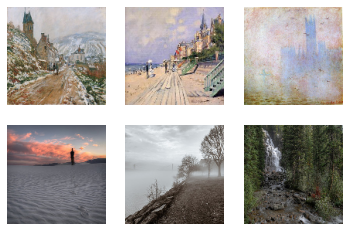

In [7]:
n_samples = 3

# plot source images
for i in range(n_samples): 
    plt.subplot(2, n_samples, 1 + i) 
    plt.axis("off") 
    plt.imshow(dataA[i].astype("int"))
 
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i) 
    plt.axis("off") 
    plt.imshow(dataB[i].astype("int"))   

In [0]:
# needed for instance normalization
!pip install -q  --no-deps tensorflow-addons~=0.7

In [0]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
    # source image input
    in_image = Input(shape=image_shape)

    # init
    init = RandomNormal(stddev=0.02)
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d) 
    
    # define model
    model = Model(in_image, patch_out)
    
    return model 

In [0]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(input_layer) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    g = Activation("relu")(g)
    
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(g) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    
    return g

In [0]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=3):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	out_image = Activation('tanh')(g)

	# define model
	model = Model(in_image, out_image)

	return model

In [12]:
# discriminator
discriminator = define_discriminator((256,256,3))
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

In [13]:
# generator
generator = define_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

In [0]:
# output omitted for brevity
from tensorflow.keras.utils import plot_model
plot_model(discriminator, "discriminator.png", show_shapes=True)
plot_model(generator, "generator.png", show_shapes=True)

In [0]:
# input shape
image_shape = (128, 128, 3)

# generator: A -> B
g_model_AtoB = define_generator(image_shape, n_resnet=6)
# generator: B -> A
g_model_BtoA = define_generator(image_shape, n_resnet=6)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

In [0]:
import tensorflow as tf

In [0]:
def real_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "real"?
    # label for real is 1
    ones = tf.ones_like(len(D_out), dtype=tf.float32)
    return mse(D_out, ones)

def fake_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "fake"?
    # label for fake is 0
    zeros = tf.zeros_like(len(D_out), dtype=tf.float32)
    return mse(D_out, zeros)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    mae = tf.keras.losses.MeanAbsoluteError()
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = mae(real_im, reconstructed_im)
    # return weighted loss
    return lambda_weight*reconstr_loss 

In [0]:
# these values come from the original paper
###########################################

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

# create optimizers for the generators and discriminators
g_AtoB_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
g_BtoA_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_A_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_B_opt = Adam(lr, beta_1=beta1, beta_2=beta2)

In [0]:
@tf.function
def train_discriminator_A(dA, gBA, images_B, images_A, d_model_A_opt):
    with tf.GradientTape() as tape:
        # discriminator A
        dA_real_logits = dA(images_A)
        dA_real_loss = real_mse_loss(dA_real_logits)

        # discriminator A on fake stuff
        fake_A = gBA(images_B)
        dA_fake_logits = dA(fake_A)
        dA_fake_loss = fake_mse_loss(dA_fake_logits)

        # total dA loss
        total_dA_loss = dA_real_loss + dA_fake_loss

    # compute gradients and backprop
    dA_grads = tape.gradient(total_dA_loss, dA.trainable_variables)
    d_model_A_opt.apply_gradients(zip(dA_grads, dA.trainable_variables))

    return total_dA_loss

# <-------------------------------------------------------------------->

@tf.function
def train_discriminator_B(dB, gAB, images_A, images_B, d_model_B_opt):
    with tf.GradientTape() as tape:
        # discriminator B
        dB_real_logits = dB(images_B)
        dB_real_loss = real_mse_loss(dB_real_logits)

        # discriminator B on fake stuff
        fake_B = gAB(images_A)
        dB_fake_logits = dB(fake_B)
        dB_fake_loss = fake_mse_loss(dB_fake_logits)

        # total dA loss
        total_dB_loss = dB_real_loss + dB_fake_loss

    # compute gradients and backprop
    dB_grads = tape.gradient(total_dB_loss, dB.trainable_variables)
    d_model_B_opt.apply_gradients(zip(dB_grads, dB.trainable_variables))

    return total_dB_loss

In [0]:
@tf.function
def train_generator_AB(dB, gAB, gBA, images_A, images_B, g_AtoB_opt):
    ###### Generator AB ######
    #########################
    with tf.GradientTape() as tape:
        # generate images from domain A to domain B, compute loss (weight 1) via
        # discriminator B
        fake_B = gAB(images_A)
        dB_fake_logits = dB(fake_B)
        gAB_loss = real_mse_loss(dB_fake_logits)

        # identity loss (weight 5)
        identity_B = gAB(images_B)
        id_loss = cycle_consistency_loss(images_B, identity_B, 5)

        # cycle consistency loss (weight 10)
        reconstructed_A = gBA(fake_B)
        reconstructed_A_loss = cycle_consistency_loss(images_A, reconstructed_A, 10)

        # total loss
        total_gAB_loss = gAB_loss + id_loss + reconstructed_A_loss
    
    # compute gradients and backprop
    gAB_grads = tape.gradient(total_gAB_loss, gAB.trainable_variables)
    g_AtoB_opt.apply_gradients(zip(gAB_grads, gAB.trainable_variables))

    return total_gAB_loss
    
# <-------------------------------------------------------------------->

@tf.function
def train_generator_BA(dA, gBA, gAB, images_B, images_A, g_BtoA_opt):
    ###### Generator BA ######
    #########################
    with tf.GradientTape() as tape:
        # generate images from domain B to domain A, compute loss (weight 1) via
        # discriminator A
        fake_A = gBA(images_B)
        dA_fake_logits = dA(fake_A)
        gBA_loss = real_mse_loss(dA_fake_logits)

        # identity loss (weight 5)
        identity_A = gBA(images_A)
        id_loss = cycle_consistency_loss(images_A, identity_A, 5)

        # cycle consistency loss (weight 10)
        reconstructed_B = gAB(fake_A)
        reconstructed_B_loss = cycle_consistency_loss(images_B, reconstructed_B, 10)

        # total loss
        total_gBA_loss = gBA_loss + id_loss + reconstructed_B_loss
    
    # compute gradients and backprop
    gBA_grads = tape.gradient(total_gBA_loss, gBA.trainable_variables)
    g_BtoA_opt.apply_gradients(zip(gBA_grads, gBA.trainable_variables))

    return total_gBA_loss

In [0]:
# check if everything works (should be run only once)

sample_Images_A = dataA[32].reshape(1, 128, 128, 3)
sample_Images_B = dataB[32].reshape(1, 128, 128, 3)

print(train_discriminator_A(d_model_A, g_model_BtoA, sample_Images_B, sample_Images_A, d_model_A_opt))
print(train_discriminator_B(d_model_B, g_model_AtoB, sample_Images_A, sample_Images_B, d_model_B_opt))

print(train_generator_AB(d_model_B, g_model_AtoB, g_model_BtoA, sample_Images_A, sample_Images_B, g_AtoB_opt))
print(train_generator_BA(d_model_A, g_model_BtoA, g_model_AtoB, sample_Images_B, sample_Images_A, g_BtoA_opt))

In [0]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, len(images), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i])
		# title
		plt.title(titles[i])
	plt.show()
 
def show_model_progress(gAB, gBA, dataA, dataB):
	# A -> B -> A
	print("[INFO] Domain A to Domain B")
	real_A = select_sample(dataA, 1)
	B_generated  = gAB.predict(real_A)
	A_reconstructed = gBA.predict(B_generated)
	show_plot(real_A, B_generated, A_reconstructed)

	# B -> A -> B
	print("[INFO] Domain B to Domain A")
	real_B = select_sample(dataB, 1)
	A_generated  = gBA.predict(real_B)
	B_reconstructed = gAB.predict(A_generated)
	show_plot(real_B, A_generated, B_reconstructed)

In [0]:
# scale data and convert to TF Dataset
scaled_dataA = (dataA - 127.5) / 127.5
scaled_dataB = (dataB - 127.5) / 127.5
data_A_TF = tf.data.Dataset.from_tensor_slices(scaled_dataA).batch(16).prefetch(100)
data_B_TF = tf.data.Dataset.from_tensor_slices(scaled_dataB).batch(16).prefetch(100)

In [0]:
# metrics to keep track of the mean loss for each epoch
gen_AB_metric = tf.keras.metrics.Mean()
gen_BA_metric = tf.keras.metrics.Mean()
disc_A_metric = tf.keras.metrics.Mean()
disc_B_metric = tf.keras.metrics.Mean()

In [24]:
!nvidia-smi

Thu Mar 26 07:12:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    35W / 250W |    871MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

  0%|          | 0/2000 [00:00<?, ?it/s]

dA_loss: 2.871 dB_loss: 3.414 gAB_loss :10.809 gBA_loss: 12.640
[INFO] Domain A to Domain B


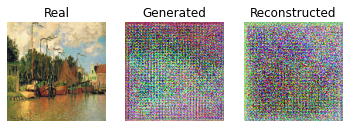

[INFO] Domain B to Domain A


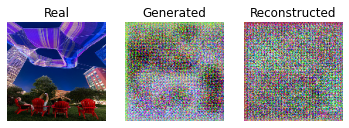

  0%|          | 2/2000 [00:45<17:03:36, 30.74s/it]

dA_loss: 17.080 dB_loss: 15.643 gAB_loss :10.855 gBA_loss: 13.635


  0%|          | 3/2000 [00:47<12:19:05, 22.21s/it]

dA_loss: 6.323 dB_loss: 4.403 gAB_loss :10.802 gBA_loss: 10.623


  0%|          | 4/2000 [00:50<9:00:14, 16.24s/it] 

dA_loss: 2.524 dB_loss: 2.414 gAB_loss :10.753 gBA_loss: 10.344


  0%|          | 5/2000 [00:52<6:41:03, 12.06s/it]

dA_loss: 3.803 dB_loss: 1.793 gAB_loss :10.310 gBA_loss: 10.059


  0%|          | 6/2000 [00:54<5:03:44,  9.14s/it]

dA_loss: 2.179 dB_loss: 1.708 gAB_loss :10.264 gBA_loss: 9.914


  0%|          | 7/2000 [00:57<3:55:41,  7.10s/it]

dA_loss: 2.346 dB_loss: 2.234 gAB_loss :10.202 gBA_loss: 9.587


  0%|          | 8/2000 [00:59<3:08:01,  5.66s/it]

dA_loss: 1.894 dB_loss: 2.355 gAB_loss :9.638 gBA_loss: 9.269


  0%|          | 9/2000 [01:01<2:34:31,  4.66s/it]

dA_loss: 1.862 dB_loss: 1.913 gAB_loss :9.894 gBA_loss: 9.168


  0%|          | 10/2000 [01:04<2:11:13,  3.96s/it]

dA_loss: 1.877 dB_loss: 2.524 gAB_loss :10.064 gBA_loss: 9.035


  1%|          | 11/2000 [01:06<1:54:50,  3.46s/it]

dA_loss: 1.556 dB_loss: 1.962 gAB_loss :9.940 gBA_loss: 9.022


  1%|          | 12/2000 [01:08<1:43:24,  3.12s/it]

dA_loss: 1.865 dB_loss: 2.321 gAB_loss :9.135 gBA_loss: 8.746


  1%|          | 13/2000 [01:11<1:35:14,  2.88s/it]

dA_loss: 1.383 dB_loss: 1.120 gAB_loss :9.414 gBA_loss: 8.502


  1%|          | 14/2000 [01:13<1:29:37,  2.71s/it]

dA_loss: 1.311 dB_loss: 1.847 gAB_loss :8.521 gBA_loss: 8.260


  1%|          | 15/2000 [01:15<1:25:36,  2.59s/it]

dA_loss: 1.108 dB_loss: 0.997 gAB_loss :7.981 gBA_loss: 7.844


  1%|          | 16/2000 [01:17<1:22:50,  2.51s/it]

dA_loss: 1.320 dB_loss: 1.057 gAB_loss :7.848 gBA_loss: 7.568


  1%|          | 17/2000 [01:20<1:21:05,  2.45s/it]

dA_loss: 1.061 dB_loss: 1.077 gAB_loss :7.374 gBA_loss: 7.246


  1%|          | 18/2000 [01:22<1:19:36,  2.41s/it]

dA_loss: 1.099 dB_loss: 0.978 gAB_loss :7.430 gBA_loss: 7.175


  1%|          | 19/2000 [01:24<1:18:31,  2.38s/it]

dA_loss: 1.138 dB_loss: 1.026 gAB_loss :7.082 gBA_loss: 7.084


  1%|          | 20/2000 [01:27<1:17:52,  2.36s/it]

dA_loss: 1.249 dB_loss: 0.966 gAB_loss :6.862 gBA_loss: 7.252


  1%|          | 21/2000 [01:29<1:17:24,  2.35s/it]

dA_loss: 1.247 dB_loss: 0.812 gAB_loss :6.865 gBA_loss: 7.191


  1%|          | 22/2000 [01:31<1:16:54,  2.33s/it]

dA_loss: 0.991 dB_loss: 0.945 gAB_loss :6.886 gBA_loss: 7.081


  1%|          | 23/2000 [01:34<1:16:45,  2.33s/it]

dA_loss: 0.897 dB_loss: 1.103 gAB_loss :7.144 gBA_loss: 7.461


  1%|          | 24/2000 [01:36<1:16:35,  2.33s/it]

dA_loss: 1.202 dB_loss: 1.153 gAB_loss :8.869 gBA_loss: 7.165


  1%|▏         | 25/2000 [01:38<1:16:28,  2.32s/it]

dA_loss: 0.983 dB_loss: 2.065 gAB_loss :8.792 gBA_loss: 6.891


  1%|▏         | 26/2000 [01:41<1:16:21,  2.32s/it]

dA_loss: 0.829 dB_loss: 1.545 gAB_loss :6.951 gBA_loss: 6.679


  1%|▏         | 27/2000 [01:43<1:16:22,  2.32s/it]

dA_loss: 1.148 dB_loss: 0.803 gAB_loss :6.808 gBA_loss: 6.363


  1%|▏         | 28/2000 [01:45<1:16:18,  2.32s/it]

dA_loss: 0.994 dB_loss: 0.678 gAB_loss :6.631 gBA_loss: 6.455


  1%|▏         | 29/2000 [01:48<1:16:00,  2.31s/it]

dA_loss: 0.869 dB_loss: 0.698 gAB_loss :6.207 gBA_loss: 6.275


  2%|▏         | 30/2000 [01:50<1:16:00,  2.31s/it]

dA_loss: 1.088 dB_loss: 0.708 gAB_loss :6.261 gBA_loss: 6.219


  2%|▏         | 31/2000 [01:52<1:15:55,  2.31s/it]

dA_loss: 0.964 dB_loss: 0.738 gAB_loss :6.030 gBA_loss: 6.228


  2%|▏         | 32/2000 [01:55<1:16:24,  2.33s/it]

dA_loss: 0.977 dB_loss: 0.731 gAB_loss :6.002 gBA_loss: 6.476


  2%|▏         | 33/2000 [01:57<1:16:23,  2.33s/it]

dA_loss: 1.081 dB_loss: 0.586 gAB_loss :6.069 gBA_loss: 6.820


  2%|▏         | 34/2000 [01:59<1:16:15,  2.33s/it]

dA_loss: 1.338 dB_loss: 0.680 gAB_loss :5.967 gBA_loss: 7.217


  2%|▏         | 35/2000 [02:01<1:16:03,  2.32s/it]

dA_loss: 1.131 dB_loss: 0.639 gAB_loss :6.207 gBA_loss: 7.673


  2%|▏         | 36/2000 [02:04<1:15:53,  2.32s/it]

dA_loss: 1.090 dB_loss: 0.632 gAB_loss :6.279 gBA_loss: 7.080


  2%|▏         | 37/2000 [02:06<1:15:48,  2.32s/it]

dA_loss: 0.607 dB_loss: 0.669 gAB_loss :6.216 gBA_loss: 6.682


  2%|▏         | 38/2000 [02:08<1:15:45,  2.32s/it]

dA_loss: 0.781 dB_loss: 0.875 gAB_loss :7.534 gBA_loss: 6.852


  2%|▏         | 39/2000 [02:11<1:15:58,  2.32s/it]

dA_loss: 0.696 dB_loss: 1.642 gAB_loss :7.275 gBA_loss: 6.344


  2%|▏         | 40/2000 [02:13<1:15:48,  2.32s/it]

dA_loss: 0.757 dB_loss: 1.223 gAB_loss :6.887 gBA_loss: 6.077


  2%|▏         | 41/2000 [02:15<1:15:57,  2.33s/it]

dA_loss: 0.797 dB_loss: 0.704 gAB_loss :6.488 gBA_loss: 5.908


  2%|▏         | 42/2000 [02:18<1:15:43,  2.32s/it]

dA_loss: 0.831 dB_loss: 0.724 gAB_loss :6.036 gBA_loss: 5.843


  2%|▏         | 43/2000 [02:20<1:15:43,  2.32s/it]

dA_loss: 0.877 dB_loss: 0.697 gAB_loss :5.976 gBA_loss: 5.720


  2%|▏         | 44/2000 [02:22<1:15:30,  2.32s/it]

dA_loss: 0.793 dB_loss: 0.640 gAB_loss :5.833 gBA_loss: 5.745


  2%|▏         | 45/2000 [02:25<1:15:23,  2.31s/it]

dA_loss: 0.620 dB_loss: 0.667 gAB_loss :5.777 gBA_loss: 5.773


  2%|▏         | 46/2000 [02:27<1:15:20,  2.31s/it]

dA_loss: 0.679 dB_loss: 0.639 gAB_loss :5.674 gBA_loss: 6.337


  2%|▏         | 47/2000 [02:29<1:15:11,  2.31s/it]

dA_loss: 0.992 dB_loss: 0.610 gAB_loss :6.005 gBA_loss: 6.688


  2%|▏         | 48/2000 [02:32<1:15:09,  2.31s/it]

dA_loss: 1.718 dB_loss: 0.528 gAB_loss :6.032 gBA_loss: 8.027


  2%|▏         | 49/2000 [02:34<1:15:00,  2.31s/it]

dA_loss: 1.357 dB_loss: 0.494 gAB_loss :5.928 gBA_loss: 6.806


  2%|▎         | 50/2000 [02:36<1:14:58,  2.31s/it]

dA_loss: 1.233 dB_loss: 0.527 gAB_loss :5.954 gBA_loss: 7.402
dA_loss: 1.367 dB_loss: 0.773 gAB_loss :6.522 gBA_loss: 6.852
[INFO] Domain A to Domain B


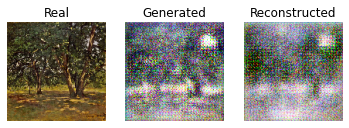

[INFO] Domain B to Domain A


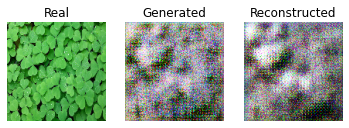

  3%|▎         | 52/2000 [02:41<1:17:44,  2.39s/it]

dA_loss: 0.975 dB_loss: 0.729 gAB_loss :6.141 gBA_loss: 6.569


  3%|▎         | 53/2000 [02:44<1:17:02,  2.37s/it]

dA_loss: 0.779 dB_loss: 0.793 gAB_loss :5.944 gBA_loss: 6.256


  3%|▎         | 54/2000 [02:46<1:16:19,  2.35s/it]

dA_loss: 0.723 dB_loss: 0.493 gAB_loss :5.950 gBA_loss: 5.774


  3%|▎         | 55/2000 [02:48<1:16:00,  2.34s/it]

dA_loss: 0.607 dB_loss: 0.589 gAB_loss :5.833 gBA_loss: 5.793


  3%|▎         | 56/2000 [02:50<1:15:36,  2.33s/it]

dA_loss: 0.669 dB_loss: 0.619 gAB_loss :5.916 gBA_loss: 5.831


  3%|▎         | 57/2000 [02:53<1:15:16,  2.32s/it]

dA_loss: 0.501 dB_loss: 0.669 gAB_loss :5.780 gBA_loss: 5.645


  3%|▎         | 58/2000 [02:55<1:15:15,  2.33s/it]

dA_loss: 0.820 dB_loss: 0.603 gAB_loss :5.994 gBA_loss: 5.838


  3%|▎         | 59/2000 [02:57<1:15:02,  2.32s/it]

dA_loss: 0.651 dB_loss: 0.821 gAB_loss :6.063 gBA_loss: 5.577


  3%|▎         | 60/2000 [03:00<1:14:44,  2.31s/it]

dA_loss: 0.613 dB_loss: 0.758 gAB_loss :6.008 gBA_loss: 5.617


  3%|▎         | 61/2000 [03:02<1:14:29,  2.31s/it]

dA_loss: 0.571 dB_loss: 0.856 gAB_loss :5.997 gBA_loss: 5.931


  3%|▎         | 62/2000 [03:04<1:14:23,  2.30s/it]

dA_loss: 0.522 dB_loss: 0.595 gAB_loss :6.220 gBA_loss: 5.949


  3%|▎         | 63/2000 [03:07<1:14:16,  2.30s/it]

dA_loss: 0.964 dB_loss: 0.645 gAB_loss :6.027 gBA_loss: 6.056


  3%|▎         | 64/2000 [03:09<1:14:08,  2.30s/it]

dA_loss: 0.881 dB_loss: 0.660 gAB_loss :6.018 gBA_loss: 6.233


  3%|▎         | 65/2000 [03:11<1:14:23,  2.31s/it]

dA_loss: 0.818 dB_loss: 0.516 gAB_loss :5.957 gBA_loss: 6.061


  3%|▎         | 66/2000 [03:14<1:14:28,  2.31s/it]

dA_loss: 0.596 dB_loss: 0.723 gAB_loss :5.634 gBA_loss: 6.198


  3%|▎         | 67/2000 [03:16<1:14:19,  2.31s/it]

dA_loss: 0.959 dB_loss: 0.605 gAB_loss :5.838 gBA_loss: 6.340


  3%|▎         | 68/2000 [03:18<1:14:21,  2.31s/it]

dA_loss: 0.963 dB_loss: 0.623 gAB_loss :5.572 gBA_loss: 5.942


  3%|▎         | 69/2000 [03:20<1:14:17,  2.31s/it]

dA_loss: 0.640 dB_loss: 0.526 gAB_loss :5.510 gBA_loss: 6.005


  4%|▎         | 70/2000 [03:23<1:14:13,  2.31s/it]

dA_loss: 0.681 dB_loss: 0.536 gAB_loss :5.698 gBA_loss: 5.870


  4%|▎         | 71/2000 [03:25<1:14:07,  2.31s/it]

dA_loss: 0.552 dB_loss: 0.419 gAB_loss :5.509 gBA_loss: 5.832


  4%|▎         | 72/2000 [03:27<1:14:00,  2.30s/it]

dA_loss: 0.510 dB_loss: 0.522 gAB_loss :5.715 gBA_loss: 5.606


  4%|▎         | 73/2000 [03:30<1:14:02,  2.31s/it]

dA_loss: 0.572 dB_loss: 0.409 gAB_loss :5.702 gBA_loss: 5.467


  4%|▎         | 74/2000 [03:32<1:14:03,  2.31s/it]

dA_loss: 0.570 dB_loss: 0.383 gAB_loss :5.864 gBA_loss: 5.683


  4%|▍         | 75/2000 [03:34<1:13:49,  2.30s/it]

dA_loss: 0.472 dB_loss: 0.521 gAB_loss :5.967 gBA_loss: 5.647


  4%|▍         | 76/2000 [03:37<1:13:38,  2.30s/it]

dA_loss: 0.446 dB_loss: 0.653 gAB_loss :6.560 gBA_loss: 5.615


  4%|▍         | 77/2000 [03:39<1:13:38,  2.30s/it]

dA_loss: 0.323 dB_loss: 0.787 gAB_loss :5.767 gBA_loss: 5.792


  4%|▍         | 78/2000 [03:41<1:13:50,  2.31s/it]

dA_loss: 0.727 dB_loss: 0.548 gAB_loss :6.100 gBA_loss: 6.267


  4%|▍         | 79/2000 [03:43<1:13:46,  2.30s/it]

dA_loss: 0.719 dB_loss: 0.585 gAB_loss :5.888 gBA_loss: 6.041


  4%|▍         | 80/2000 [03:46<1:13:50,  2.31s/it]

dA_loss: 0.931 dB_loss: 0.649 gAB_loss :5.744 gBA_loss: 6.041


  4%|▍         | 81/2000 [03:48<1:13:47,  2.31s/it]

dA_loss: 0.747 dB_loss: 0.652 gAB_loss :5.894 gBA_loss: 6.387


  4%|▍         | 82/2000 [03:50<1:13:43,  2.31s/it]

dA_loss: 0.741 dB_loss: 0.642 gAB_loss :5.591 gBA_loss: 5.717


  4%|▍         | 83/2000 [03:53<1:13:23,  2.30s/it]

dA_loss: 0.694 dB_loss: 0.518 gAB_loss :5.371 gBA_loss: 5.821


  4%|▍         | 84/2000 [03:55<1:13:18,  2.30s/it]

dA_loss: 0.530 dB_loss: 0.581 gAB_loss :5.324 gBA_loss: 5.630


  4%|▍         | 85/2000 [03:57<1:13:12,  2.29s/it]

dA_loss: 0.588 dB_loss: 0.505 gAB_loss :5.440 gBA_loss: 5.754


  4%|▍         | 86/2000 [04:00<1:13:08,  2.29s/it]

dA_loss: 0.522 dB_loss: 0.445 gAB_loss :5.162 gBA_loss: 5.454


  4%|▍         | 87/2000 [04:02<1:13:04,  2.29s/it]

dA_loss: 0.953 dB_loss: 0.458 gAB_loss :5.590 gBA_loss: 5.980


  4%|▍         | 88/2000 [04:04<1:13:08,  2.30s/it]

dA_loss: 0.835 dB_loss: 0.472 gAB_loss :5.799 gBA_loss: 5.590


  4%|▍         | 89/2000 [04:06<1:13:04,  2.29s/it]

dA_loss: 0.656 dB_loss: 0.889 gAB_loss :6.404 gBA_loss: 6.383


  4%|▍         | 90/2000 [04:09<1:12:58,  2.29s/it]

dA_loss: 0.847 dB_loss: 1.390 gAB_loss :6.686 gBA_loss: 5.591


  5%|▍         | 91/2000 [04:11<1:12:56,  2.29s/it]

dA_loss: 0.670 dB_loss: 1.110 gAB_loss :7.813 gBA_loss: 6.251


  5%|▍         | 92/2000 [04:13<1:12:57,  2.29s/it]

dA_loss: 0.809 dB_loss: 2.427 gAB_loss :6.636 gBA_loss: 6.057


  5%|▍         | 93/2000 [04:16<1:12:58,  2.30s/it]

dA_loss: 0.710 dB_loss: 1.449 gAB_loss :9.171 gBA_loss: 6.502


  5%|▍         | 94/2000 [04:18<1:12:55,  2.30s/it]

dA_loss: 1.119 dB_loss: 2.257 gAB_loss :6.345 gBA_loss: 6.360


  5%|▍         | 95/2000 [04:20<1:12:47,  2.29s/it]

dA_loss: 1.369 dB_loss: 1.439 gAB_loss :7.174 gBA_loss: 7.196


  5%|▍         | 96/2000 [04:22<1:12:48,  2.29s/it]

dA_loss: 1.601 dB_loss: 0.856 gAB_loss :6.048 gBA_loss: 6.332


  5%|▍         | 97/2000 [04:25<1:12:38,  2.29s/it]

dA_loss: 0.855 dB_loss: 0.706 gAB_loss :5.639 gBA_loss: 6.122


  5%|▍         | 98/2000 [04:27<1:12:41,  2.29s/it]

dA_loss: 0.881 dB_loss: 0.672 gAB_loss :6.018 gBA_loss: 5.801


  5%|▍         | 99/2000 [04:29<1:12:37,  2.29s/it]

dA_loss: 0.539 dB_loss: 0.785 gAB_loss :5.608 gBA_loss: 5.645


  5%|▌         | 100/2000 [04:32<1:12:34,  2.29s/it]

dA_loss: 0.539 dB_loss: 0.745 gAB_loss :5.654 gBA_loss: 5.453
dA_loss: 0.482 dB_loss: 0.478 gAB_loss :5.312 gBA_loss: 5.404
[INFO] Domain A to Domain B


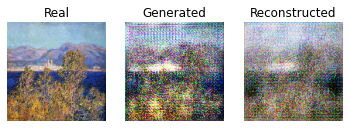

[INFO] Domain B to Domain A


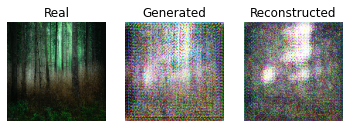

  5%|▌         | 102/2000 [04:37<1:14:58,  2.37s/it]

dA_loss: 0.436 dB_loss: 0.534 gAB_loss :5.237 gBA_loss: 5.289


  5%|▌         | 103/2000 [04:39<1:14:12,  2.35s/it]

dA_loss: 0.442 dB_loss: 0.452 gAB_loss :5.203 gBA_loss: 5.304


  5%|▌         | 104/2000 [04:41<1:13:42,  2.33s/it]

dA_loss: 0.391 dB_loss: 0.424 gAB_loss :5.151 gBA_loss: 5.200


  5%|▌         | 105/2000 [04:43<1:13:13,  2.32s/it]

dA_loss: 0.341 dB_loss: 0.345 gAB_loss :5.198 gBA_loss: 5.626


  5%|▌         | 106/2000 [04:46<1:13:06,  2.32s/it]

dA_loss: 0.281 dB_loss: 0.322 gAB_loss :5.637 gBA_loss: 5.560


  5%|▌         | 107/2000 [04:48<1:12:50,  2.31s/it]

dA_loss: 0.286 dB_loss: 0.420 gAB_loss :5.393 gBA_loss: 6.011


  5%|▌         | 108/2000 [04:50<1:12:37,  2.30s/it]

dA_loss: 0.294 dB_loss: 0.462 gAB_loss :5.697 gBA_loss: 5.886


  5%|▌         | 109/2000 [04:53<1:12:32,  2.30s/it]

dA_loss: 0.351 dB_loss: 0.272 gAB_loss :5.442 gBA_loss: 5.649


  6%|▌         | 110/2000 [04:55<1:12:23,  2.30s/it]

dA_loss: 0.328 dB_loss: 0.387 gAB_loss :5.396 gBA_loss: 5.457


  6%|▌         | 111/2000 [04:57<1:12:14,  2.29s/it]

dA_loss: 0.336 dB_loss: 0.308 gAB_loss :5.345 gBA_loss: 5.510


  6%|▌         | 112/2000 [05:00<1:12:11,  2.29s/it]

dA_loss: 0.327 dB_loss: 0.415 gAB_loss :5.406 gBA_loss: 5.389


  6%|▌         | 113/2000 [05:02<1:12:16,  2.30s/it]

dA_loss: 0.330 dB_loss: 0.303 gAB_loss :5.308 gBA_loss: 5.539


  6%|▌         | 114/2000 [05:04<1:12:07,  2.29s/it]

dA_loss: 0.313 dB_loss: 0.388 gAB_loss :5.603 gBA_loss: 5.649


  6%|▌         | 115/2000 [05:06<1:12:09,  2.30s/it]

dA_loss: 0.302 dB_loss: 0.353 gAB_loss :5.366 gBA_loss: 5.674


  6%|▌         | 116/2000 [05:09<1:12:04,  2.30s/it]

dA_loss: 0.252 dB_loss: 0.293 gAB_loss :5.598 gBA_loss: 5.709


  6%|▌         | 117/2000 [05:11<1:11:52,  2.29s/it]

dA_loss: 0.239 dB_loss: 0.365 gAB_loss :5.367 gBA_loss: 5.621


  6%|▌         | 118/2000 [05:13<1:11:43,  2.29s/it]

dA_loss: 0.346 dB_loss: 0.323 gAB_loss :5.504 gBA_loss: 5.800


  6%|▌         | 119/2000 [05:16<1:11:39,  2.29s/it]

dA_loss: 0.324 dB_loss: 0.277 gAB_loss :5.286 gBA_loss: 5.408


  6%|▌         | 120/2000 [05:18<1:11:47,  2.29s/it]

dA_loss: 0.558 dB_loss: 0.216 gAB_loss :5.488 gBA_loss: 6.231


  6%|▌         | 121/2000 [05:20<1:11:38,  2.29s/it]

dA_loss: 0.500 dB_loss: 0.188 gAB_loss :5.755 gBA_loss: 5.460


  6%|▌         | 122/2000 [05:22<1:11:36,  2.29s/it]

dA_loss: 0.569 dB_loss: 0.360 gAB_loss :5.630 gBA_loss: 5.674


  6%|▌         | 123/2000 [05:25<1:11:27,  2.28s/it]

dA_loss: 0.365 dB_loss: 0.302 gAB_loss :5.513 gBA_loss: 5.468


  6%|▌         | 124/2000 [05:27<1:11:37,  2.29s/it]

dA_loss: 0.427 dB_loss: 0.368 gAB_loss :5.280 gBA_loss: 5.778


  6%|▋         | 125/2000 [05:29<1:11:29,  2.29s/it]

dA_loss: 0.497 dB_loss: 0.308 gAB_loss :5.524 gBA_loss: 5.447


  6%|▋         | 126/2000 [05:32<1:11:38,  2.29s/it]

dA_loss: 0.628 dB_loss: 0.289 gAB_loss :5.220 gBA_loss: 5.869


  6%|▋         | 127/2000 [05:34<1:11:33,  2.29s/it]

dA_loss: 0.718 dB_loss: 0.361 gAB_loss :5.377 gBA_loss: 5.786


  6%|▋         | 128/2000 [05:36<1:11:37,  2.30s/it]

dA_loss: 0.487 dB_loss: 0.370 gAB_loss :5.282 gBA_loss: 6.161


  6%|▋         | 129/2000 [05:39<1:11:45,  2.30s/it]

dA_loss: 0.749 dB_loss: 0.322 gAB_loss :5.225 gBA_loss: 5.474


  6%|▋         | 130/2000 [05:41<1:11:46,  2.30s/it]

dA_loss: 0.947 dB_loss: 0.351 gAB_loss :5.222 gBA_loss: 6.469


  7%|▋         | 131/2000 [05:43<1:11:30,  2.30s/it]

dA_loss: 1.003 dB_loss: 0.284 gAB_loss :5.479 gBA_loss: 5.786


  7%|▋         | 132/2000 [05:45<1:11:34,  2.30s/it]

dA_loss: 0.594 dB_loss: 0.248 gAB_loss :5.271 gBA_loss: 6.012


  7%|▋         | 133/2000 [05:48<1:11:23,  2.29s/it]

dA_loss: 0.541 dB_loss: 0.267 gAB_loss :5.520 gBA_loss: 5.511


  7%|▋         | 134/2000 [05:50<1:11:23,  2.30s/it]

dA_loss: 0.430 dB_loss: 0.252 gAB_loss :5.536 gBA_loss: 5.366


  7%|▋         | 135/2000 [05:52<1:11:03,  2.29s/it]

dA_loss: 0.390 dB_loss: 0.383 gAB_loss :5.597 gBA_loss: 5.441


  7%|▋         | 136/2000 [05:55<1:11:13,  2.29s/it]

dA_loss: 0.407 dB_loss: 0.318 gAB_loss :5.575 gBA_loss: 5.195


  7%|▋         | 137/2000 [05:57<1:11:16,  2.30s/it]

dA_loss: 0.283 dB_loss: 0.425 gAB_loss :5.351 gBA_loss: 5.281


  7%|▋         | 138/2000 [05:59<1:11:08,  2.29s/it]

dA_loss: 0.249 dB_loss: 0.300 gAB_loss :5.815 gBA_loss: 5.533


  7%|▋         | 139/2000 [06:01<1:11:03,  2.29s/it]

dA_loss: 0.374 dB_loss: 0.254 gAB_loss :5.239 gBA_loss: 5.746


  7%|▋         | 140/2000 [06:04<1:11:00,  2.29s/it]

dA_loss: 0.381 dB_loss: 0.383 gAB_loss :5.583 gBA_loss: 5.573


  7%|▋         | 141/2000 [06:06<1:10:53,  2.29s/it]

dA_loss: 0.476 dB_loss: 0.381 gAB_loss :5.686 gBA_loss: 5.832


  7%|▋         | 142/2000 [06:08<1:10:43,  2.28s/it]

dA_loss: 0.256 dB_loss: 0.581 gAB_loss :5.745 gBA_loss: 5.560


  7%|▋         | 143/2000 [06:11<1:10:41,  2.28s/it]

dA_loss: 0.248 dB_loss: 0.673 gAB_loss :6.140 gBA_loss: 5.526


  7%|▋         | 144/2000 [06:13<1:10:39,  2.28s/it]

dA_loss: 0.280 dB_loss: 0.748 gAB_loss :5.656 gBA_loss: 5.717


  7%|▋         | 145/2000 [06:15<1:10:27,  2.28s/it]

dA_loss: 0.298 dB_loss: 0.484 gAB_loss :5.609 gBA_loss: 5.257


  7%|▋         | 146/2000 [06:17<1:10:25,  2.28s/it]

dA_loss: 0.460 dB_loss: 0.344 gAB_loss :5.453 gBA_loss: 5.716


  7%|▋         | 147/2000 [06:20<1:10:31,  2.28s/it]

dA_loss: 0.352 dB_loss: 0.589 gAB_loss :5.696 gBA_loss: 5.509


  7%|▋         | 148/2000 [06:22<1:10:37,  2.29s/it]

dA_loss: 0.337 dB_loss: 0.567 gAB_loss :5.361 gBA_loss: 5.283


  7%|▋         | 149/2000 [06:24<1:10:28,  2.28s/it]

dA_loss: 0.349 dB_loss: 0.248 gAB_loss :5.371 gBA_loss: 5.754


  8%|▊         | 150/2000 [06:27<1:10:19,  2.28s/it]

dA_loss: 0.266 dB_loss: 0.420 gAB_loss :5.466 gBA_loss: 5.261
dA_loss: 0.459 dB_loss: 0.491 gAB_loss :5.552 gBA_loss: 5.540
[INFO] Domain A to Domain B


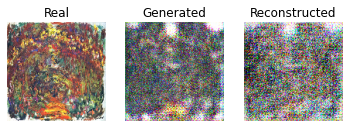

[INFO] Domain B to Domain A


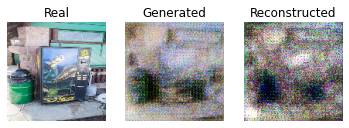

  8%|▊         | 152/2000 [06:31<1:12:42,  2.36s/it]

dA_loss: 0.372 dB_loss: 0.334 gAB_loss :5.282 gBA_loss: 5.553


  8%|▊         | 153/2000 [06:34<1:11:54,  2.34s/it]

dA_loss: 0.320 dB_loss: 0.309 gAB_loss :5.465 gBA_loss: 5.600


  8%|▊         | 154/2000 [06:36<1:11:26,  2.32s/it]

dA_loss: 0.261 dB_loss: 0.388 gAB_loss :5.253 gBA_loss: 5.379


  8%|▊         | 155/2000 [06:38<1:10:57,  2.31s/it]

dA_loss: 0.249 dB_loss: 0.238 gAB_loss :5.212 gBA_loss: 5.670


  8%|▊         | 156/2000 [06:41<1:10:51,  2.31s/it]

dA_loss: 0.257 dB_loss: 0.316 gAB_loss :5.450 gBA_loss: 5.363


  8%|▊         | 157/2000 [06:43<1:10:35,  2.30s/it]

dA_loss: 0.238 dB_loss: 0.405 gAB_loss :5.401 gBA_loss: 5.362


  8%|▊         | 158/2000 [06:45<1:10:19,  2.29s/it]

dA_loss: 0.281 dB_loss: 0.272 gAB_loss :5.331 gBA_loss: 5.635


  8%|▊         | 159/2000 [06:47<1:10:01,  2.28s/it]

dA_loss: 0.266 dB_loss: 0.285 gAB_loss :5.441 gBA_loss: 5.528


  8%|▊         | 160/2000 [06:50<1:10:10,  2.29s/it]

dA_loss: 0.339 dB_loss: 0.357 gAB_loss :5.536 gBA_loss: 5.514


  8%|▊         | 161/2000 [06:52<1:10:07,  2.29s/it]

dA_loss: 0.392 dB_loss: 0.228 gAB_loss :5.210 gBA_loss: 5.531


  8%|▊         | 162/2000 [06:54<1:10:19,  2.30s/it]

dA_loss: 0.359 dB_loss: 0.356 gAB_loss :5.263 gBA_loss: 5.387


  8%|▊         | 163/2000 [06:57<1:10:13,  2.29s/it]

dA_loss: 0.463 dB_loss: 0.242 gAB_loss :5.257 gBA_loss: 5.390


  8%|▊         | 164/2000 [06:59<1:09:59,  2.29s/it]

dA_loss: 0.324 dB_loss: 0.221 gAB_loss :5.340 gBA_loss: 5.817


  8%|▊         | 165/2000 [07:01<1:09:48,  2.28s/it]

dA_loss: 0.260 dB_loss: 0.225 gAB_loss :5.435 gBA_loss: 5.265


  8%|▊         | 166/2000 [07:03<1:09:39,  2.28s/it]

dA_loss: 0.470 dB_loss: 0.353 gAB_loss :5.667 gBA_loss: 5.892


  8%|▊         | 167/2000 [07:06<1:09:42,  2.28s/it]

dA_loss: 0.319 dB_loss: 0.276 gAB_loss :5.459 gBA_loss: 5.691


  8%|▊         | 168/2000 [07:08<1:09:40,  2.28s/it]

dA_loss: 0.259 dB_loss: 0.273 gAB_loss :5.382 gBA_loss: 5.788


  8%|▊         | 169/2000 [07:10<1:09:37,  2.28s/it]

dA_loss: 0.230 dB_loss: 0.268 gAB_loss :5.322 gBA_loss: 5.223


  8%|▊         | 170/2000 [07:13<1:09:39,  2.28s/it]

dA_loss: 0.291 dB_loss: 0.237 gAB_loss :5.254 gBA_loss: 5.438


  9%|▊         | 171/2000 [07:15<1:09:34,  2.28s/it]

dA_loss: 0.296 dB_loss: 0.236 gAB_loss :5.070 gBA_loss: 5.035


  9%|▊         | 172/2000 [07:17<1:09:26,  2.28s/it]

dA_loss: 0.396 dB_loss: 0.236 gAB_loss :5.190 gBA_loss: 5.178


  9%|▊         | 173/2000 [07:19<1:09:31,  2.28s/it]

dA_loss: 0.280 dB_loss: 0.203 gAB_loss :5.021 gBA_loss: 5.240


  9%|▊         | 174/2000 [07:22<1:09:31,  2.28s/it]

dA_loss: 0.270 dB_loss: 0.263 gAB_loss :5.449 gBA_loss: 5.595


  9%|▉         | 175/2000 [07:24<1:09:37,  2.29s/it]

dA_loss: 0.568 dB_loss: 0.205 gAB_loss :5.233 gBA_loss: 5.641


  9%|▉         | 176/2000 [07:26<1:09:39,  2.29s/it]

dA_loss: 0.639 dB_loss: 0.284 gAB_loss :5.426 gBA_loss: 6.109


  9%|▉         | 177/2000 [07:29<1:09:26,  2.29s/it]

dA_loss: 0.500 dB_loss: 0.253 gAB_loss :5.353 gBA_loss: 5.731


  9%|▉         | 178/2000 [07:31<1:09:13,  2.28s/it]

dA_loss: 0.566 dB_loss: 0.417 gAB_loss :5.446 gBA_loss: 5.609


  9%|▉         | 179/2000 [07:33<1:09:11,  2.28s/it]

dA_loss: 0.396 dB_loss: 0.419 gAB_loss :5.215 gBA_loss: 5.697


  9%|▉         | 180/2000 [07:35<1:09:07,  2.28s/it]

dA_loss: 0.310 dB_loss: 0.330 gAB_loss :5.021 gBA_loss: 5.261


  9%|▉         | 181/2000 [07:38<1:09:01,  2.28s/it]

dA_loss: 0.387 dB_loss: 0.365 gAB_loss :5.207 gBA_loss: 5.918


  9%|▉         | 182/2000 [07:40<1:08:58,  2.28s/it]

dA_loss: 0.443 dB_loss: 0.166 gAB_loss :5.260 gBA_loss: 5.694


  9%|▉         | 183/2000 [07:42<1:08:55,  2.28s/it]

dA_loss: 0.398 dB_loss: 0.209 gAB_loss :5.476 gBA_loss: 6.169


  9%|▉         | 184/2000 [07:45<1:08:53,  2.28s/it]

dA_loss: 0.896 dB_loss: 0.223 gAB_loss :5.604 gBA_loss: 5.548


  9%|▉         | 185/2000 [07:47<1:08:44,  2.27s/it]

dA_loss: 0.754 dB_loss: 0.412 gAB_loss :5.559 gBA_loss: 8.002


  9%|▉         | 186/2000 [07:49<1:08:49,  2.28s/it]

dA_loss: 3.105 dB_loss: 0.294 gAB_loss :5.510 gBA_loss: 7.004


  9%|▉         | 187/2000 [07:51<1:08:44,  2.27s/it]

dA_loss: 2.581 dB_loss: 0.265 gAB_loss :5.409 gBA_loss: 9.594


  9%|▉         | 188/2000 [07:54<1:08:42,  2.28s/it]

dA_loss: 4.181 dB_loss: 0.160 gAB_loss :5.436 gBA_loss: 11.873


  9%|▉         | 189/2000 [07:56<1:08:49,  2.28s/it]

dA_loss: 8.417 dB_loss: 0.156 gAB_loss :5.527 gBA_loss: 8.961


 10%|▉         | 190/2000 [07:58<1:08:53,  2.28s/it]

dA_loss: 5.016 dB_loss: 0.247 gAB_loss :5.543 gBA_loss: 12.069


 10%|▉         | 191/2000 [08:00<1:08:42,  2.28s/it]

dA_loss: 12.145 dB_loss: 0.220 gAB_loss :5.582 gBA_loss: 13.991


 10%|▉         | 192/2000 [08:03<1:08:30,  2.27s/it]

dA_loss: 10.367 dB_loss: 0.318 gAB_loss :6.006 gBA_loss: 10.014


 10%|▉         | 193/2000 [08:05<1:08:29,  2.27s/it]

dA_loss: 5.294 dB_loss: 0.235 gAB_loss :6.007 gBA_loss: 8.818


 10%|▉         | 194/2000 [08:07<1:08:22,  2.27s/it]

dA_loss: 2.462 dB_loss: 0.216 gAB_loss :5.399 gBA_loss: 6.847


 10%|▉         | 195/2000 [08:10<1:08:22,  2.27s/it]

dA_loss: 1.042 dB_loss: 0.295 gAB_loss :5.423 gBA_loss: 6.709


 10%|▉         | 196/2000 [08:12<1:08:18,  2.27s/it]

dA_loss: 0.866 dB_loss: 0.260 gAB_loss :5.421 gBA_loss: 6.072


 10%|▉         | 197/2000 [08:14<1:08:16,  2.27s/it]

dA_loss: 0.724 dB_loss: 0.305 gAB_loss :5.318 gBA_loss: 5.660


 10%|▉         | 198/2000 [08:16<1:08:13,  2.27s/it]

dA_loss: 0.472 dB_loss: 0.424 gAB_loss :5.458 gBA_loss: 5.601


 10%|▉         | 199/2000 [08:19<1:08:10,  2.27s/it]

dA_loss: 0.341 dB_loss: 0.432 gAB_loss :5.464 gBA_loss: 5.330


 10%|█         | 200/2000 [08:21<1:08:19,  2.28s/it]

dA_loss: 0.313 dB_loss: 0.317 gAB_loss :5.188 gBA_loss: 5.600
dA_loss: 0.241 dB_loss: 0.424 gAB_loss :5.686 gBA_loss: 5.323
[INFO] Domain A to Domain B


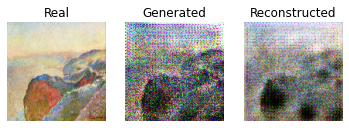

[INFO] Domain B to Domain A


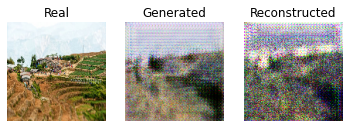

 10%|█         | 202/2000 [08:26<1:10:42,  2.36s/it]

dA_loss: 0.257 dB_loss: 0.537 gAB_loss :5.158 gBA_loss: 5.154


 10%|█         | 203/2000 [08:28<1:09:59,  2.34s/it]

dA_loss: 0.268 dB_loss: 0.554 gAB_loss :5.177 gBA_loss: 5.366


 10%|█         | 204/2000 [08:30<1:09:22,  2.32s/it]

dA_loss: 0.222 dB_loss: 0.760 gAB_loss :4.717 gBA_loss: 5.148


 10%|█         | 205/2000 [08:33<1:08:53,  2.30s/it]

dA_loss: 0.262 dB_loss: 0.584 gAB_loss :5.828 gBA_loss: 5.184


 10%|█         | 206/2000 [08:35<1:08:28,  2.29s/it]

dA_loss: 0.208 dB_loss: 1.359 gAB_loss :4.603 gBA_loss: 5.091


 10%|█         | 207/2000 [08:37<1:08:15,  2.28s/it]

dA_loss: 0.278 dB_loss: 0.848 gAB_loss :6.171 gBA_loss: 5.265


 10%|█         | 208/2000 [08:39<1:07:57,  2.28s/it]

dA_loss: 0.214 dB_loss: 2.015 gAB_loss :5.339 gBA_loss: 5.333


 10%|█         | 209/2000 [08:42<1:07:53,  2.27s/it]

dA_loss: 0.219 dB_loss: 2.214 gAB_loss :7.348 gBA_loss: 5.077


 10%|█         | 210/2000 [08:44<1:08:02,  2.28s/it]

dA_loss: 0.273 dB_loss: 2.516 gAB_loss :6.192 gBA_loss: 5.064


 11%|█         | 211/2000 [08:46<1:07:52,  2.28s/it]

dA_loss: 0.265 dB_loss: 2.003 gAB_loss :6.331 gBA_loss: 5.112


 11%|█         | 212/2000 [08:49<1:07:54,  2.28s/it]

dA_loss: 0.251 dB_loss: 1.367 gAB_loss :5.877 gBA_loss: 4.927


 11%|█         | 213/2000 [08:51<1:07:56,  2.28s/it]

dA_loss: 0.274 dB_loss: 1.048 gAB_loss :5.254 gBA_loss: 4.909


 11%|█         | 214/2000 [08:53<1:07:42,  2.27s/it]

dA_loss: 0.269 dB_loss: 0.700 gAB_loss :5.027 gBA_loss: 4.931


 11%|█         | 215/2000 [08:55<1:07:48,  2.28s/it]

dA_loss: 0.245 dB_loss: 0.391 gAB_loss :4.815 gBA_loss: 4.877


 11%|█         | 216/2000 [08:58<1:07:46,  2.28s/it]

dA_loss: 0.274 dB_loss: 0.318 gAB_loss :4.860 gBA_loss: 5.079


 11%|█         | 217/2000 [09:00<1:07:41,  2.28s/it]

dA_loss: 0.212 dB_loss: 0.283 gAB_loss :4.750 gBA_loss: 4.912


 11%|█         | 218/2000 [09:02<1:07:38,  2.28s/it]

dA_loss: 0.266 dB_loss: 0.262 gAB_loss :4.685 gBA_loss: 4.914


 11%|█         | 219/2000 [09:05<1:07:30,  2.27s/it]

dA_loss: 0.281 dB_loss: 0.213 gAB_loss :4.812 gBA_loss: 4.953


 11%|█         | 220/2000 [09:07<1:07:23,  2.27s/it]

dA_loss: 0.245 dB_loss: 0.172 gAB_loss :4.744 gBA_loss: 5.016


 11%|█         | 221/2000 [09:09<1:07:24,  2.27s/it]

dA_loss: 0.236 dB_loss: 0.151 gAB_loss :4.908 gBA_loss: 4.895


 11%|█         | 222/2000 [09:11<1:07:24,  2.27s/it]

dA_loss: 0.281 dB_loss: 0.146 gAB_loss :4.886 gBA_loss: 4.846


 11%|█         | 223/2000 [09:14<1:07:21,  2.27s/it]

dA_loss: 0.284 dB_loss: 0.129 gAB_loss :4.898 gBA_loss: 4.900


 11%|█         | 224/2000 [09:16<1:07:13,  2.27s/it]

dA_loss: 0.264 dB_loss: 0.158 gAB_loss :4.906 gBA_loss: 4.812


 11%|█▏        | 225/2000 [09:18<1:07:06,  2.27s/it]

dA_loss: 0.241 dB_loss: 0.136 gAB_loss :4.883 gBA_loss: 4.869


 11%|█▏        | 226/2000 [09:20<1:07:02,  2.27s/it]

dA_loss: 0.292 dB_loss: 0.146 gAB_loss :4.873 gBA_loss: 4.854


 11%|█▏        | 227/2000 [09:23<1:07:00,  2.27s/it]

dA_loss: 0.238 dB_loss: 0.133 gAB_loss :4.916 gBA_loss: 4.894


 11%|█▏        | 228/2000 [09:25<1:06:55,  2.27s/it]

dA_loss: 0.245 dB_loss: 0.117 gAB_loss :4.923 gBA_loss: 4.758


 11%|█▏        | 229/2000 [09:27<1:06:54,  2.27s/it]

dA_loss: 0.310 dB_loss: 0.124 gAB_loss :5.089 gBA_loss: 5.458


 12%|█▏        | 230/2000 [09:29<1:06:56,  2.27s/it]

dA_loss: 0.199 dB_loss: 0.153 gAB_loss :5.123 gBA_loss: 4.854


 12%|█▏        | 231/2000 [09:32<1:07:00,  2.27s/it]

dA_loss: 0.250 dB_loss: 0.210 gAB_loss :5.081 gBA_loss: 4.849


 12%|█▏        | 232/2000 [09:34<1:06:47,  2.27s/it]

dA_loss: 0.303 dB_loss: 0.133 gAB_loss :5.285 gBA_loss: 4.837


 12%|█▏        | 233/2000 [09:36<1:06:41,  2.26s/it]

dA_loss: 0.324 dB_loss: 0.116 gAB_loss :5.039 gBA_loss: 4.906


 12%|█▏        | 234/2000 [09:39<1:06:36,  2.26s/it]

dA_loss: 0.254 dB_loss: 0.163 gAB_loss :5.155 gBA_loss: 4.676


 12%|█▏        | 235/2000 [09:41<1:06:40,  2.27s/it]

dA_loss: 0.287 dB_loss: 0.127 gAB_loss :4.995 gBA_loss: 4.780


 12%|█▏        | 236/2000 [09:43<1:06:46,  2.27s/it]

dA_loss: 0.283 dB_loss: 0.120 gAB_loss :4.967 gBA_loss: 4.839


 12%|█▏        | 237/2000 [09:45<1:06:43,  2.27s/it]

dA_loss: 0.263 dB_loss: 0.134 gAB_loss :5.040 gBA_loss: 4.802


 12%|█▏        | 238/2000 [09:48<1:06:36,  2.27s/it]

dA_loss: 0.282 dB_loss: 0.201 gAB_loss :4.990 gBA_loss: 4.784


 12%|█▏        | 239/2000 [09:50<1:06:31,  2.27s/it]

dA_loss: 0.263 dB_loss: 0.403 gAB_loss :5.024 gBA_loss: 4.779


 12%|█▏        | 240/2000 [09:52<1:06:28,  2.27s/it]

dA_loss: 0.311 dB_loss: 0.186 gAB_loss :5.113 gBA_loss: 4.795


 12%|█▏        | 241/2000 [09:54<1:06:33,  2.27s/it]

dA_loss: 0.241 dB_loss: 0.157 gAB_loss :4.834 gBA_loss: 4.801


 12%|█▏        | 242/2000 [09:57<1:06:32,  2.27s/it]

dA_loss: 0.283 dB_loss: 0.106 gAB_loss :4.988 gBA_loss: 4.878


 12%|█▏        | 243/2000 [09:59<1:06:27,  2.27s/it]

dA_loss: 0.232 dB_loss: 0.151 gAB_loss :5.027 gBA_loss: 4.881


 12%|█▏        | 244/2000 [10:01<1:06:32,  2.27s/it]

dA_loss: 0.281 dB_loss: 0.128 gAB_loss :5.037 gBA_loss: 4.865


 12%|█▏        | 245/2000 [10:04<1:06:37,  2.28s/it]

dA_loss: 0.262 dB_loss: 0.139 gAB_loss :4.964 gBA_loss: 4.751


 12%|█▏        | 246/2000 [10:06<1:06:28,  2.27s/it]

dA_loss: 0.275 dB_loss: 0.118 gAB_loss :5.063 gBA_loss: 4.951


 12%|█▏        | 247/2000 [10:08<1:06:22,  2.27s/it]

dA_loss: 0.223 dB_loss: 0.116 gAB_loss :5.088 gBA_loss: 4.847


 12%|█▏        | 248/2000 [10:10<1:06:16,  2.27s/it]

dA_loss: 0.232 dB_loss: 0.159 gAB_loss :5.241 gBA_loss: 5.181


 12%|█▏        | 249/2000 [10:13<1:06:12,  2.27s/it]

dA_loss: 0.252 dB_loss: 0.168 gAB_loss :5.337 gBA_loss: 4.873


 12%|█▎        | 250/2000 [10:15<1:06:08,  2.27s/it]

dA_loss: 0.318 dB_loss: 0.165 gAB_loss :5.099 gBA_loss: 4.773
dA_loss: 0.267 dB_loss: 0.171 gAB_loss :5.237 gBA_loss: 4.634
[INFO] Domain A to Domain B


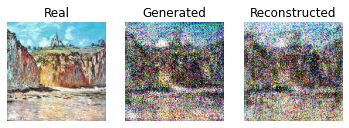

[INFO] Domain B to Domain A


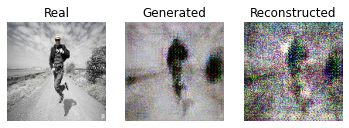

 13%|█▎        | 252/2000 [10:20<1:10:04,  2.41s/it]

dA_loss: 0.318 dB_loss: 0.138 gAB_loss :4.969 gBA_loss: 4.777


 13%|█▎        | 253/2000 [10:22<1:08:42,  2.36s/it]

dA_loss: 0.256 dB_loss: 0.138 gAB_loss :5.060 gBA_loss: 4.706


 13%|█▎        | 254/2000 [10:25<1:07:40,  2.33s/it]

dA_loss: 0.233 dB_loss: 0.133 gAB_loss :4.933 gBA_loss: 4.807


 13%|█▎        | 255/2000 [10:27<1:07:02,  2.31s/it]

dA_loss: 0.260 dB_loss: 0.144 gAB_loss :4.962 gBA_loss: 4.914


 13%|█▎        | 256/2000 [10:29<1:06:37,  2.29s/it]

dA_loss: 0.201 dB_loss: 0.125 gAB_loss :4.898 gBA_loss: 4.792


 13%|█▎        | 257/2000 [10:31<1:06:18,  2.28s/it]

dA_loss: 0.303 dB_loss: 0.169 gAB_loss :5.017 gBA_loss: 4.825


 13%|█▎        | 258/2000 [10:34<1:06:15,  2.28s/it]

dA_loss: 0.291 dB_loss: 0.147 gAB_loss :4.929 gBA_loss: 4.703


 13%|█▎        | 259/2000 [10:36<1:06:16,  2.28s/it]

dA_loss: 0.278 dB_loss: 0.149 gAB_loss :4.927 gBA_loss: 4.658


 13%|█▎        | 260/2000 [10:38<1:06:06,  2.28s/it]

dA_loss: 0.300 dB_loss: 0.128 gAB_loss :4.979 gBA_loss: 4.717


 13%|█▎        | 261/2000 [10:40<1:05:55,  2.27s/it]

dA_loss: 0.209 dB_loss: 0.106 gAB_loss :4.991 gBA_loss: 4.812


 13%|█▎        | 262/2000 [10:43<1:05:43,  2.27s/it]

dA_loss: 0.274 dB_loss: 0.107 gAB_loss :5.110 gBA_loss: 4.734


 13%|█▎        | 263/2000 [10:45<1:05:35,  2.27s/it]

dA_loss: 0.291 dB_loss: 0.207 gAB_loss :5.176 gBA_loss: 4.992


 13%|█▎        | 264/2000 [10:47<1:05:30,  2.26s/it]

dA_loss: 0.215 dB_loss: 0.320 gAB_loss :5.173 gBA_loss: 4.648


 13%|█▎        | 265/2000 [10:50<1:05:43,  2.27s/it]

dA_loss: 0.354 dB_loss: 0.201 gAB_loss :5.214 gBA_loss: 4.768


 13%|█▎        | 266/2000 [10:52<1:05:49,  2.28s/it]

dA_loss: 0.279 dB_loss: 0.134 gAB_loss :5.071 gBA_loss: 5.079


 13%|█▎        | 267/2000 [10:54<1:05:49,  2.28s/it]

dA_loss: 0.199 dB_loss: 0.137 gAB_loss :5.190 gBA_loss: 4.723


 13%|█▎        | 268/2000 [10:56<1:05:45,  2.28s/it]

dA_loss: 0.342 dB_loss: 0.138 gAB_loss :5.000 gBA_loss: 4.853


 13%|█▎        | 269/2000 [10:59<1:05:42,  2.28s/it]

dA_loss: 0.254 dB_loss: 0.139 gAB_loss :5.085 gBA_loss: 4.842


 14%|█▎        | 270/2000 [11:01<1:05:45,  2.28s/it]

dA_loss: 0.268 dB_loss: 0.103 gAB_loss :4.990 gBA_loss: 4.801


 14%|█▎        | 271/2000 [11:03<1:05:32,  2.27s/it]

dA_loss: 0.161 dB_loss: 0.237 gAB_loss :5.180 gBA_loss: 4.814


 14%|█▎        | 272/2000 [11:05<1:05:29,  2.27s/it]

dA_loss: 0.304 dB_loss: 0.175 gAB_loss :4.873 gBA_loss: 4.893


 14%|█▎        | 273/2000 [11:08<1:05:23,  2.27s/it]

dA_loss: 0.314 dB_loss: 0.194 gAB_loss :4.856 gBA_loss: 4.675


 14%|█▎        | 274/2000 [11:10<1:05:15,  2.27s/it]

dA_loss: 0.260 dB_loss: 0.145 gAB_loss :4.852 gBA_loss: 4.641


 14%|█▍        | 275/2000 [11:12<1:05:04,  2.26s/it]

dA_loss: 0.263 dB_loss: 0.134 gAB_loss :4.816 gBA_loss: 4.714


 14%|█▍        | 276/2000 [11:14<1:05:01,  2.26s/it]

dA_loss: 0.250 dB_loss: 0.144 gAB_loss :4.871 gBA_loss: 4.725


 14%|█▍        | 277/2000 [11:17<1:04:59,  2.26s/it]

dA_loss: 0.214 dB_loss: 0.141 gAB_loss :5.045 gBA_loss: 4.761


 14%|█▍        | 278/2000 [11:19<1:05:04,  2.27s/it]

dA_loss: 0.261 dB_loss: 0.214 gAB_loss :4.896 gBA_loss: 4.888


 14%|█▍        | 279/2000 [11:21<1:04:53,  2.26s/it]

dA_loss: 0.198 dB_loss: 0.351 gAB_loss :5.205 gBA_loss: 4.824


 14%|█▍        | 280/2000 [11:24<1:04:50,  2.26s/it]

dA_loss: 0.352 dB_loss: 0.247 gAB_loss :5.128 gBA_loss: 4.803


 14%|█▍        | 281/2000 [11:26<1:04:55,  2.27s/it]

dA_loss: 0.233 dB_loss: 0.175 gAB_loss :5.079 gBA_loss: 4.994


 14%|█▍        | 282/2000 [11:28<1:04:53,  2.27s/it]

dA_loss: 0.241 dB_loss: 0.120 gAB_loss :4.897 gBA_loss: 4.656


 14%|█▍        | 283/2000 [11:30<1:04:43,  2.26s/it]

dA_loss: 0.255 dB_loss: 0.122 gAB_loss :5.072 gBA_loss: 4.865


 14%|█▍        | 284/2000 [11:33<1:04:45,  2.26s/it]

dA_loss: 0.230 dB_loss: 0.123 gAB_loss :4.997 gBA_loss: 4.867


 14%|█▍        | 285/2000 [11:35<1:04:43,  2.26s/it]

dA_loss: 0.227 dB_loss: 0.159 gAB_loss :4.955 gBA_loss: 4.951


 14%|█▍        | 286/2000 [11:37<1:04:51,  2.27s/it]

dA_loss: 0.203 dB_loss: 0.125 gAB_loss :5.240 gBA_loss: 4.822


 14%|█▍        | 287/2000 [11:39<1:04:53,  2.27s/it]

dA_loss: 0.221 dB_loss: 0.111 gAB_loss :4.912 gBA_loss: 4.934


 14%|█▍        | 288/2000 [11:42<1:04:59,  2.28s/it]

dA_loss: 0.204 dB_loss: 0.144 gAB_loss :5.160 gBA_loss: 4.848


 14%|█▍        | 289/2000 [11:44<1:05:04,  2.28s/it]

dA_loss: 0.259 dB_loss: 0.131 gAB_loss :4.870 gBA_loss: 4.703


 14%|█▍        | 290/2000 [11:46<1:04:49,  2.27s/it]

dA_loss: 0.255 dB_loss: 0.131 gAB_loss :5.017 gBA_loss: 4.870


 15%|█▍        | 291/2000 [11:49<1:04:45,  2.27s/it]

dA_loss: 0.257 dB_loss: 0.140 gAB_loss :5.046 gBA_loss: 4.529


 15%|█▍        | 292/2000 [11:51<1:04:35,  2.27s/it]

dA_loss: 0.262 dB_loss: 0.164 gAB_loss :5.014 gBA_loss: 4.730


 15%|█▍        | 293/2000 [11:53<1:04:40,  2.27s/it]

dA_loss: 0.196 dB_loss: 0.300 gAB_loss :5.227 gBA_loss: 4.759


 15%|█▍        | 294/2000 [11:55<1:04:44,  2.28s/it]

dA_loss: 0.147 dB_loss: 0.235 gAB_loss :5.174 gBA_loss: 4.886


 15%|█▍        | 295/2000 [11:58<1:04:32,  2.27s/it]

dA_loss: 0.214 dB_loss: 0.188 gAB_loss :5.059 gBA_loss: 4.891


 15%|█▍        | 296/2000 [12:00<1:04:29,  2.27s/it]

dA_loss: 0.233 dB_loss: 0.144 gAB_loss :5.026 gBA_loss: 4.655


 15%|█▍        | 297/2000 [12:02<1:04:31,  2.27s/it]

dA_loss: 0.267 dB_loss: 0.134 gAB_loss :5.152 gBA_loss: 4.791


 15%|█▍        | 298/2000 [12:04<1:04:27,  2.27s/it]

dA_loss: 0.229 dB_loss: 0.142 gAB_loss :5.020 gBA_loss: 4.723


 15%|█▍        | 299/2000 [12:07<1:04:25,  2.27s/it]

dA_loss: 0.257 dB_loss: 0.162 gAB_loss :5.195 gBA_loss: 4.780


 15%|█▌        | 300/2000 [12:09<1:04:21,  2.27s/it]

dA_loss: 0.273 dB_loss: 0.115 gAB_loss :5.081 gBA_loss: 4.654
dA_loss: 0.359 dB_loss: 0.107 gAB_loss :5.011 gBA_loss: 5.029
[INFO] Domain A to Domain B


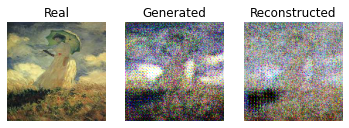

[INFO] Domain B to Domain A


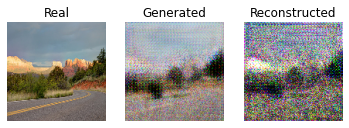

 15%|█▌        | 302/2000 [12:14<1:06:29,  2.35s/it]

dA_loss: 0.356 dB_loss: 0.106 gAB_loss :5.176 gBA_loss: 4.736


 15%|█▌        | 303/2000 [12:16<1:05:49,  2.33s/it]

dA_loss: 0.474 dB_loss: 0.108 gAB_loss :4.960 gBA_loss: 4.828


 15%|█▌        | 304/2000 [12:18<1:05:09,  2.31s/it]

dA_loss: 0.355 dB_loss: 0.139 gAB_loss :4.864 gBA_loss: 4.933


 15%|█▌        | 305/2000 [12:21<1:04:44,  2.29s/it]

dA_loss: 0.265 dB_loss: 0.156 gAB_loss :4.809 gBA_loss: 4.789


 15%|█▌        | 306/2000 [12:23<1:04:18,  2.28s/it]

dA_loss: 0.272 dB_loss: 0.132 gAB_loss :4.715 gBA_loss: 4.895


 15%|█▌        | 307/2000 [12:25<1:04:03,  2.27s/it]

dA_loss: 0.205 dB_loss: 0.118 gAB_loss :4.764 gBA_loss: 4.685


 15%|█▌        | 308/2000 [12:27<1:03:54,  2.27s/it]

dA_loss: 0.262 dB_loss: 0.084 gAB_loss :4.802 gBA_loss: 4.836


 15%|█▌        | 309/2000 [12:30<1:03:48,  2.26s/it]

dA_loss: 0.189 dB_loss: 0.077 gAB_loss :4.994 gBA_loss: 4.687


 16%|█▌        | 310/2000 [12:32<1:03:49,  2.27s/it]

dA_loss: 0.257 dB_loss: 0.091 gAB_loss :5.257 gBA_loss: 4.974


 16%|█▌        | 311/2000 [12:34<1:03:39,  2.26s/it]

dA_loss: 0.168 dB_loss: 0.133 gAB_loss :5.020 gBA_loss: 4.787


 16%|█▌        | 312/2000 [12:37<1:03:44,  2.27s/it]

dA_loss: 0.200 dB_loss: 0.250 gAB_loss :5.167 gBA_loss: 4.899


 16%|█▌        | 313/2000 [12:39<1:04:01,  2.28s/it]

dA_loss: 0.139 dB_loss: 0.203 gAB_loss :4.996 gBA_loss: 4.674


 16%|█▌        | 314/2000 [12:41<1:04:24,  2.29s/it]

dA_loss: 0.240 dB_loss: 0.131 gAB_loss :4.900 gBA_loss: 4.955


 16%|█▌        | 315/2000 [12:43<1:04:06,  2.28s/it]

dA_loss: 0.194 dB_loss: 0.129 gAB_loss :5.114 gBA_loss: 4.816


 16%|█▌        | 316/2000 [12:46<1:03:49,  2.27s/it]

dA_loss: 0.271 dB_loss: 0.106 gAB_loss :4.978 gBA_loss: 4.781


 16%|█▌        | 317/2000 [12:48<1:03:47,  2.27s/it]

dA_loss: 0.194 dB_loss: 0.124 gAB_loss :5.184 gBA_loss: 4.927


 16%|█▌        | 318/2000 [12:50<1:03:34,  2.27s/it]

dA_loss: 0.196 dB_loss: 0.150 gAB_loss :4.848 gBA_loss: 4.623


 16%|█▌        | 319/2000 [12:52<1:03:27,  2.26s/it]

dA_loss: 0.299 dB_loss: 0.238 gAB_loss :5.007 gBA_loss: 4.711


 16%|█▌        | 320/2000 [12:55<1:03:29,  2.27s/it]

dA_loss: 0.242 dB_loss: 0.178 gAB_loss :4.867 gBA_loss: 4.886


 16%|█▌        | 321/2000 [12:57<1:03:20,  2.26s/it]

dA_loss: 0.224 dB_loss: 0.174 gAB_loss :4.804 gBA_loss: 4.617


 16%|█▌        | 322/2000 [12:59<1:03:21,  2.27s/it]

dA_loss: 0.376 dB_loss: 0.146 gAB_loss :4.774 gBA_loss: 4.680


 16%|█▌        | 323/2000 [13:02<1:03:20,  2.27s/it]

dA_loss: 0.249 dB_loss: 0.162 gAB_loss :4.908 gBA_loss: 4.776


 16%|█▌        | 324/2000 [13:04<1:03:19,  2.27s/it]

dA_loss: 0.200 dB_loss: 0.165 gAB_loss :4.861 gBA_loss: 4.483


 16%|█▋        | 325/2000 [13:06<1:03:08,  2.26s/it]

dA_loss: 0.301 dB_loss: 0.172 gAB_loss :4.852 gBA_loss: 4.790


 16%|█▋        | 326/2000 [13:08<1:03:06,  2.26s/it]

dA_loss: 0.163 dB_loss: 0.179 gAB_loss :5.179 gBA_loss: 4.853


 16%|█▋        | 327/2000 [13:11<1:03:08,  2.26s/it]

dA_loss: 0.138 dB_loss: 0.194 gAB_loss :4.894 gBA_loss: 4.859


 16%|█▋        | 328/2000 [13:13<1:03:12,  2.27s/it]

dA_loss: 0.119 dB_loss: 0.299 gAB_loss :5.448 gBA_loss: 5.094


 16%|█▋        | 329/2000 [13:15<1:03:05,  2.27s/it]

dA_loss: 0.152 dB_loss: 0.347 gAB_loss :4.998 gBA_loss: 4.948


 16%|█▋        | 330/2000 [13:17<1:03:01,  2.26s/it]

dA_loss: 0.179 dB_loss: 0.343 gAB_loss :5.325 gBA_loss: 4.889


 17%|█▋        | 331/2000 [13:20<1:02:57,  2.26s/it]

dA_loss: 0.189 dB_loss: 0.583 gAB_loss :4.625 gBA_loss: 4.632


 17%|█▋        | 332/2000 [13:22<1:02:50,  2.26s/it]

dA_loss: 0.188 dB_loss: 0.515 gAB_loss :6.281 gBA_loss: 4.727


 17%|█▋        | 333/2000 [13:24<1:02:52,  2.26s/it]

dA_loss: 0.190 dB_loss: 1.685 gAB_loss :4.644 gBA_loss: 4.646


 17%|█▋        | 334/2000 [13:26<1:02:43,  2.26s/it]

dA_loss: 0.150 dB_loss: 1.110 gAB_loss :6.446 gBA_loss: 4.957


 17%|█▋        | 335/2000 [13:29<1:02:41,  2.26s/it]

dA_loss: 0.144 dB_loss: 1.860 gAB_loss :5.580 gBA_loss: 5.085


 17%|█▋        | 336/2000 [13:31<1:02:36,  2.26s/it]

dA_loss: 0.263 dB_loss: 2.072 gAB_loss :7.030 gBA_loss: 5.077


 17%|█▋        | 337/2000 [13:33<1:02:30,  2.26s/it]

dA_loss: 0.255 dB_loss: 2.731 gAB_loss :6.773 gBA_loss: 5.062


 17%|█▋        | 338/2000 [13:35<1:02:30,  2.26s/it]

dA_loss: 0.238 dB_loss: 3.872 gAB_loss :5.873 gBA_loss: 4.850


 17%|█▋        | 339/2000 [13:38<1:02:23,  2.25s/it]

dA_loss: 0.234 dB_loss: 2.143 gAB_loss :7.714 gBA_loss: 5.169


 17%|█▋        | 340/2000 [13:40<1:02:27,  2.26s/it]

dA_loss: 0.224 dB_loss: 4.767 gAB_loss :8.427 gBA_loss: 4.939


 17%|█▋        | 341/2000 [13:42<1:02:28,  2.26s/it]

dA_loss: 0.205 dB_loss: 6.280 gAB_loss :6.596 gBA_loss: 5.054


 17%|█▋        | 342/2000 [13:44<1:02:38,  2.27s/it]

dA_loss: 0.162 dB_loss: 3.121 gAB_loss :10.845 gBA_loss: 6.007


 17%|█▋        | 343/2000 [13:47<1:02:32,  2.26s/it]

dA_loss: 0.113 dB_loss: 10.728 gAB_loss :8.062 gBA_loss: 5.136


 17%|█▋        | 344/2000 [13:49<1:02:48,  2.28s/it]

dA_loss: 0.245 dB_loss: 3.523 gAB_loss :8.611 gBA_loss: 6.172


 17%|█▋        | 345/2000 [13:51<1:02:37,  2.27s/it]

dA_loss: 0.257 dB_loss: 6.454 gAB_loss :6.971 gBA_loss: 5.138


 17%|█▋        | 346/2000 [13:54<1:02:32,  2.27s/it]

dA_loss: 0.356 dB_loss: 2.057 gAB_loss :7.068 gBA_loss: 4.851


 17%|█▋        | 347/2000 [13:56<1:02:25,  2.27s/it]

dA_loss: 0.315 dB_loss: 1.374 gAB_loss :5.631 gBA_loss: 4.854


 17%|█▋        | 348/2000 [13:58<1:02:14,  2.26s/it]

dA_loss: 0.279 dB_loss: 0.923 gAB_loss :5.112 gBA_loss: 4.641


 17%|█▋        | 349/2000 [14:00<1:02:11,  2.26s/it]

dA_loss: 0.257 dB_loss: 0.469 gAB_loss :5.005 gBA_loss: 4.499


 18%|█▊        | 350/2000 [14:03<1:02:12,  2.26s/it]

dA_loss: 0.219 dB_loss: 0.467 gAB_loss :4.886 gBA_loss: 4.497
dA_loss: 0.188 dB_loss: 0.391 gAB_loss :4.774 gBA_loss: 4.542
[INFO] Domain A to Domain B


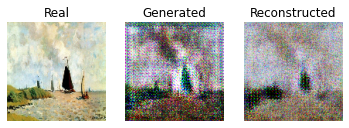

[INFO] Domain B to Domain A


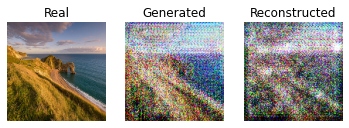

 18%|█▊        | 352/2000 [14:07<1:04:08,  2.34s/it]

dA_loss: 0.165 dB_loss: 0.358 gAB_loss :4.733 gBA_loss: 4.628


 18%|█▊        | 353/2000 [14:10<1:03:36,  2.32s/it]

dA_loss: 0.169 dB_loss: 0.346 gAB_loss :4.631 gBA_loss: 4.603


 18%|█▊        | 354/2000 [14:12<1:03:04,  2.30s/it]

dA_loss: 0.147 dB_loss: 0.337 gAB_loss :4.643 gBA_loss: 4.619


 18%|█▊        | 355/2000 [14:14<1:02:48,  2.29s/it]

dA_loss: 0.139 dB_loss: 0.323 gAB_loss :4.577 gBA_loss: 4.752


 18%|█▊        | 356/2000 [14:17<1:02:32,  2.28s/it]

dA_loss: 0.127 dB_loss: 0.328 gAB_loss :4.631 gBA_loss: 4.688


 18%|█▊        | 357/2000 [14:19<1:02:28,  2.28s/it]

dA_loss: 0.214 dB_loss: 0.281 gAB_loss :4.699 gBA_loss: 5.226


 18%|█▊        | 358/2000 [14:21<1:02:14,  2.27s/it]

dA_loss: 0.294 dB_loss: 0.313 gAB_loss :4.643 gBA_loss: 4.542


 18%|█▊        | 359/2000 [14:23<1:02:09,  2.27s/it]

dA_loss: 0.486 dB_loss: 0.292 gAB_loss :4.519 gBA_loss: 4.657


 18%|█▊        | 360/2000 [14:26<1:02:00,  2.27s/it]

dA_loss: 0.407 dB_loss: 0.308 gAB_loss :4.524 gBA_loss: 4.566


 18%|█▊        | 361/2000 [14:28<1:01:46,  2.26s/it]

dA_loss: 0.338 dB_loss: 0.290 gAB_loss :4.478 gBA_loss: 4.478


 18%|█▊        | 362/2000 [14:30<1:01:34,  2.26s/it]

dA_loss: 0.258 dB_loss: 0.300 gAB_loss :4.445 gBA_loss: 4.394


 18%|█▊        | 363/2000 [14:32<1:01:41,  2.26s/it]

dA_loss: 0.219 dB_loss: 0.265 gAB_loss :4.471 gBA_loss: 4.497


 18%|█▊        | 364/2000 [14:35<1:01:28,  2.25s/it]

dA_loss: 0.130 dB_loss: 0.287 gAB_loss :4.455 gBA_loss: 4.546


 18%|█▊        | 365/2000 [14:37<1:01:30,  2.26s/it]

dA_loss: 0.208 dB_loss: 0.245 gAB_loss :4.502 gBA_loss: 4.856


 18%|█▊        | 366/2000 [14:39<1:01:21,  2.25s/it]

dA_loss: 0.224 dB_loss: 0.280 gAB_loss :4.435 gBA_loss: 4.465


 18%|█▊        | 367/2000 [14:41<1:01:22,  2.26s/it]

dA_loss: 0.372 dB_loss: 0.275 gAB_loss :4.418 gBA_loss: 4.580


 18%|█▊        | 368/2000 [14:44<1:01:29,  2.26s/it]

dA_loss: 0.221 dB_loss: 0.262 gAB_loss :4.398 gBA_loss: 4.677


 18%|█▊        | 369/2000 [14:46<1:01:25,  2.26s/it]

dA_loss: 0.174 dB_loss: 0.260 gAB_loss :4.448 gBA_loss: 4.520


 18%|█▊        | 370/2000 [14:48<1:01:23,  2.26s/it]

dA_loss: 0.173 dB_loss: 0.229 gAB_loss :4.395 gBA_loss: 4.646


 19%|█▊        | 371/2000 [14:50<1:01:19,  2.26s/it]

dA_loss: 0.171 dB_loss: 0.256 gAB_loss :4.461 gBA_loss: 4.573


 19%|█▊        | 372/2000 [14:53<1:01:16,  2.26s/it]

dA_loss: 0.154 dB_loss: 0.220 gAB_loss :4.413 gBA_loss: 4.575


 19%|█▊        | 373/2000 [14:55<1:01:29,  2.27s/it]

dA_loss: 0.184 dB_loss: 0.240 gAB_loss :4.486 gBA_loss: 4.646


 19%|█▊        | 374/2000 [14:57<1:01:17,  2.26s/it]

dA_loss: 0.167 dB_loss: 0.201 gAB_loss :4.453 gBA_loss: 4.410


 19%|█▉        | 375/2000 [14:59<1:01:11,  2.26s/it]

dA_loss: 0.221 dB_loss: 0.259 gAB_loss :4.388 gBA_loss: 4.616


 19%|█▉        | 376/2000 [15:02<1:00:58,  2.25s/it]

dA_loss: 0.178 dB_loss: 0.233 gAB_loss :4.446 gBA_loss: 4.510


 19%|█▉        | 377/2000 [15:04<1:00:57,  2.25s/it]

dA_loss: 0.182 dB_loss: 0.232 gAB_loss :4.359 gBA_loss: 4.694


 19%|█▉        | 378/2000 [15:06<1:01:05,  2.26s/it]

dA_loss: 0.131 dB_loss: 0.233 gAB_loss :4.379 gBA_loss: 4.980


 19%|█▉        | 379/2000 [15:09<1:01:08,  2.26s/it]

dA_loss: 0.145 dB_loss: 0.231 gAB_loss :4.386 gBA_loss: 4.545


 19%|█▉        | 380/2000 [15:11<1:01:05,  2.26s/it]

dA_loss: 0.307 dB_loss: 0.183 gAB_loss :4.450 gBA_loss: 4.795


 19%|█▉        | 381/2000 [15:13<1:01:04,  2.26s/it]

dA_loss: 0.191 dB_loss: 0.198 gAB_loss :4.471 gBA_loss: 4.660


 19%|█▉        | 382/2000 [15:15<1:01:02,  2.26s/it]

dA_loss: 0.146 dB_loss: 0.164 gAB_loss :4.526 gBA_loss: 4.634


 19%|█▉        | 383/2000 [15:18<1:01:02,  2.26s/it]

dA_loss: 0.118 dB_loss: 0.216 gAB_loss :4.450 gBA_loss: 4.658


 19%|█▉        | 384/2000 [15:20<1:01:00,  2.27s/it]

dA_loss: 0.115 dB_loss: 0.217 gAB_loss :4.420 gBA_loss: 4.635


 19%|█▉        | 385/2000 [15:22<1:00:50,  2.26s/it]

dA_loss: 0.186 dB_loss: 0.224 gAB_loss :4.470 gBA_loss: 4.979


 19%|█▉        | 386/2000 [15:24<1:00:45,  2.26s/it]

dA_loss: 0.221 dB_loss: 0.177 gAB_loss :4.428 gBA_loss: 4.554


 19%|█▉        | 387/2000 [15:27<1:00:45,  2.26s/it]

dA_loss: 0.400 dB_loss: 0.197 gAB_loss :4.410 gBA_loss: 4.541


 19%|█▉        | 388/2000 [15:29<1:00:39,  2.26s/it]

dA_loss: 0.302 dB_loss: 0.172 gAB_loss :4.460 gBA_loss: 4.690


 19%|█▉        | 389/2000 [15:31<1:00:27,  2.25s/it]

dA_loss: 0.236 dB_loss: 0.169 gAB_loss :4.422 gBA_loss: 4.503


 20%|█▉        | 390/2000 [15:33<1:00:25,  2.25s/it]

dA_loss: 0.232 dB_loss: 0.173 gAB_loss :4.459 gBA_loss: 4.537


 20%|█▉        | 391/2000 [15:36<1:00:22,  2.25s/it]

dA_loss: 0.228 dB_loss: 0.195 gAB_loss :4.388 gBA_loss: 4.434


 20%|█▉        | 392/2000 [15:38<1:00:19,  2.25s/it]

dA_loss: 0.265 dB_loss: 0.201 gAB_loss :4.384 gBA_loss: 4.625


 20%|█▉        | 393/2000 [15:40<1:00:14,  2.25s/it]

dA_loss: 0.257 dB_loss: 0.198 gAB_loss :4.343 gBA_loss: 4.602


 20%|█▉        | 394/2000 [15:42<1:00:19,  2.25s/it]

dA_loss: 0.272 dB_loss: 0.181 gAB_loss :4.340 gBA_loss: 4.570


 20%|█▉        | 395/2000 [15:45<1:00:23,  2.26s/it]

dA_loss: 0.225 dB_loss: 0.158 gAB_loss :4.442 gBA_loss: 4.774


 20%|█▉        | 396/2000 [15:47<1:00:22,  2.26s/it]

dA_loss: 0.190 dB_loss: 0.135 gAB_loss :4.447 gBA_loss: 4.478


 20%|█▉        | 397/2000 [15:49<1:00:42,  2.27s/it]

dA_loss: 0.370 dB_loss: 0.165 gAB_loss :4.480 gBA_loss: 4.715


 20%|█▉        | 398/2000 [15:51<1:00:35,  2.27s/it]

dA_loss: 0.213 dB_loss: 0.153 gAB_loss :4.493 gBA_loss: 4.655


 20%|█▉        | 399/2000 [15:54<1:00:35,  2.27s/it]

dA_loss: 0.146 dB_loss: 0.168 gAB_loss :4.442 gBA_loss: 4.503


 20%|██        | 400/2000 [15:56<1:00:27,  2.27s/it]

dA_loss: 0.164 dB_loss: 0.158 gAB_loss :4.393 gBA_loss: 4.729
dA_loss: 0.161 dB_loss: 0.173 gAB_loss :4.425 gBA_loss: 4.479
[INFO] Domain A to Domain B


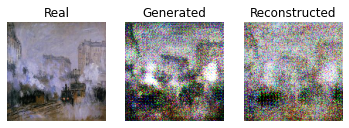

[INFO] Domain B to Domain A


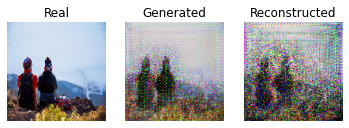

 20%|██        | 402/2000 [16:01<1:02:28,  2.35s/it]

dA_loss: 0.242 dB_loss: 0.146 gAB_loss :4.412 gBA_loss: 4.702


 20%|██        | 403/2000 [16:03<1:01:39,  2.32s/it]

dA_loss: 0.172 dB_loss: 0.149 gAB_loss :4.444 gBA_loss: 4.630


 20%|██        | 404/2000 [16:05<1:01:10,  2.30s/it]

dA_loss: 0.121 dB_loss: 0.130 gAB_loss :4.478 gBA_loss: 4.799


 20%|██        | 405/2000 [16:08<1:00:51,  2.29s/it]

dA_loss: 0.114 dB_loss: 0.138 gAB_loss :4.518 gBA_loss: 4.577


 20%|██        | 406/2000 [16:10<1:00:25,  2.27s/it]

dA_loss: 0.197 dB_loss: 0.130 gAB_loss :4.482 gBA_loss: 4.845


 20%|██        | 407/2000 [16:12<1:00:16,  2.27s/it]

dA_loss: 0.199 dB_loss: 0.117 gAB_loss :4.565 gBA_loss: 4.388


 20%|██        | 408/2000 [16:14<1:00:09,  2.27s/it]

dA_loss: 0.282 dB_loss: 0.114 gAB_loss :4.575 gBA_loss: 4.455


 20%|██        | 409/2000 [16:17<59:55,  2.26s/it]  

dA_loss: 0.242 dB_loss: 0.145 gAB_loss :4.509 gBA_loss: 4.486


 20%|██        | 410/2000 [16:19<1:00:08,  2.27s/it]

dA_loss: 0.202 dB_loss: 0.156 gAB_loss :4.431 gBA_loss: 4.409


 21%|██        | 411/2000 [16:21<1:00:07,  2.27s/it]

dA_loss: 0.160 dB_loss: 0.155 gAB_loss :4.337 gBA_loss: 4.330


 21%|██        | 412/2000 [16:23<1:00:02,  2.27s/it]

dA_loss: 0.149 dB_loss: 0.148 gAB_loss :4.421 gBA_loss: 4.661


 21%|██        | 413/2000 [16:26<59:51,  2.26s/it]  

dA_loss: 0.185 dB_loss: 0.114 gAB_loss :4.463 gBA_loss: 4.597


 21%|██        | 414/2000 [16:28<59:41,  2.26s/it]

dA_loss: 0.467 dB_loss: 0.122 gAB_loss :4.548 gBA_loss: 4.690


 21%|██        | 415/2000 [16:30<59:33,  2.25s/it]

dA_loss: 0.302 dB_loss: 0.099 gAB_loss :4.589 gBA_loss: 4.867


 21%|██        | 416/2000 [16:33<59:43,  2.26s/it]

dA_loss: 0.171 dB_loss: 0.118 gAB_loss :4.614 gBA_loss: 4.508


 21%|██        | 417/2000 [16:35<59:33,  2.26s/it]

dA_loss: 0.177 dB_loss: 0.131 gAB_loss :4.509 gBA_loss: 4.703


 21%|██        | 418/2000 [16:37<59:28,  2.26s/it]

dA_loss: 0.151 dB_loss: 0.129 gAB_loss :4.441 gBA_loss: 4.418


 21%|██        | 419/2000 [16:39<59:23,  2.25s/it]

dA_loss: 0.223 dB_loss: 0.104 gAB_loss :4.470 gBA_loss: 4.723


 21%|██        | 420/2000 [16:42<59:25,  2.26s/it]

dA_loss: 0.187 dB_loss: 0.105 gAB_loss :4.536 gBA_loss: 4.474


 21%|██        | 421/2000 [16:44<59:14,  2.25s/it]

dA_loss: 0.144 dB_loss: 0.128 gAB_loss :4.509 gBA_loss: 4.576


 21%|██        | 422/2000 [16:46<59:10,  2.25s/it]

dA_loss: 0.133 dB_loss: 0.131 gAB_loss :4.448 gBA_loss: 4.558


 21%|██        | 423/2000 [16:48<59:10,  2.25s/it]

dA_loss: 0.124 dB_loss: 0.126 gAB_loss :4.437 gBA_loss: 4.704


 21%|██        | 424/2000 [16:51<59:10,  2.25s/it]

dA_loss: 0.123 dB_loss: 0.108 gAB_loss :4.579 gBA_loss: 4.591


 21%|██▏       | 425/2000 [16:53<59:08,  2.25s/it]

dA_loss: 0.135 dB_loss: 0.094 gAB_loss :4.608 gBA_loss: 4.688


 21%|██▏       | 426/2000 [16:55<59:14,  2.26s/it]

dA_loss: 0.109 dB_loss: 0.086 gAB_loss :4.627 gBA_loss: 4.748


 21%|██▏       | 427/2000 [16:57<59:08,  2.26s/it]

dA_loss: 0.095 dB_loss: 0.097 gAB_loss :4.660 gBA_loss: 4.613


 21%|██▏       | 428/2000 [17:00<59:00,  2.25s/it]

dA_loss: 0.110 dB_loss: 0.091 gAB_loss :4.593 gBA_loss: 4.833


 21%|██▏       | 429/2000 [17:02<59:03,  2.26s/it]

dA_loss: 0.105 dB_loss: 0.098 gAB_loss :4.598 gBA_loss: 4.945


 22%|██▏       | 430/2000 [17:04<58:55,  2.25s/it]

dA_loss: 0.132 dB_loss: 0.094 gAB_loss :4.577 gBA_loss: 4.529


 22%|██▏       | 431/2000 [17:06<58:58,  2.26s/it]

dA_loss: 0.246 dB_loss: 0.095 gAB_loss :4.543 gBA_loss: 4.639


 22%|██▏       | 432/2000 [17:09<58:56,  2.26s/it]

dA_loss: 0.181 dB_loss: 0.090 gAB_loss :4.572 gBA_loss: 4.765


 22%|██▏       | 433/2000 [17:11<58:58,  2.26s/it]

dA_loss: 0.160 dB_loss: 0.109 gAB_loss :4.540 gBA_loss: 4.367


 22%|██▏       | 434/2000 [17:13<58:55,  2.26s/it]

dA_loss: 0.347 dB_loss: 0.116 gAB_loss :4.575 gBA_loss: 5.015


 22%|██▏       | 435/2000 [17:15<58:58,  2.26s/it]

dA_loss: 0.324 dB_loss: 0.092 gAB_loss :4.497 gBA_loss: 4.604


 22%|██▏       | 436/2000 [17:18<58:50,  2.26s/it]

dA_loss: 0.428 dB_loss: 0.141 gAB_loss :4.624 gBA_loss: 4.843


 22%|██▏       | 437/2000 [17:20<58:44,  2.25s/it]

dA_loss: 0.542 dB_loss: 0.098 gAB_loss :4.605 gBA_loss: 4.293


 22%|██▏       | 438/2000 [17:22<58:43,  2.26s/it]

dA_loss: 0.452 dB_loss: 0.083 gAB_loss :4.583 gBA_loss: 4.884


 22%|██▏       | 439/2000 [17:24<58:37,  2.25s/it]

dA_loss: 0.385 dB_loss: 0.106 gAB_loss :4.640 gBA_loss: 4.337


 22%|██▏       | 440/2000 [17:27<58:33,  2.25s/it]

dA_loss: 0.208 dB_loss: 0.102 gAB_loss :4.472 gBA_loss: 4.437


 22%|██▏       | 441/2000 [17:29<58:32,  2.25s/it]

dA_loss: 0.229 dB_loss: 0.126 gAB_loss :4.447 gBA_loss: 4.199


 22%|██▏       | 442/2000 [17:31<58:29,  2.25s/it]

dA_loss: 0.189 dB_loss: 0.103 gAB_loss :4.444 gBA_loss: 4.315


 22%|██▏       | 443/2000 [17:33<58:29,  2.25s/it]

dA_loss: 0.128 dB_loss: 0.090 gAB_loss :4.520 gBA_loss: 4.342


 22%|██▏       | 444/2000 [17:36<58:24,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.088 gAB_loss :4.624 gBA_loss: 4.519


 22%|██▏       | 445/2000 [17:38<58:27,  2.26s/it]

dA_loss: 0.100 dB_loss: 0.098 gAB_loss :4.652 gBA_loss: 4.858


 22%|██▏       | 446/2000 [17:40<58:26,  2.26s/it]

dA_loss: 0.102 dB_loss: 0.091 gAB_loss :4.610 gBA_loss: 4.538


 22%|██▏       | 447/2000 [17:42<58:31,  2.26s/it]

dA_loss: 0.145 dB_loss: 0.077 gAB_loss :4.497 gBA_loss: 4.735


 22%|██▏       | 448/2000 [17:45<58:30,  2.26s/it]

dA_loss: 0.117 dB_loss: 0.090 gAB_loss :4.557 gBA_loss: 4.532


 22%|██▏       | 449/2000 [17:47<58:20,  2.26s/it]

dA_loss: 0.124 dB_loss: 0.082 gAB_loss :4.528 gBA_loss: 4.573


 22%|██▎       | 450/2000 [17:49<58:35,  2.27s/it]

dA_loss: 0.109 dB_loss: 0.087 gAB_loss :4.606 gBA_loss: 4.533
dA_loss: 0.108 dB_loss: 0.082 gAB_loss :4.567 gBA_loss: 4.571
[INFO] Domain A to Domain B


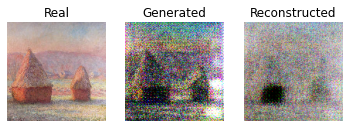

[INFO] Domain B to Domain A


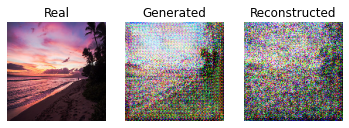

 23%|██▎       | 452/2000 [17:54<1:00:35,  2.35s/it]

dA_loss: 0.096 dB_loss: 0.103 gAB_loss :4.602 gBA_loss: 4.572


 23%|██▎       | 453/2000 [17:56<59:48,  2.32s/it]  

dA_loss: 0.121 dB_loss: 0.095 gAB_loss :4.542 gBA_loss: 4.863


 23%|██▎       | 454/2000 [17:59<59:20,  2.30s/it]

dA_loss: 0.154 dB_loss: 0.078 gAB_loss :4.550 gBA_loss: 4.565


 23%|██▎       | 455/2000 [18:01<58:51,  2.29s/it]

dA_loss: 0.307 dB_loss: 0.084 gAB_loss :4.587 gBA_loss: 4.629


 23%|██▎       | 456/2000 [18:03<58:37,  2.28s/it]

dA_loss: 0.211 dB_loss: 0.073 gAB_loss :4.592 gBA_loss: 4.629


 23%|██▎       | 457/2000 [18:05<58:17,  2.27s/it]

dA_loss: 0.159 dB_loss: 0.113 gAB_loss :4.685 gBA_loss: 4.381


 23%|██▎       | 458/2000 [18:08<58:13,  2.27s/it]

dA_loss: 0.145 dB_loss: 0.104 gAB_loss :4.571 gBA_loss: 4.608


 23%|██▎       | 459/2000 [18:10<58:01,  2.26s/it]

dA_loss: 0.136 dB_loss: 0.119 gAB_loss :4.634 gBA_loss: 4.364


 23%|██▎       | 460/2000 [18:12<57:57,  2.26s/it]

dA_loss: 0.257 dB_loss: 0.089 gAB_loss :4.588 gBA_loss: 4.735


 23%|██▎       | 461/2000 [18:14<57:53,  2.26s/it]

dA_loss: 0.203 dB_loss: 0.085 gAB_loss :4.554 gBA_loss: 4.369


 23%|██▎       | 462/2000 [18:17<57:50,  2.26s/it]

dA_loss: 0.222 dB_loss: 0.090 gAB_loss :4.519 gBA_loss: 4.459


 23%|██▎       | 463/2000 [18:19<57:51,  2.26s/it]

dA_loss: 0.145 dB_loss: 0.084 gAB_loss :4.425 gBA_loss: 4.478


 23%|██▎       | 464/2000 [18:21<57:46,  2.26s/it]

dA_loss: 0.108 dB_loss: 0.101 gAB_loss :4.515 gBA_loss: 4.480


 23%|██▎       | 465/2000 [18:23<57:44,  2.26s/it]

dA_loss: 0.098 dB_loss: 0.082 gAB_loss :4.459 gBA_loss: 4.550


 23%|██▎       | 466/2000 [18:26<57:43,  2.26s/it]

dA_loss: 0.174 dB_loss: 0.095 gAB_loss :4.541 gBA_loss: 5.043


 23%|██▎       | 467/2000 [18:28<57:37,  2.26s/it]

dA_loss: 0.388 dB_loss: 0.083 gAB_loss :4.523 gBA_loss: 4.471


 23%|██▎       | 468/2000 [18:30<57:35,  2.26s/it]

dA_loss: 0.589 dB_loss: 0.074 gAB_loss :4.582 gBA_loss: 4.891


 23%|██▎       | 469/2000 [18:32<57:38,  2.26s/it]

dA_loss: 0.680 dB_loss: 0.060 gAB_loss :4.696 gBA_loss: 4.444


 24%|██▎       | 470/2000 [18:35<57:31,  2.26s/it]

dA_loss: 0.653 dB_loss: 0.059 gAB_loss :4.647 gBA_loss: 4.455


 24%|██▎       | 471/2000 [18:37<57:25,  2.25s/it]

dA_loss: 0.496 dB_loss: 0.065 gAB_loss :4.662 gBA_loss: 4.611


 24%|██▎       | 472/2000 [18:39<57:24,  2.25s/it]

dA_loss: 0.380 dB_loss: 0.070 gAB_loss :4.567 gBA_loss: 4.167


 24%|██▎       | 473/2000 [18:42<57:30,  2.26s/it]

dA_loss: 0.289 dB_loss: 0.078 gAB_loss :4.575 gBA_loss: 4.266


 24%|██▎       | 474/2000 [18:44<57:28,  2.26s/it]

dA_loss: 0.203 dB_loss: 0.080 gAB_loss :4.558 gBA_loss: 4.298


 24%|██▍       | 475/2000 [18:46<57:30,  2.26s/it]

dA_loss: 0.147 dB_loss: 0.075 gAB_loss :4.612 gBA_loss: 4.205


 24%|██▍       | 476/2000 [18:48<57:32,  2.27s/it]

dA_loss: 0.126 dB_loss: 0.066 gAB_loss :4.505 gBA_loss: 4.446


 24%|██▍       | 477/2000 [18:51<57:30,  2.27s/it]

dA_loss: 0.105 dB_loss: 0.094 gAB_loss :4.701 gBA_loss: 4.452


 24%|██▍       | 478/2000 [18:53<57:15,  2.26s/it]

dA_loss: 0.110 dB_loss: 0.081 gAB_loss :4.572 gBA_loss: 4.618


 24%|██▍       | 479/2000 [18:55<57:12,  2.26s/it]

dA_loss: 0.104 dB_loss: 0.120 gAB_loss :4.695 gBA_loss: 4.470


 24%|██▍       | 480/2000 [18:57<57:10,  2.26s/it]

dA_loss: 0.130 dB_loss: 0.110 gAB_loss :4.444 gBA_loss: 4.689


 24%|██▍       | 481/2000 [19:00<57:18,  2.26s/it]

dA_loss: 0.104 dB_loss: 0.116 gAB_loss :4.460 gBA_loss: 4.463


 24%|██▍       | 482/2000 [19:02<57:24,  2.27s/it]

dA_loss: 0.092 dB_loss: 0.080 gAB_loss :4.441 gBA_loss: 4.585


 24%|██▍       | 483/2000 [19:04<57:16,  2.27s/it]

dA_loss: 0.072 dB_loss: 0.068 gAB_loss :4.555 gBA_loss: 4.600


 24%|██▍       | 484/2000 [19:06<57:08,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.065 gAB_loss :4.544 gBA_loss: 4.448


 24%|██▍       | 485/2000 [19:09<57:03,  2.26s/it]

dA_loss: 0.096 dB_loss: 0.064 gAB_loss :4.541 gBA_loss: 4.519


 24%|██▍       | 486/2000 [19:11<57:13,  2.27s/it]

dA_loss: 0.078 dB_loss: 0.098 gAB_loss :4.623 gBA_loss: 4.421


 24%|██▍       | 487/2000 [19:13<57:04,  2.26s/it]

dA_loss: 0.073 dB_loss: 0.100 gAB_loss :4.397 gBA_loss: 4.635


 24%|██▍       | 488/2000 [19:15<57:02,  2.26s/it]

dA_loss: 0.059 dB_loss: 0.203 gAB_loss :4.674 gBA_loss: 4.738


 24%|██▍       | 489/2000 [19:18<57:09,  2.27s/it]

dA_loss: 0.061 dB_loss: 0.136 gAB_loss :4.519 gBA_loss: 4.673


 24%|██▍       | 490/2000 [19:20<56:57,  2.26s/it]

dA_loss: 0.079 dB_loss: 0.101 gAB_loss :4.553 gBA_loss: 4.709


 25%|██▍       | 491/2000 [19:22<56:46,  2.26s/it]

dA_loss: 0.086 dB_loss: 0.088 gAB_loss :4.611 gBA_loss: 4.442


 25%|██▍       | 492/2000 [19:24<56:37,  2.25s/it]

dA_loss: 0.086 dB_loss: 0.075 gAB_loss :4.750 gBA_loss: 4.582


 25%|██▍       | 493/2000 [19:27<56:33,  2.25s/it]

dA_loss: 0.080 dB_loss: 0.059 gAB_loss :4.758 gBA_loss: 4.378


 25%|██▍       | 494/2000 [19:29<56:28,  2.25s/it]

dA_loss: 0.095 dB_loss: 0.067 gAB_loss :4.513 gBA_loss: 4.559


 25%|██▍       | 495/2000 [19:31<56:28,  2.25s/it]

dA_loss: 0.110 dB_loss: 0.096 gAB_loss :4.547 gBA_loss: 4.374


 25%|██▍       | 496/2000 [19:33<56:23,  2.25s/it]

dA_loss: 0.205 dB_loss: 0.094 gAB_loss :4.443 gBA_loss: 4.698


 25%|██▍       | 497/2000 [19:36<56:18,  2.25s/it]

dA_loss: 0.132 dB_loss: 0.079 gAB_loss :4.402 gBA_loss: 4.482


 25%|██▍       | 498/2000 [19:38<56:17,  2.25s/it]

dA_loss: 0.112 dB_loss: 0.071 gAB_loss :4.549 gBA_loss: 4.740


 25%|██▍       | 499/2000 [19:40<56:12,  2.25s/it]

dA_loss: 0.115 dB_loss: 0.086 gAB_loss :4.532 gBA_loss: 4.554


 25%|██▌       | 500/2000 [19:42<56:12,  2.25s/it]

dA_loss: 0.195 dB_loss: 0.116 gAB_loss :4.707 gBA_loss: 4.808
dA_loss: 0.176 dB_loss: 0.094 gAB_loss :4.583 gBA_loss: 4.348
[INFO] Domain A to Domain B


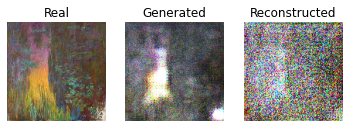

[INFO] Domain B to Domain A


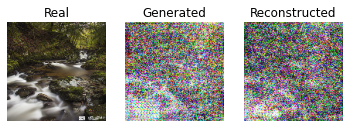

 25%|██▌       | 502/2000 [19:47<58:06,  2.33s/it]

dA_loss: 0.260 dB_loss: 0.080 gAB_loss :4.582 gBA_loss: 4.496


 25%|██▌       | 503/2000 [19:50<57:32,  2.31s/it]

dA_loss: 0.182 dB_loss: 0.093 gAB_loss :4.624 gBA_loss: 4.428


 25%|██▌       | 504/2000 [19:52<57:10,  2.29s/it]

dA_loss: 0.158 dB_loss: 0.105 gAB_loss :4.319 gBA_loss: 4.296


 25%|██▌       | 505/2000 [19:54<57:04,  2.29s/it]

dA_loss: 0.133 dB_loss: 0.126 gAB_loss :4.421 gBA_loss: 4.428


 25%|██▌       | 506/2000 [19:56<56:42,  2.28s/it]

dA_loss: 0.126 dB_loss: 0.090 gAB_loss :4.463 gBA_loss: 4.239


 25%|██▌       | 507/2000 [19:59<56:39,  2.28s/it]

dA_loss: 0.143 dB_loss: 0.061 gAB_loss :4.423 gBA_loss: 4.527


 25%|██▌       | 508/2000 [20:01<56:31,  2.27s/it]

dA_loss: 0.124 dB_loss: 0.068 gAB_loss :4.675 gBA_loss: 4.379


 25%|██▌       | 509/2000 [20:03<56:32,  2.28s/it]

dA_loss: 0.151 dB_loss: 0.074 gAB_loss :4.643 gBA_loss: 4.626


 26%|██▌       | 510/2000 [20:05<56:22,  2.27s/it]

dA_loss: 0.133 dB_loss: 0.083 gAB_loss :4.695 gBA_loss: 4.509


 26%|██▌       | 511/2000 [20:08<56:23,  2.27s/it]

dA_loss: 0.192 dB_loss: 0.069 gAB_loss :4.596 gBA_loss: 4.618


 26%|██▌       | 512/2000 [20:10<56:10,  2.26s/it]

dA_loss: 0.114 dB_loss: 0.065 gAB_loss :4.474 gBA_loss: 4.484


 26%|██▌       | 513/2000 [20:12<55:59,  2.26s/it]

dA_loss: 0.083 dB_loss: 0.069 gAB_loss :4.574 gBA_loss: 4.470


 26%|██▌       | 514/2000 [20:14<56:01,  2.26s/it]

dA_loss: 0.077 dB_loss: 0.071 gAB_loss :4.443 gBA_loss: 4.520


 26%|██▌       | 515/2000 [20:17<56:05,  2.27s/it]

dA_loss: 0.069 dB_loss: 0.086 gAB_loss :4.688 gBA_loss: 4.516


 26%|██▌       | 516/2000 [20:19<56:06,  2.27s/it]

dA_loss: 0.072 dB_loss: 0.072 gAB_loss :4.783 gBA_loss: 4.513


 26%|██▌       | 517/2000 [20:21<55:58,  2.26s/it]

dA_loss: 0.072 dB_loss: 0.077 gAB_loss :4.704 gBA_loss: 4.606


 26%|██▌       | 518/2000 [20:24<55:53,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.086 gAB_loss :4.676 gBA_loss: 4.392


 26%|██▌       | 519/2000 [20:26<55:47,  2.26s/it]

dA_loss: 0.150 dB_loss: 0.076 gAB_loss :4.646 gBA_loss: 4.812


 26%|██▌       | 520/2000 [20:28<55:41,  2.26s/it]

dA_loss: 0.113 dB_loss: 0.061 gAB_loss :4.632 gBA_loss: 4.460


 26%|██▌       | 521/2000 [20:30<55:34,  2.25s/it]

dA_loss: 0.154 dB_loss: 0.063 gAB_loss :4.699 gBA_loss: 4.614


 26%|██▌       | 522/2000 [20:33<55:36,  2.26s/it]

dA_loss: 0.106 dB_loss: 0.066 gAB_loss :4.432 gBA_loss: 4.372


 26%|██▌       | 523/2000 [20:35<55:35,  2.26s/it]

dA_loss: 0.109 dB_loss: 0.121 gAB_loss :4.666 gBA_loss: 4.537


 26%|██▌       | 524/2000 [20:37<55:27,  2.25s/it]

dA_loss: 0.100 dB_loss: 0.114 gAB_loss :4.439 gBA_loss: 4.270


 26%|██▋       | 525/2000 [20:39<55:22,  2.25s/it]

dA_loss: 0.134 dB_loss: 0.111 gAB_loss :4.617 gBA_loss: 4.601


 26%|██▋       | 526/2000 [20:42<55:23,  2.25s/it]

dA_loss: 0.194 dB_loss: 0.107 gAB_loss :4.526 gBA_loss: 4.264


 26%|██▋       | 527/2000 [20:44<55:19,  2.25s/it]

dA_loss: 0.321 dB_loss: 0.122 gAB_loss :4.612 gBA_loss: 4.817


 26%|██▋       | 528/2000 [20:46<55:17,  2.25s/it]

dA_loss: 0.366 dB_loss: 0.132 gAB_loss :4.758 gBA_loss: 4.567


 26%|██▋       | 529/2000 [20:48<55:16,  2.25s/it]

dA_loss: 0.230 dB_loss: 0.104 gAB_loss :4.747 gBA_loss: 4.609


 26%|██▋       | 530/2000 [20:51<55:11,  2.25s/it]

dA_loss: 0.373 dB_loss: 0.089 gAB_loss :4.674 gBA_loss: 3.909


 27%|██▋       | 531/2000 [20:53<55:05,  2.25s/it]

dA_loss: 0.417 dB_loss: 0.070 gAB_loss :4.457 gBA_loss: 4.644


 27%|██▋       | 532/2000 [20:55<55:11,  2.26s/it]

dA_loss: 0.333 dB_loss: 0.074 gAB_loss :4.510 gBA_loss: 4.081


 27%|██▋       | 533/2000 [20:57<55:14,  2.26s/it]

dA_loss: 0.201 dB_loss: 0.081 gAB_loss :4.348 gBA_loss: 4.266


 27%|██▋       | 534/2000 [21:00<55:05,  2.25s/it]

dA_loss: 0.157 dB_loss: 0.076 gAB_loss :4.428 gBA_loss: 4.395


 27%|██▋       | 535/2000 [21:02<55:09,  2.26s/it]

dA_loss: 0.145 dB_loss: 0.064 gAB_loss :4.379 gBA_loss: 4.192


 27%|██▋       | 536/2000 [21:04<55:07,  2.26s/it]

dA_loss: 0.206 dB_loss: 0.059 gAB_loss :4.494 gBA_loss: 4.557


 27%|██▋       | 537/2000 [21:06<55:13,  2.26s/it]

dA_loss: 0.213 dB_loss: 0.048 gAB_loss :4.519 gBA_loss: 4.396


 27%|██▋       | 538/2000 [21:09<55:22,  2.27s/it]

dA_loss: 0.229 dB_loss: 0.081 gAB_loss :4.735 gBA_loss: 4.531


 27%|██▋       | 539/2000 [21:11<55:19,  2.27s/it]

dA_loss: 0.171 dB_loss: 0.111 gAB_loss :4.466 gBA_loss: 4.629


 27%|██▋       | 540/2000 [21:13<55:09,  2.27s/it]

dA_loss: 0.110 dB_loss: 0.165 gAB_loss :4.680 gBA_loss: 4.534


 27%|██▋       | 541/2000 [21:15<54:57,  2.26s/it]

dA_loss: 0.100 dB_loss: 0.113 gAB_loss :4.684 gBA_loss: 4.662


 27%|██▋       | 542/2000 [21:18<54:49,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.095 gAB_loss :4.673 gBA_loss: 4.396


 27%|██▋       | 543/2000 [21:20<54:47,  2.26s/it]

dA_loss: 0.090 dB_loss: 0.080 gAB_loss :4.420 gBA_loss: 4.489


 27%|██▋       | 544/2000 [21:22<54:40,  2.25s/it]

dA_loss: 0.086 dB_loss: 0.082 gAB_loss :4.473 gBA_loss: 4.480


 27%|██▋       | 545/2000 [21:24<54:35,  2.25s/it]

dA_loss: 0.070 dB_loss: 0.072 gAB_loss :4.364 gBA_loss: 4.401


 27%|██▋       | 546/2000 [21:27<54:32,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.067 gAB_loss :4.575 gBA_loss: 4.675


 27%|██▋       | 547/2000 [21:29<54:26,  2.25s/it]

dA_loss: 0.141 dB_loss: 0.076 gAB_loss :4.364 gBA_loss: 4.308


 27%|██▋       | 548/2000 [21:31<54:21,  2.25s/it]

dA_loss: 0.253 dB_loss: 0.169 gAB_loss :4.699 gBA_loss: 4.611


 27%|██▋       | 549/2000 [21:33<54:19,  2.25s/it]

dA_loss: 0.188 dB_loss: 0.146 gAB_loss :4.450 gBA_loss: 4.476


 28%|██▊       | 550/2000 [21:36<54:24,  2.25s/it]

dA_loss: 0.125 dB_loss: 0.124 gAB_loss :4.628 gBA_loss: 4.418
dA_loss: 0.108 dB_loss: 0.088 gAB_loss :4.403 gBA_loss: 4.424
[INFO] Domain A to Domain B


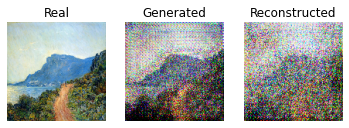

[INFO] Domain B to Domain A


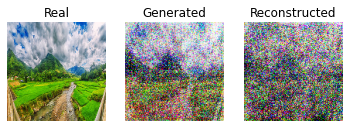

 28%|██▊       | 552/2000 [21:41<56:08,  2.33s/it]

dA_loss: 0.077 dB_loss: 0.092 gAB_loss :4.658 gBA_loss: 4.394


 28%|██▊       | 553/2000 [21:43<55:36,  2.31s/it]

dA_loss: 0.061 dB_loss: 0.085 gAB_loss :4.517 gBA_loss: 4.465


 28%|██▊       | 554/2000 [21:45<55:15,  2.29s/it]

dA_loss: 0.055 dB_loss: 0.085 gAB_loss :4.716 gBA_loss: 4.543


 28%|██▊       | 555/2000 [21:47<54:53,  2.28s/it]

dA_loss: 0.052 dB_loss: 0.076 gAB_loss :4.496 gBA_loss: 4.598


 28%|██▊       | 556/2000 [21:50<54:37,  2.27s/it]

dA_loss: 0.103 dB_loss: 0.094 gAB_loss :4.561 gBA_loss: 5.024


 28%|██▊       | 557/2000 [21:52<54:23,  2.26s/it]

dA_loss: 0.273 dB_loss: 0.093 gAB_loss :4.367 gBA_loss: 4.188


 28%|██▊       | 558/2000 [21:54<54:27,  2.27s/it]

dA_loss: 0.416 dB_loss: 0.084 gAB_loss :4.462 gBA_loss: 4.792


 28%|██▊       | 559/2000 [21:56<54:17,  2.26s/it]

dA_loss: 0.505 dB_loss: 0.063 gAB_loss :4.513 gBA_loss: 4.041


 28%|██▊       | 560/2000 [21:59<54:16,  2.26s/it]

dA_loss: 0.440 dB_loss: 0.060 gAB_loss :4.520 gBA_loss: 4.522


 28%|██▊       | 561/2000 [22:01<54:13,  2.26s/it]

dA_loss: 0.384 dB_loss: 0.085 gAB_loss :4.872 gBA_loss: 4.211


 28%|██▊       | 562/2000 [22:03<54:04,  2.26s/it]

dA_loss: 0.242 dB_loss: 0.115 gAB_loss :4.364 gBA_loss: 4.080


 28%|██▊       | 563/2000 [22:05<54:03,  2.26s/it]

dA_loss: 0.192 dB_loss: 0.222 gAB_loss :4.567 gBA_loss: 4.266


 28%|██▊       | 564/2000 [22:08<54:01,  2.26s/it]

dA_loss: 0.159 dB_loss: 0.157 gAB_loss :4.380 gBA_loss: 4.072


 28%|██▊       | 565/2000 [22:10<53:53,  2.25s/it]

dA_loss: 0.126 dB_loss: 0.097 gAB_loss :4.407 gBA_loss: 4.313


 28%|██▊       | 566/2000 [22:12<53:45,  2.25s/it]

dA_loss: 0.087 dB_loss: 0.080 gAB_loss :4.488 gBA_loss: 4.376


 28%|██▊       | 567/2000 [22:14<53:47,  2.25s/it]

dA_loss: 0.071 dB_loss: 0.063 gAB_loss :4.429 gBA_loss: 4.360


 28%|██▊       | 568/2000 [22:17<53:43,  2.25s/it]

dA_loss: 0.083 dB_loss: 0.075 gAB_loss :4.642 gBA_loss: 4.631


 28%|██▊       | 569/2000 [22:19<53:49,  2.26s/it]

dA_loss: 0.081 dB_loss: 0.087 gAB_loss :4.318 gBA_loss: 4.361


 28%|██▊       | 570/2000 [22:21<53:46,  2.26s/it]

dA_loss: 0.103 dB_loss: 0.178 gAB_loss :4.647 gBA_loss: 4.528


 29%|██▊       | 571/2000 [22:23<53:42,  2.26s/it]

dA_loss: 0.088 dB_loss: 0.123 gAB_loss :4.405 gBA_loss: 4.432


 29%|██▊       | 572/2000 [22:26<53:38,  2.25s/it]

dA_loss: 0.084 dB_loss: 0.107 gAB_loss :4.551 gBA_loss: 4.355


 29%|██▊       | 573/2000 [22:28<53:34,  2.25s/it]

dA_loss: 0.087 dB_loss: 0.076 gAB_loss :4.509 gBA_loss: 4.513


 29%|██▊       | 574/2000 [22:30<53:25,  2.25s/it]

dA_loss: 0.096 dB_loss: 0.064 gAB_loss :4.520 gBA_loss: 4.201


 29%|██▉       | 575/2000 [22:32<53:27,  2.25s/it]

dA_loss: 0.137 dB_loss: 0.069 gAB_loss :4.559 gBA_loss: 4.567


 29%|██▉       | 576/2000 [22:35<53:20,  2.25s/it]

dA_loss: 0.090 dB_loss: 0.069 gAB_loss :4.373 gBA_loss: 4.578


 29%|██▉       | 577/2000 [22:37<53:18,  2.25s/it]

dA_loss: 0.061 dB_loss: 0.092 gAB_loss :4.506 gBA_loss: 4.477


 29%|██▉       | 578/2000 [22:39<53:18,  2.25s/it]

dA_loss: 0.066 dB_loss: 0.079 gAB_loss :4.449 gBA_loss: 4.521


 29%|██▉       | 579/2000 [22:41<53:22,  2.25s/it]

dA_loss: 0.062 dB_loss: 0.064 gAB_loss :4.491 gBA_loss: 4.355


 29%|██▉       | 580/2000 [22:44<53:13,  2.25s/it]

dA_loss: 0.079 dB_loss: 0.066 gAB_loss :4.554 gBA_loss: 4.500


 29%|██▉       | 581/2000 [22:46<53:07,  2.25s/it]

dA_loss: 0.092 dB_loss: 0.073 gAB_loss :4.526 gBA_loss: 4.264


 29%|██▉       | 582/2000 [22:48<53:03,  2.24s/it]

dA_loss: 0.154 dB_loss: 0.109 gAB_loss :4.723 gBA_loss: 4.582


 29%|██▉       | 583/2000 [22:50<52:54,  2.24s/it]

dA_loss: 0.130 dB_loss: 0.139 gAB_loss :4.373 gBA_loss: 4.423


 29%|██▉       | 584/2000 [22:53<52:51,  2.24s/it]

dA_loss: 0.133 dB_loss: 0.202 gAB_loss :4.633 gBA_loss: 4.562


 29%|██▉       | 585/2000 [22:55<52:54,  2.24s/it]

dA_loss: 0.137 dB_loss: 0.128 gAB_loss :4.465 gBA_loss: 4.557


 29%|██▉       | 586/2000 [22:57<52:54,  2.25s/it]

dA_loss: 0.149 dB_loss: 0.052 gAB_loss :4.415 gBA_loss: 4.475


 29%|██▉       | 587/2000 [22:59<52:50,  2.24s/it]

dA_loss: 0.180 dB_loss: 0.048 gAB_loss :4.571 gBA_loss: 4.645


 29%|██▉       | 588/2000 [23:02<52:43,  2.24s/it]

dA_loss: 0.154 dB_loss: 0.055 gAB_loss :4.544 gBA_loss: 4.349


 29%|██▉       | 589/2000 [23:04<52:45,  2.24s/it]

dA_loss: 0.156 dB_loss: 0.094 gAB_loss :4.773 gBA_loss: 4.469


 30%|██▉       | 590/2000 [23:06<52:37,  2.24s/it]

dA_loss: 0.088 dB_loss: 0.101 gAB_loss :4.540 gBA_loss: 4.452


 30%|██▉       | 591/2000 [23:08<52:42,  2.24s/it]

dA_loss: 0.086 dB_loss: 0.127 gAB_loss :4.520 gBA_loss: 4.353


 30%|██▉       | 592/2000 [23:11<52:49,  2.25s/it]

dA_loss: 0.133 dB_loss: 0.082 gAB_loss :4.603 gBA_loss: 4.615


 30%|██▉       | 593/2000 [23:13<52:48,  2.25s/it]

dA_loss: 0.097 dB_loss: 0.074 gAB_loss :4.232 gBA_loss: 4.464


 30%|██▉       | 594/2000 [23:15<52:41,  2.25s/it]

dA_loss: 0.086 dB_loss: 0.140 gAB_loss :4.731 gBA_loss: 4.530


 30%|██▉       | 595/2000 [23:17<52:38,  2.25s/it]

dA_loss: 0.076 dB_loss: 0.203 gAB_loss :4.482 gBA_loss: 4.922


 30%|██▉       | 596/2000 [23:20<52:46,  2.26s/it]

dA_loss: 0.120 dB_loss: 0.192 gAB_loss :5.168 gBA_loss: 4.382


 30%|██▉       | 597/2000 [23:22<52:33,  2.25s/it]

dA_loss: 0.219 dB_loss: 0.140 gAB_loss :4.767 gBA_loss: 4.658


 30%|██▉       | 598/2000 [23:24<52:27,  2.25s/it]

dA_loss: 0.154 dB_loss: 0.135 gAB_loss :4.628 gBA_loss: 4.351


 30%|██▉       | 599/2000 [23:26<52:25,  2.25s/it]

dA_loss: 0.107 dB_loss: 0.131 gAB_loss :4.537 gBA_loss: 4.634


 30%|███       | 600/2000 [23:29<52:23,  2.25s/it]

dA_loss: 0.143 dB_loss: 0.105 gAB_loss :4.544 gBA_loss: 4.270
dA_loss: 0.177 dB_loss: 0.099 gAB_loss :4.384 gBA_loss: 4.586
[INFO] Domain A to Domain B


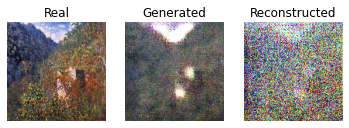

[INFO] Domain B to Domain A


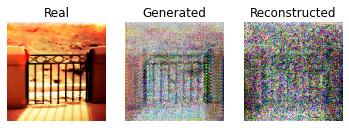

 30%|███       | 602/2000 [23:33<54:08,  2.32s/it]

dA_loss: 0.156 dB_loss: 0.094 gAB_loss :4.494 gBA_loss: 4.211


 30%|███       | 603/2000 [23:36<53:36,  2.30s/it]

dA_loss: 0.118 dB_loss: 0.077 gAB_loss :4.250 gBA_loss: 4.281


 30%|███       | 604/2000 [23:38<53:03,  2.28s/it]

dA_loss: 0.105 dB_loss: 0.092 gAB_loss :4.589 gBA_loss: 4.406


 30%|███       | 605/2000 [23:40<52:46,  2.27s/it]

dA_loss: 0.087 dB_loss: 0.111 gAB_loss :4.237 gBA_loss: 4.228


 30%|███       | 606/2000 [23:42<52:36,  2.26s/it]

dA_loss: 0.084 dB_loss: 0.203 gAB_loss :4.556 gBA_loss: 4.452


 30%|███       | 607/2000 [23:45<52:39,  2.27s/it]

dA_loss: 0.099 dB_loss: 0.114 gAB_loss :4.436 gBA_loss: 4.209


 30%|███       | 608/2000 [23:47<52:29,  2.26s/it]

dA_loss: 0.174 dB_loss: 0.078 gAB_loss :4.565 gBA_loss: 4.587


 30%|███       | 609/2000 [23:49<52:37,  2.27s/it]

dA_loss: 0.163 dB_loss: 0.067 gAB_loss :4.329 gBA_loss: 4.395


 30%|███       | 610/2000 [23:51<52:26,  2.26s/it]

dA_loss: 0.150 dB_loss: 0.070 gAB_loss :4.497 gBA_loss: 4.681


 31%|███       | 611/2000 [23:54<52:22,  2.26s/it]

dA_loss: 0.181 dB_loss: 0.072 gAB_loss :4.353 gBA_loss: 4.269


 31%|███       | 612/2000 [23:56<52:14,  2.26s/it]

dA_loss: 0.263 dB_loss: 0.071 gAB_loss :4.527 gBA_loss: 4.628


 31%|███       | 613/2000 [23:58<52:12,  2.26s/it]

dA_loss: 0.188 dB_loss: 0.072 gAB_loss :4.366 gBA_loss: 4.209


 31%|███       | 614/2000 [24:00<52:03,  2.25s/it]

dA_loss: 0.105 dB_loss: 0.078 gAB_loss :4.453 gBA_loss: 4.341


 31%|███       | 615/2000 [24:03<51:56,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.079 gAB_loss :4.388 gBA_loss: 4.144


 31%|███       | 616/2000 [24:05<51:48,  2.25s/it]

dA_loss: 0.079 dB_loss: 0.083 gAB_loss :4.599 gBA_loss: 4.332


 31%|███       | 617/2000 [24:07<51:50,  2.25s/it]

dA_loss: 0.071 dB_loss: 0.096 gAB_loss :4.325 gBA_loss: 4.248


 31%|███       | 618/2000 [24:09<51:38,  2.24s/it]

dA_loss: 0.098 dB_loss: 0.144 gAB_loss :4.544 gBA_loss: 4.482


 31%|███       | 619/2000 [24:12<51:47,  2.25s/it]

dA_loss: 0.100 dB_loss: 0.135 gAB_loss :4.332 gBA_loss: 4.351


 31%|███       | 620/2000 [24:14<51:40,  2.25s/it]

dA_loss: 0.103 dB_loss: 0.122 gAB_loss :4.579 gBA_loss: 4.571


 31%|███       | 621/2000 [24:16<51:30,  2.24s/it]

dA_loss: 0.093 dB_loss: 0.106 gAB_loss :4.316 gBA_loss: 4.331


 31%|███       | 622/2000 [24:18<51:29,  2.24s/it]

dA_loss: 0.116 dB_loss: 0.118 gAB_loss :4.558 gBA_loss: 4.515


 31%|███       | 623/2000 [24:21<51:32,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.095 gAB_loss :4.414 gBA_loss: 4.266


 31%|███       | 624/2000 [24:23<51:26,  2.24s/it]

dA_loss: 0.083 dB_loss: 0.102 gAB_loss :4.551 gBA_loss: 4.373


 31%|███▏      | 625/2000 [24:25<51:24,  2.24s/it]

dA_loss: 0.065 dB_loss: 0.115 gAB_loss :4.416 gBA_loss: 4.262


 31%|███▏      | 626/2000 [24:27<51:21,  2.24s/it]

dA_loss: 0.065 dB_loss: 0.101 gAB_loss :4.448 gBA_loss: 4.533


 31%|███▏      | 627/2000 [24:30<51:16,  2.24s/it]

dA_loss: 0.064 dB_loss: 0.077 gAB_loss :4.457 gBA_loss: 4.512


 31%|███▏      | 628/2000 [24:32<51:31,  2.25s/it]

dA_loss: 0.091 dB_loss: 0.056 gAB_loss :4.299 gBA_loss: 4.484


 31%|███▏      | 629/2000 [24:34<51:22,  2.25s/it]

dA_loss: 0.138 dB_loss: 0.095 gAB_loss :4.704 gBA_loss: 4.719


 32%|███▏      | 630/2000 [24:36<51:19,  2.25s/it]

dA_loss: 0.160 dB_loss: 0.161 gAB_loss :4.303 gBA_loss: 4.252


 32%|███▏      | 631/2000 [24:39<51:18,  2.25s/it]

dA_loss: 0.225 dB_loss: 0.256 gAB_loss :4.690 gBA_loss: 4.560


 32%|███▏      | 632/2000 [24:41<51:20,  2.25s/it]

dA_loss: 0.132 dB_loss: 0.172 gAB_loss :4.386 gBA_loss: 4.360


 32%|███▏      | 633/2000 [24:43<51:20,  2.25s/it]

dA_loss: 0.087 dB_loss: 0.090 gAB_loss :4.529 gBA_loss: 4.459


 32%|███▏      | 634/2000 [24:45<51:18,  2.25s/it]

dA_loss: 0.091 dB_loss: 0.072 gAB_loss :4.436 gBA_loss: 4.191


 32%|███▏      | 635/2000 [24:48<51:10,  2.25s/it]

dA_loss: 0.224 dB_loss: 0.068 gAB_loss :4.515 gBA_loss: 4.689


 32%|███▏      | 636/2000 [24:50<51:06,  2.25s/it]

dA_loss: 0.253 dB_loss: 0.087 gAB_loss :4.405 gBA_loss: 4.208


 32%|███▏      | 637/2000 [24:52<50:55,  2.24s/it]

dA_loss: 0.199 dB_loss: 0.092 gAB_loss :4.544 gBA_loss: 4.595


 32%|███▏      | 638/2000 [24:54<51:00,  2.25s/it]

dA_loss: 0.375 dB_loss: 0.076 gAB_loss :4.465 gBA_loss: 3.777


 32%|███▏      | 639/2000 [24:57<50:59,  2.25s/it]

dA_loss: 0.400 dB_loss: 0.073 gAB_loss :4.491 gBA_loss: 4.952


 32%|███▏      | 640/2000 [24:59<50:52,  2.24s/it]

dA_loss: 0.620 dB_loss: 0.065 gAB_loss :4.423 gBA_loss: 4.020


 32%|███▏      | 641/2000 [25:01<50:51,  2.25s/it]

dA_loss: 0.353 dB_loss: 0.067 gAB_loss :4.542 gBA_loss: 5.098


 32%|███▏      | 642/2000 [25:03<50:47,  2.24s/it]

dA_loss: 0.789 dB_loss: 0.110 gAB_loss :4.333 gBA_loss: 3.573


 32%|███▏      | 643/2000 [25:06<50:47,  2.25s/it]

dA_loss: 0.880 dB_loss: 0.188 gAB_loss :4.662 gBA_loss: 4.835


 32%|███▏      | 644/2000 [25:08<50:45,  2.25s/it]

dA_loss: 0.697 dB_loss: 0.145 gAB_loss :4.351 gBA_loss: 3.901


 32%|███▏      | 645/2000 [25:10<50:41,  2.24s/it]

dA_loss: 0.473 dB_loss: 0.102 gAB_loss :4.471 gBA_loss: 4.115


 32%|███▏      | 646/2000 [25:12<50:39,  2.25s/it]

dA_loss: 0.354 dB_loss: 0.083 gAB_loss :4.319 gBA_loss: 4.095


 32%|███▏      | 647/2000 [25:15<50:38,  2.25s/it]

dA_loss: 0.345 dB_loss: 0.077 gAB_loss :4.396 gBA_loss: 4.030


 32%|███▏      | 648/2000 [25:17<50:44,  2.25s/it]

dA_loss: 0.332 dB_loss: 0.077 gAB_loss :4.356 gBA_loss: 4.048


 32%|███▏      | 649/2000 [25:19<50:48,  2.26s/it]

dA_loss: 0.274 dB_loss: 0.064 gAB_loss :4.432 gBA_loss: 4.144


 32%|███▎      | 650/2000 [25:21<50:44,  2.26s/it]

dA_loss: 0.207 dB_loss: 0.073 gAB_loss :4.509 gBA_loss: 4.053
dA_loss: 0.159 dB_loss: 0.083 gAB_loss :4.528 gBA_loss: 4.150
[INFO] Domain A to Domain B


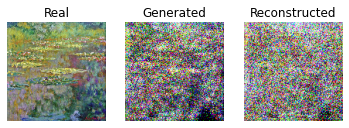

[INFO] Domain B to Domain A


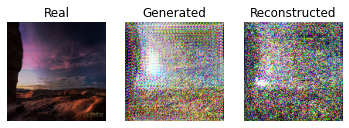

 33%|███▎      | 652/2000 [25:26<52:22,  2.33s/it]

dA_loss: 0.096 dB_loss: 0.105 gAB_loss :4.769 gBA_loss: 4.186


 33%|███▎      | 653/2000 [25:28<51:42,  2.30s/it]

dA_loss: 0.071 dB_loss: 0.125 gAB_loss :4.203 gBA_loss: 4.232


 33%|███▎      | 654/2000 [25:31<51:17,  2.29s/it]

dA_loss: 0.068 dB_loss: 0.212 gAB_loss :4.487 gBA_loss: 4.291


 33%|███▎      | 655/2000 [25:33<50:57,  2.27s/it]

dA_loss: 0.070 dB_loss: 0.143 gAB_loss :4.228 gBA_loss: 4.146


 33%|███▎      | 656/2000 [25:35<50:48,  2.27s/it]

dA_loss: 0.090 dB_loss: 0.081 gAB_loss :4.430 gBA_loss: 4.378


 33%|███▎      | 657/2000 [25:37<50:37,  2.26s/it]

dA_loss: 0.076 dB_loss: 0.084 gAB_loss :4.108 gBA_loss: 4.211


 33%|███▎      | 658/2000 [25:40<50:21,  2.25s/it]

dA_loss: 0.081 dB_loss: 0.118 gAB_loss :4.671 gBA_loss: 4.357


 33%|███▎      | 659/2000 [25:42<50:26,  2.26s/it]

dA_loss: 0.070 dB_loss: 0.185 gAB_loss :4.275 gBA_loss: 4.242


 33%|███▎      | 660/2000 [25:44<50:21,  2.25s/it]

dA_loss: 0.069 dB_loss: 0.264 gAB_loss :4.891 gBA_loss: 4.292


 33%|███▎      | 661/2000 [25:47<50:24,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.271 gAB_loss :4.207 gBA_loss: 4.215


 33%|███▎      | 662/2000 [25:49<50:30,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.163 gAB_loss :4.670 gBA_loss: 4.369


 33%|███▎      | 663/2000 [25:51<50:18,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.342 gAB_loss :3.828 gBA_loss: 4.202


 33%|███▎      | 664/2000 [25:53<50:13,  2.26s/it]

dA_loss: 0.072 dB_loss: 0.573 gAB_loss :4.882 gBA_loss: 4.405


 33%|███▎      | 665/2000 [25:56<50:08,  2.25s/it]

dA_loss: 0.063 dB_loss: 0.428 gAB_loss :4.158 gBA_loss: 4.390


 33%|███▎      | 666/2000 [25:58<49:57,  2.25s/it]

dA_loss: 0.054 dB_loss: 0.206 gAB_loss :4.273 gBA_loss: 4.359


 33%|███▎      | 667/2000 [26:00<49:52,  2.24s/it]

dA_loss: 0.067 dB_loss: 0.198 gAB_loss :4.050 gBA_loss: 4.516


 33%|███▎      | 668/2000 [26:02<49:51,  2.25s/it]

dA_loss: 0.119 dB_loss: 0.134 gAB_loss :4.250 gBA_loss: 4.145


 33%|███▎      | 669/2000 [26:04<49:40,  2.24s/it]

dA_loss: 0.264 dB_loss: 0.109 gAB_loss :4.234 gBA_loss: 4.560


 34%|███▎      | 670/2000 [26:07<49:35,  2.24s/it]

dA_loss: 0.128 dB_loss: 0.088 gAB_loss :4.388 gBA_loss: 4.357


 34%|███▎      | 671/2000 [26:09<49:31,  2.24s/it]

dA_loss: 0.071 dB_loss: 0.091 gAB_loss :4.455 gBA_loss: 4.219


 34%|███▎      | 672/2000 [26:11<49:34,  2.24s/it]

dA_loss: 0.056 dB_loss: 0.085 gAB_loss :4.554 gBA_loss: 4.257


 34%|███▎      | 673/2000 [26:13<49:36,  2.24s/it]

dA_loss: 0.060 dB_loss: 0.096 gAB_loss :4.224 gBA_loss: 4.211


 34%|███▎      | 674/2000 [26:16<49:29,  2.24s/it]

dA_loss: 0.060 dB_loss: 0.133 gAB_loss :4.433 gBA_loss: 4.284


 34%|███▍      | 675/2000 [26:18<49:38,  2.25s/it]

dA_loss: 0.057 dB_loss: 0.087 gAB_loss :4.264 gBA_loss: 4.258


 34%|███▍      | 676/2000 [26:20<49:31,  2.24s/it]

dA_loss: 0.044 dB_loss: 0.054 gAB_loss :4.293 gBA_loss: 4.292


 34%|███▍      | 677/2000 [26:22<49:30,  2.25s/it]

dA_loss: 0.050 dB_loss: 0.065 gAB_loss :4.573 gBA_loss: 4.482


 34%|███▍      | 678/2000 [26:25<49:22,  2.24s/it]

dA_loss: 0.055 dB_loss: 0.088 gAB_loss :4.284 gBA_loss: 4.362


 34%|███▍      | 679/2000 [26:27<49:27,  2.25s/it]

dA_loss: 0.085 dB_loss: 0.155 gAB_loss :4.520 gBA_loss: 4.695


 34%|███▍      | 680/2000 [26:29<49:22,  2.24s/it]

dA_loss: 0.127 dB_loss: 0.099 gAB_loss :4.326 gBA_loss: 4.132


 34%|███▍      | 681/2000 [26:31<49:14,  2.24s/it]

dA_loss: 0.235 dB_loss: 0.073 gAB_loss :4.318 gBA_loss: 4.370


 34%|███▍      | 682/2000 [26:34<49:08,  2.24s/it]

dA_loss: 0.132 dB_loss: 0.059 gAB_loss :4.353 gBA_loss: 4.299


 34%|███▍      | 683/2000 [26:36<49:11,  2.24s/it]

dA_loss: 0.099 dB_loss: 0.053 gAB_loss :4.359 gBA_loss: 4.060


 34%|███▍      | 684/2000 [26:38<49:11,  2.24s/it]

dA_loss: 0.076 dB_loss: 0.057 gAB_loss :4.452 gBA_loss: 4.283


 34%|███▍      | 685/2000 [26:40<49:12,  2.25s/it]

dA_loss: 0.066 dB_loss: 0.063 gAB_loss :4.527 gBA_loss: 4.032


 34%|███▍      | 686/2000 [26:43<49:14,  2.25s/it]

dA_loss: 0.076 dB_loss: 0.066 gAB_loss :4.352 gBA_loss: 4.327


 34%|███▍      | 687/2000 [26:45<49:09,  2.25s/it]

dA_loss: 0.069 dB_loss: 0.082 gAB_loss :4.577 gBA_loss: 4.143


 34%|███▍      | 688/2000 [26:47<49:03,  2.24s/it]

dA_loss: 0.087 dB_loss: 0.077 gAB_loss :4.299 gBA_loss: 4.363


 34%|███▍      | 689/2000 [26:49<49:11,  2.25s/it]

dA_loss: 0.076 dB_loss: 0.101 gAB_loss :4.487 gBA_loss: 4.364


 34%|███▍      | 690/2000 [26:52<49:07,  2.25s/it]

dA_loss: 0.098 dB_loss: 0.092 gAB_loss :4.143 gBA_loss: 4.367


 35%|███▍      | 691/2000 [26:54<49:05,  2.25s/it]

dA_loss: 0.129 dB_loss: 0.095 gAB_loss :4.354 gBA_loss: 4.672


 35%|███▍      | 692/2000 [26:56<49:05,  2.25s/it]

dA_loss: 0.119 dB_loss: 0.094 gAB_loss :4.257 gBA_loss: 4.229


 35%|███▍      | 693/2000 [26:58<49:05,  2.25s/it]

dA_loss: 0.138 dB_loss: 0.098 gAB_loss :4.510 gBA_loss: 4.389


 35%|███▍      | 694/2000 [27:01<48:59,  2.25s/it]

dA_loss: 0.075 dB_loss: 0.090 gAB_loss :4.258 gBA_loss: 4.259


 35%|███▍      | 695/2000 [27:03<48:52,  2.25s/it]

dA_loss: 0.058 dB_loss: 0.084 gAB_loss :4.407 gBA_loss: 4.219


 35%|███▍      | 696/2000 [27:05<48:46,  2.24s/it]

dA_loss: 0.057 dB_loss: 0.092 gAB_loss :4.276 gBA_loss: 4.267


 35%|███▍      | 697/2000 [27:07<48:44,  2.24s/it]

dA_loss: 0.063 dB_loss: 0.081 gAB_loss :4.531 gBA_loss: 4.311


 35%|███▍      | 698/2000 [27:10<48:39,  2.24s/it]

dA_loss: 0.065 dB_loss: 0.072 gAB_loss :4.334 gBA_loss: 4.240


 35%|███▍      | 699/2000 [27:12<48:43,  2.25s/it]

dA_loss: 0.107 dB_loss: 0.072 gAB_loss :4.464 gBA_loss: 4.530


 35%|███▌      | 700/2000 [27:14<48:40,  2.25s/it]

dA_loss: 0.170 dB_loss: 0.062 gAB_loss :4.290 gBA_loss: 4.093
dA_loss: 0.309 dB_loss: 0.076 gAB_loss :4.434 gBA_loss: 4.365
[INFO] Domain A to Domain B


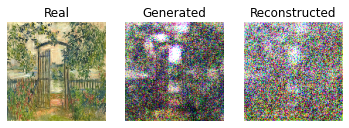

[INFO] Domain B to Domain A


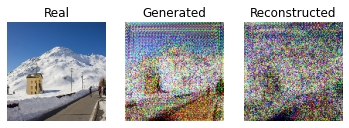

 35%|███▌      | 702/2000 [27:19<50:26,  2.33s/it]

dA_loss: 0.157 dB_loss: 0.072 gAB_loss :4.210 gBA_loss: 4.335


 35%|███▌      | 703/2000 [27:21<49:55,  2.31s/it]

dA_loss: 0.097 dB_loss: 0.095 gAB_loss :4.431 gBA_loss: 4.115


 35%|███▌      | 704/2000 [27:23<49:41,  2.30s/it]

dA_loss: 0.097 dB_loss: 0.091 gAB_loss :4.280 gBA_loss: 4.411


 35%|███▌      | 705/2000 [27:26<49:15,  2.28s/it]

dA_loss: 0.103 dB_loss: 0.099 gAB_loss :4.490 gBA_loss: 4.025


 35%|███▌      | 706/2000 [27:28<49:06,  2.28s/it]

dA_loss: 0.153 dB_loss: 0.086 gAB_loss :4.341 gBA_loss: 4.342


 35%|███▌      | 707/2000 [27:30<48:51,  2.27s/it]

dA_loss: 0.126 dB_loss: 0.074 gAB_loss :4.449 gBA_loss: 4.107


 35%|███▌      | 708/2000 [27:33<48:45,  2.26s/it]

dA_loss: 0.079 dB_loss: 0.073 gAB_loss :4.498 gBA_loss: 4.140


 35%|███▌      | 709/2000 [27:35<48:36,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.076 gAB_loss :4.328 gBA_loss: 4.176


 36%|███▌      | 710/2000 [27:37<48:28,  2.25s/it]

dA_loss: 0.047 dB_loss: 0.087 gAB_loss :4.570 gBA_loss: 4.203


 36%|███▌      | 711/2000 [27:39<48:17,  2.25s/it]

dA_loss: 0.055 dB_loss: 0.090 gAB_loss :4.325 gBA_loss: 4.618


 36%|███▌      | 712/2000 [27:41<48:13,  2.25s/it]

dA_loss: 0.095 dB_loss: 0.098 gAB_loss :4.526 gBA_loss: 4.390


 36%|███▌      | 713/2000 [27:44<48:07,  2.24s/it]

dA_loss: 0.197 dB_loss: 0.068 gAB_loss :4.392 gBA_loss: 4.944


 36%|███▌      | 714/2000 [27:46<48:05,  2.24s/it]

dA_loss: 0.209 dB_loss: 0.046 gAB_loss :4.521 gBA_loss: 4.137


 36%|███▌      | 715/2000 [27:48<48:04,  2.24s/it]

dA_loss: 0.203 dB_loss: 0.047 gAB_loss :4.556 gBA_loss: 4.328


 36%|███▌      | 716/2000 [27:50<48:03,  2.25s/it]

dA_loss: 0.140 dB_loss: 0.059 gAB_loss :4.424 gBA_loss: 4.166


 36%|███▌      | 717/2000 [27:53<48:03,  2.25s/it]

dA_loss: 0.140 dB_loss: 0.079 gAB_loss :4.402 gBA_loss: 4.031


 36%|███▌      | 718/2000 [27:55<48:05,  2.25s/it]

dA_loss: 0.122 dB_loss: 0.090 gAB_loss :4.436 gBA_loss: 4.115


 36%|███▌      | 719/2000 [27:57<48:04,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.095 gAB_loss :4.093 gBA_loss: 4.045


 36%|███▌      | 720/2000 [27:59<47:59,  2.25s/it]

dA_loss: 0.067 dB_loss: 0.148 gAB_loss :4.405 gBA_loss: 4.109


 36%|███▌      | 721/2000 [28:02<47:49,  2.24s/it]

dA_loss: 0.064 dB_loss: 0.121 gAB_loss :4.143 gBA_loss: 4.220


 36%|███▌      | 722/2000 [28:04<47:43,  2.24s/it]

dA_loss: 0.079 dB_loss: 0.100 gAB_loss :4.399 gBA_loss: 4.367


 36%|███▌      | 723/2000 [28:06<47:42,  2.24s/it]

dA_loss: 0.103 dB_loss: 0.097 gAB_loss :4.091 gBA_loss: 4.153


 36%|███▌      | 724/2000 [28:08<47:41,  2.24s/it]

dA_loss: 0.166 dB_loss: 0.096 gAB_loss :4.371 gBA_loss: 4.508


 36%|███▋      | 725/2000 [28:11<47:41,  2.24s/it]

dA_loss: 0.166 dB_loss: 0.161 gAB_loss :4.027 gBA_loss: 4.106


 36%|███▋      | 726/2000 [28:13<47:32,  2.24s/it]

dA_loss: 0.194 dB_loss: 0.218 gAB_loss :4.683 gBA_loss: 4.313


 36%|███▋      | 727/2000 [28:15<47:30,  2.24s/it]

dA_loss: 0.113 dB_loss: 0.202 gAB_loss :4.139 gBA_loss: 4.293


 36%|███▋      | 728/2000 [28:17<47:28,  2.24s/it]

dA_loss: 0.070 dB_loss: 0.117 gAB_loss :4.469 gBA_loss: 4.125


 36%|███▋      | 729/2000 [28:20<47:26,  2.24s/it]

dA_loss: 0.071 dB_loss: 0.171 gAB_loss :3.918 gBA_loss: 4.385


 36%|███▋      | 730/2000 [28:22<47:26,  2.24s/it]

dA_loss: 0.066 dB_loss: 0.285 gAB_loss :4.482 gBA_loss: 4.170


 37%|███▋      | 731/2000 [28:24<47:29,  2.25s/it]

dA_loss: 0.067 dB_loss: 0.185 gAB_loss :4.159 gBA_loss: 4.289


 37%|███▋      | 732/2000 [28:26<47:32,  2.25s/it]

dA_loss: 0.055 dB_loss: 0.106 gAB_loss :4.118 gBA_loss: 4.184


 37%|███▋      | 733/2000 [28:29<47:26,  2.25s/it]

dA_loss: 0.045 dB_loss: 0.085 gAB_loss :4.363 gBA_loss: 4.238


 37%|███▋      | 734/2000 [28:31<47:21,  2.24s/it]

dA_loss: 0.045 dB_loss: 0.084 gAB_loss :4.299 gBA_loss: 4.411


 37%|███▋      | 735/2000 [28:33<47:18,  2.24s/it]

dA_loss: 0.049 dB_loss: 0.103 gAB_loss :4.429 gBA_loss: 4.336


 37%|███▋      | 736/2000 [28:35<47:12,  2.24s/it]

dA_loss: 0.081 dB_loss: 0.135 gAB_loss :4.696 gBA_loss: 4.625


 37%|███▋      | 737/2000 [28:38<47:13,  2.24s/it]

dA_loss: 0.143 dB_loss: 0.156 gAB_loss :4.409 gBA_loss: 4.006


 37%|███▋      | 738/2000 [28:40<47:13,  2.25s/it]

dA_loss: 0.275 dB_loss: 0.205 gAB_loss :4.570 gBA_loss: 4.438


 37%|███▋      | 739/2000 [28:42<47:08,  2.24s/it]

dA_loss: 0.210 dB_loss: 0.118 gAB_loss :4.197 gBA_loss: 4.003


 37%|███▋      | 740/2000 [28:44<47:07,  2.24s/it]

dA_loss: 0.136 dB_loss: 0.071 gAB_loss :4.207 gBA_loss: 4.188


 37%|███▋      | 741/2000 [28:47<47:05,  2.24s/it]

dA_loss: 0.090 dB_loss: 0.060 gAB_loss :4.256 gBA_loss: 4.147


 37%|███▋      | 742/2000 [28:49<47:10,  2.25s/it]

dA_loss: 0.061 dB_loss: 0.069 gAB_loss :4.324 gBA_loss: 4.155


 37%|███▋      | 743/2000 [28:51<47:07,  2.25s/it]

dA_loss: 0.056 dB_loss: 0.106 gAB_loss :4.459 gBA_loss: 4.272


 37%|███▋      | 744/2000 [28:53<47:06,  2.25s/it]

dA_loss: 0.060 dB_loss: 0.154 gAB_loss :4.499 gBA_loss: 4.175


 37%|███▋      | 745/2000 [28:56<47:04,  2.25s/it]

dA_loss: 0.077 dB_loss: 0.173 gAB_loss :4.365 gBA_loss: 4.394


 37%|███▋      | 746/2000 [28:58<47:01,  2.25s/it]

dA_loss: 0.106 dB_loss: 0.128 gAB_loss :4.653 gBA_loss: 4.220


 37%|███▋      | 747/2000 [29:00<46:58,  2.25s/it]

dA_loss: 0.151 dB_loss: 0.121 gAB_loss :4.039 gBA_loss: 4.525


 37%|███▋      | 748/2000 [29:02<46:57,  2.25s/it]

dA_loss: 0.167 dB_loss: 0.266 gAB_loss :4.513 gBA_loss: 4.009


 37%|███▋      | 749/2000 [29:05<46:52,  2.25s/it]

dA_loss: 0.232 dB_loss: 0.170 gAB_loss :4.168 gBA_loss: 4.408


 38%|███▊      | 750/2000 [29:07<46:48,  2.25s/it]

dA_loss: 0.201 dB_loss: 0.069 gAB_loss :4.212 gBA_loss: 4.047
dA_loss: 0.140 dB_loss: 0.069 gAB_loss :4.286 gBA_loss: 4.328
[INFO] Domain A to Domain B


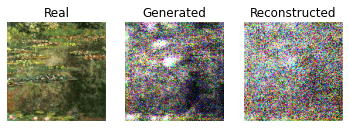

[INFO] Domain B to Domain A


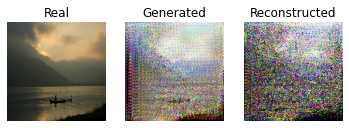

 38%|███▊      | 752/2000 [29:12<48:12,  2.32s/it]

dA_loss: 0.186 dB_loss: 0.077 gAB_loss :4.184 gBA_loss: 3.859


 38%|███▊      | 753/2000 [29:14<47:42,  2.30s/it]

dA_loss: 0.213 dB_loss: 0.087 gAB_loss :4.433 gBA_loss: 4.339


 38%|███▊      | 754/2000 [29:16<47:18,  2.28s/it]

dA_loss: 0.167 dB_loss: 0.106 gAB_loss :4.119 gBA_loss: 4.149


 38%|███▊      | 755/2000 [29:18<47:04,  2.27s/it]

dA_loss: 0.108 dB_loss: 0.223 gAB_loss :4.627 gBA_loss: 4.124


 38%|███▊      | 756/2000 [29:21<46:52,  2.26s/it]

dA_loss: 0.104 dB_loss: 0.203 gAB_loss :4.126 gBA_loss: 4.369


 38%|███▊      | 757/2000 [29:23<46:47,  2.26s/it]

dA_loss: 0.106 dB_loss: 0.166 gAB_loss :4.446 gBA_loss: 3.998


 38%|███▊      | 758/2000 [29:25<46:36,  2.25s/it]

dA_loss: 0.136 dB_loss: 0.123 gAB_loss :4.009 gBA_loss: 4.348


 38%|███▊      | 759/2000 [29:27<46:37,  2.25s/it]

dA_loss: 0.097 dB_loss: 0.096 gAB_loss :4.344 gBA_loss: 4.094


 38%|███▊      | 760/2000 [29:30<46:35,  2.25s/it]

dA_loss: 0.088 dB_loss: 0.098 gAB_loss :4.074 gBA_loss: 4.271


 38%|███▊      | 761/2000 [29:32<46:31,  2.25s/it]

dA_loss: 0.076 dB_loss: 0.083 gAB_loss :4.387 gBA_loss: 4.035


 38%|███▊      | 762/2000 [29:34<46:23,  2.25s/it]

dA_loss: 0.061 dB_loss: 0.076 gAB_loss :4.198 gBA_loss: 4.188


 38%|███▊      | 763/2000 [29:36<46:16,  2.24s/it]

dA_loss: 0.050 dB_loss: 0.073 gAB_loss :4.315 gBA_loss: 4.118


 38%|███▊      | 764/2000 [29:39<46:16,  2.25s/it]

dA_loss: 0.052 dB_loss: 0.072 gAB_loss :4.305 gBA_loss: 4.274


 38%|███▊      | 765/2000 [29:41<46:28,  2.26s/it]

dA_loss: 0.052 dB_loss: 0.070 gAB_loss :4.526 gBA_loss: 4.211


 38%|███▊      | 766/2000 [29:43<46:24,  2.26s/it]

dA_loss: 0.057 dB_loss: 0.089 gAB_loss :4.195 gBA_loss: 4.451


 38%|███▊      | 767/2000 [29:45<46:22,  2.26s/it]

dA_loss: 0.099 dB_loss: 0.156 gAB_loss :4.645 gBA_loss: 4.216


 38%|███▊      | 768/2000 [29:48<46:15,  2.25s/it]

dA_loss: 0.216 dB_loss: 0.147 gAB_loss :4.211 gBA_loss: 4.550


 38%|███▊      | 769/2000 [29:50<46:16,  2.26s/it]

dA_loss: 0.149 dB_loss: 0.117 gAB_loss :4.615 gBA_loss: 4.164


 38%|███▊      | 770/2000 [29:52<46:03,  2.25s/it]

dA_loss: 0.110 dB_loss: 0.139 gAB_loss :3.973 gBA_loss: 4.191


 39%|███▊      | 771/2000 [29:54<46:07,  2.25s/it]

dA_loss: 0.077 dB_loss: 0.164 gAB_loss :4.607 gBA_loss: 4.139


 39%|███▊      | 772/2000 [29:57<46:05,  2.25s/it]

dA_loss: 0.058 dB_loss: 0.289 gAB_loss :3.754 gBA_loss: 3.991


 39%|███▊      | 773/2000 [29:59<46:07,  2.26s/it]

dA_loss: 0.060 dB_loss: 0.318 gAB_loss :5.195 gBA_loss: 4.295


 39%|███▊      | 774/2000 [30:01<46:09,  2.26s/it]

dA_loss: 0.075 dB_loss: 0.590 gAB_loss :3.737 gBA_loss: 4.025


 39%|███▉      | 775/2000 [30:03<46:03,  2.26s/it]

dA_loss: 0.132 dB_loss: 0.459 gAB_loss :5.864 gBA_loss: 4.456


 39%|███▉      | 776/2000 [30:06<45:52,  2.25s/it]

dA_loss: 0.109 dB_loss: 1.453 gAB_loss :3.642 gBA_loss: 4.066


 39%|███▉      | 777/2000 [30:08<45:49,  2.25s/it]

dA_loss: 0.125 dB_loss: 1.772 gAB_loss :5.617 gBA_loss: 4.221


 39%|███▉      | 778/2000 [30:10<45:49,  2.25s/it]

dA_loss: 0.090 dB_loss: 1.112 gAB_loss :4.208 gBA_loss: 4.155


 39%|███▉      | 779/2000 [30:12<45:47,  2.25s/it]

dA_loss: 0.063 dB_loss: 0.880 gAB_loss :4.231 gBA_loss: 4.239


 39%|███▉      | 780/2000 [30:15<45:50,  2.25s/it]

dA_loss: 0.060 dB_loss: 0.850 gAB_loss :4.338 gBA_loss: 4.140


 39%|███▉      | 781/2000 [30:17<45:41,  2.25s/it]

dA_loss: 0.099 dB_loss: 0.658 gAB_loss :3.690 gBA_loss: 4.428


 39%|███▉      | 782/2000 [30:19<45:42,  2.25s/it]

dA_loss: 0.121 dB_loss: 0.423 gAB_loss :3.818 gBA_loss: 3.982


 39%|███▉      | 783/2000 [30:21<45:35,  2.25s/it]

dA_loss: 0.186 dB_loss: 0.274 gAB_loss :3.847 gBA_loss: 4.261


 39%|███▉      | 784/2000 [30:24<45:43,  2.26s/it]

dA_loss: 0.139 dB_loss: 0.253 gAB_loss :3.672 gBA_loss: 4.062


 39%|███▉      | 785/2000 [30:26<45:35,  2.25s/it]

dA_loss: 0.097 dB_loss: 0.210 gAB_loss :3.728 gBA_loss: 4.136


 39%|███▉      | 786/2000 [30:28<45:32,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.169 gAB_loss :3.864 gBA_loss: 4.162


 39%|███▉      | 787/2000 [30:30<45:33,  2.25s/it]

dA_loss: 0.086 dB_loss: 0.156 gAB_loss :3.901 gBA_loss: 4.058


 39%|███▉      | 788/2000 [30:33<45:37,  2.26s/it]

dA_loss: 0.118 dB_loss: 0.134 gAB_loss :4.052 gBA_loss: 4.430


 39%|███▉      | 789/2000 [30:35<45:27,  2.25s/it]

dA_loss: 0.168 dB_loss: 0.121 gAB_loss :3.967 gBA_loss: 4.018


 40%|███▉      | 790/2000 [30:37<45:19,  2.25s/it]

dA_loss: 0.291 dB_loss: 0.117 gAB_loss :3.932 gBA_loss: 4.446


 40%|███▉      | 791/2000 [30:39<45:15,  2.25s/it]

dA_loss: 0.231 dB_loss: 0.112 gAB_loss :3.954 gBA_loss: 4.079


 40%|███▉      | 792/2000 [30:42<45:08,  2.24s/it]

dA_loss: 0.184 dB_loss: 0.099 gAB_loss :3.928 gBA_loss: 4.280


 40%|███▉      | 793/2000 [30:44<45:05,  2.24s/it]

dA_loss: 0.164 dB_loss: 0.095 gAB_loss :4.117 gBA_loss: 4.167


 40%|███▉      | 794/2000 [30:46<44:59,  2.24s/it]

dA_loss: 0.114 dB_loss: 0.093 gAB_loss :3.955 gBA_loss: 4.055


 40%|███▉      | 795/2000 [30:48<44:57,  2.24s/it]

dA_loss: 0.107 dB_loss: 0.097 gAB_loss :4.142 gBA_loss: 4.211


 40%|███▉      | 796/2000 [30:51<44:55,  2.24s/it]

dA_loss: 0.100 dB_loss: 0.095 gAB_loss :3.908 gBA_loss: 3.872


 40%|███▉      | 797/2000 [30:53<44:52,  2.24s/it]

dA_loss: 0.148 dB_loss: 0.112 gAB_loss :4.200 gBA_loss: 4.344


 40%|███▉      | 798/2000 [30:55<45:01,  2.25s/it]

dA_loss: 0.150 dB_loss: 0.114 gAB_loss :3.801 gBA_loss: 4.069


 40%|███▉      | 799/2000 [30:57<44:54,  2.24s/it]

dA_loss: 0.109 dB_loss: 0.151 gAB_loss :4.122 gBA_loss: 4.491


 40%|████      | 800/2000 [31:00<44:54,  2.25s/it]

dA_loss: 0.142 dB_loss: 0.105 gAB_loss :4.091 gBA_loss: 3.849
dA_loss: 0.267 dB_loss: 0.085 gAB_loss :4.029 gBA_loss: 4.496
[INFO] Domain A to Domain B


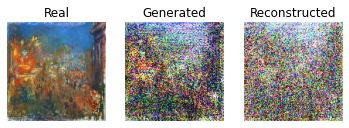

[INFO] Domain B to Domain A


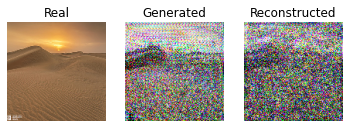

 40%|████      | 802/2000 [31:04<46:28,  2.33s/it]

dA_loss: 0.216 dB_loss: 0.099 gAB_loss :4.317 gBA_loss: 4.065


 40%|████      | 803/2000 [31:07<45:58,  2.30s/it]

dA_loss: 0.125 dB_loss: 0.107 gAB_loss :4.049 gBA_loss: 4.288


 40%|████      | 804/2000 [31:09<45:31,  2.28s/it]

dA_loss: 0.115 dB_loss: 0.158 gAB_loss :4.310 gBA_loss: 4.148


 40%|████      | 805/2000 [31:11<45:16,  2.27s/it]

dA_loss: 0.097 dB_loss: 0.166 gAB_loss :4.226 gBA_loss: 4.135


 40%|████      | 806/2000 [31:13<45:05,  2.27s/it]

dA_loss: 0.061 dB_loss: 0.113 gAB_loss :4.344 gBA_loss: 4.227


 40%|████      | 807/2000 [31:16<44:54,  2.26s/it]

dA_loss: 0.052 dB_loss: 0.085 gAB_loss :4.188 gBA_loss: 4.085


 40%|████      | 808/2000 [31:18<44:46,  2.25s/it]

dA_loss: 0.098 dB_loss: 0.072 gAB_loss :4.150 gBA_loss: 4.532


 40%|████      | 809/2000 [31:20<44:40,  2.25s/it]

dA_loss: 0.213 dB_loss: 0.069 gAB_loss :4.137 gBA_loss: 3.863


 40%|████      | 810/2000 [31:22<44:35,  2.25s/it]

dA_loss: 0.352 dB_loss: 0.064 gAB_loss :4.050 gBA_loss: 4.395


 41%|████      | 811/2000 [31:25<44:29,  2.25s/it]

dA_loss: 0.211 dB_loss: 0.065 gAB_loss :4.182 gBA_loss: 3.954


 41%|████      | 812/2000 [31:27<44:26,  2.24s/it]

dA_loss: 0.127 dB_loss: 0.056 gAB_loss :4.045 gBA_loss: 3.990


 41%|████      | 813/2000 [31:29<44:19,  2.24s/it]

dA_loss: 0.086 dB_loss: 0.066 gAB_loss :4.299 gBA_loss: 4.087


 41%|████      | 814/2000 [31:31<44:18,  2.24s/it]

dA_loss: 0.074 dB_loss: 0.085 gAB_loss :3.999 gBA_loss: 3.913


 41%|████      | 815/2000 [31:34<44:22,  2.25s/it]

dA_loss: 0.062 dB_loss: 0.136 gAB_loss :4.413 gBA_loss: 4.228


 41%|████      | 816/2000 [31:36<44:19,  2.25s/it]

dA_loss: 0.078 dB_loss: 0.108 gAB_loss :4.095 gBA_loss: 4.031


 41%|████      | 817/2000 [31:38<44:17,  2.25s/it]

dA_loss: 0.171 dB_loss: 0.131 gAB_loss :4.201 gBA_loss: 4.350


 41%|████      | 818/2000 [31:40<44:18,  2.25s/it]

dA_loss: 0.104 dB_loss: 0.082 gAB_loss :4.096 gBA_loss: 4.103


 41%|████      | 819/2000 [31:43<44:15,  2.25s/it]

dA_loss: 0.061 dB_loss: 0.065 gAB_loss :3.961 gBA_loss: 4.059


 41%|████      | 820/2000 [31:45<44:12,  2.25s/it]

dA_loss: 0.050 dB_loss: 0.069 gAB_loss :4.208 gBA_loss: 4.182


 41%|████      | 821/2000 [31:47<44:07,  2.25s/it]

dA_loss: 0.060 dB_loss: 0.082 gAB_loss :3.988 gBA_loss: 3.988


 41%|████      | 822/2000 [31:49<44:10,  2.25s/it]

dA_loss: 0.090 dB_loss: 0.139 gAB_loss :4.317 gBA_loss: 4.303


 41%|████      | 823/2000 [31:52<44:03,  2.25s/it]

dA_loss: 0.126 dB_loss: 0.115 gAB_loss :4.088 gBA_loss: 4.024


 41%|████      | 824/2000 [31:54<44:00,  2.25s/it]

dA_loss: 0.168 dB_loss: 0.111 gAB_loss :4.212 gBA_loss: 4.294


 41%|████▏     | 825/2000 [31:56<43:50,  2.24s/it]

dA_loss: 0.063 dB_loss: 0.080 gAB_loss :4.159 gBA_loss: 4.294


 41%|████▏     | 826/2000 [31:58<43:52,  2.24s/it]

dA_loss: 0.061 dB_loss: 0.062 gAB_loss :4.173 gBA_loss: 3.943


 41%|████▏     | 827/2000 [32:01<43:52,  2.24s/it]

dA_loss: 0.132 dB_loss: 0.062 gAB_loss :4.340 gBA_loss: 4.269


 41%|████▏     | 828/2000 [32:03<43:49,  2.24s/it]

dA_loss: 0.089 dB_loss: 0.072 gAB_loss :3.993 gBA_loss: 3.990


 41%|████▏     | 829/2000 [32:05<43:46,  2.24s/it]

dA_loss: 0.085 dB_loss: 0.117 gAB_loss :4.333 gBA_loss: 4.118


 42%|████▏     | 830/2000 [32:07<43:45,  2.24s/it]

dA_loss: 0.076 dB_loss: 0.100 gAB_loss :4.014 gBA_loss: 4.052


 42%|████▏     | 831/2000 [32:10<43:38,  2.24s/it]

dA_loss: 0.091 dB_loss: 0.111 gAB_loss :4.252 gBA_loss: 4.264


 42%|████▏     | 832/2000 [32:12<43:31,  2.24s/it]

dA_loss: 0.107 dB_loss: 0.078 gAB_loss :4.015 gBA_loss: 4.188


 42%|████▏     | 833/2000 [32:14<43:29,  2.24s/it]

dA_loss: 0.139 dB_loss: 0.071 gAB_loss :4.117 gBA_loss: 4.392


 42%|████▏     | 834/2000 [32:16<43:30,  2.24s/it]

dA_loss: 0.113 dB_loss: 0.061 gAB_loss :4.191 gBA_loss: 4.113


 42%|████▏     | 835/2000 [32:18<43:30,  2.24s/it]

dA_loss: 0.097 dB_loss: 0.060 gAB_loss :4.137 gBA_loss: 4.182


 42%|████▏     | 836/2000 [32:21<43:26,  2.24s/it]

dA_loss: 0.058 dB_loss: 0.084 gAB_loss :4.420 gBA_loss: 4.165


 42%|████▏     | 837/2000 [32:23<43:24,  2.24s/it]

dA_loss: 0.045 dB_loss: 0.103 gAB_loss :3.965 gBA_loss: 4.100


 42%|████▏     | 838/2000 [32:25<43:19,  2.24s/it]

dA_loss: 0.067 dB_loss: 0.192 gAB_loss :4.273 gBA_loss: 4.398


 42%|████▏     | 839/2000 [32:27<43:21,  2.24s/it]

dA_loss: 0.087 dB_loss: 0.140 gAB_loss :4.103 gBA_loss: 4.026


 42%|████▏     | 840/2000 [32:30<43:16,  2.24s/it]

dA_loss: 0.150 dB_loss: 0.069 gAB_loss :4.148 gBA_loss: 4.253


 42%|████▏     | 841/2000 [32:32<43:21,  2.24s/it]

dA_loss: 0.089 dB_loss: 0.058 gAB_loss :4.153 gBA_loss: 4.110


 42%|████▏     | 842/2000 [32:34<43:15,  2.24s/it]

dA_loss: 0.047 dB_loss: 0.050 gAB_loss :4.096 gBA_loss: 4.049


 42%|████▏     | 843/2000 [32:37<44:42,  2.32s/it]

dA_loss: 0.054 dB_loss: 0.056 gAB_loss :4.192 gBA_loss: 4.213


 42%|████▏     | 844/2000 [32:39<44:12,  2.29s/it]

dA_loss: 0.063 dB_loss: 0.043 gAB_loss :4.270 gBA_loss: 3.919


 42%|████▏     | 845/2000 [32:41<43:56,  2.28s/it]

dA_loss: 0.094 dB_loss: 0.047 gAB_loss :4.116 gBA_loss: 4.284


 42%|████▏     | 846/2000 [32:43<43:35,  2.27s/it]

dA_loss: 0.093 dB_loss: 0.069 gAB_loss :4.347 gBA_loss: 3.992


 42%|████▏     | 847/2000 [32:46<43:19,  2.25s/it]

dA_loss: 0.084 dB_loss: 0.088 gAB_loss :3.962 gBA_loss: 4.253


 42%|████▏     | 848/2000 [32:48<43:11,  2.25s/it]

dA_loss: 0.074 dB_loss: 0.135 gAB_loss :4.348 gBA_loss: 3.941


 42%|████▏     | 849/2000 [32:50<43:09,  2.25s/it]

dA_loss: 0.074 dB_loss: 0.097 gAB_loss :4.111 gBA_loss: 4.182


 42%|████▎     | 850/2000 [32:52<43:07,  2.25s/it]

dA_loss: 0.065 dB_loss: 0.074 gAB_loss :4.203 gBA_loss: 4.094
dA_loss: 0.048 dB_loss: 0.047 gAB_loss :4.322 gBA_loss: 4.188
[INFO] Domain A to Domain B


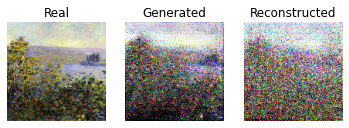

[INFO] Domain B to Domain A


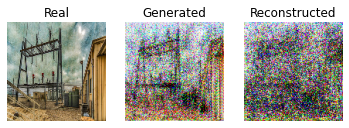

 43%|████▎     | 852/2000 [32:57<44:50,  2.34s/it]

dA_loss: 0.068 dB_loss: 0.046 gAB_loss :4.105 gBA_loss: 4.342


 43%|████▎     | 853/2000 [33:00<44:19,  2.32s/it]

dA_loss: 0.090 dB_loss: 0.052 gAB_loss :4.386 gBA_loss: 4.059


 43%|████▎     | 854/2000 [33:02<43:57,  2.30s/it]

dA_loss: 0.135 dB_loss: 0.058 gAB_loss :4.121 gBA_loss: 4.369


 43%|████▎     | 855/2000 [33:04<43:35,  2.28s/it]

dA_loss: 0.111 dB_loss: 0.082 gAB_loss :4.476 gBA_loss: 4.180


 43%|████▎     | 856/2000 [33:06<43:18,  2.27s/it]

dA_loss: 0.085 dB_loss: 0.134 gAB_loss :4.117 gBA_loss: 4.199


 43%|████▎     | 857/2000 [33:09<43:14,  2.27s/it]

dA_loss: 0.061 dB_loss: 0.207 gAB_loss :4.472 gBA_loss: 4.226


 43%|████▎     | 858/2000 [33:11<43:06,  2.27s/it]

dA_loss: 0.048 dB_loss: 0.135 gAB_loss :4.029 gBA_loss: 4.064


 43%|████▎     | 859/2000 [33:13<42:51,  2.25s/it]

dA_loss: 0.058 dB_loss: 0.094 gAB_loss :4.072 gBA_loss: 4.380


 43%|████▎     | 860/2000 [33:15<42:47,  2.25s/it]

dA_loss: 0.110 dB_loss: 0.083 gAB_loss :4.103 gBA_loss: 3.812


 43%|████▎     | 861/2000 [33:18<42:39,  2.25s/it]

dA_loss: 0.264 dB_loss: 0.059 gAB_loss :4.101 gBA_loss: 4.514


 43%|████▎     | 862/2000 [33:20<42:45,  2.25s/it]

dA_loss: 0.320 dB_loss: 0.056 gAB_loss :4.106 gBA_loss: 4.127


 43%|████▎     | 863/2000 [33:22<42:37,  2.25s/it]

dA_loss: 0.235 dB_loss: 0.044 gAB_loss :4.218 gBA_loss: 4.958


 43%|████▎     | 864/2000 [33:24<42:32,  2.25s/it]

dA_loss: 0.719 dB_loss: 0.048 gAB_loss :4.141 gBA_loss: 3.661


 43%|████▎     | 865/2000 [33:27<42:28,  2.25s/it]

dA_loss: 1.039 dB_loss: 0.056 gAB_loss :4.380 gBA_loss: 6.990


 43%|████▎     | 866/2000 [33:29<42:23,  2.24s/it]

dA_loss: 3.082 dB_loss: 0.066 gAB_loss :4.116 gBA_loss: 4.141


 43%|████▎     | 867/2000 [33:31<42:19,  2.24s/it]

dA_loss: 2.114 dB_loss: 0.109 gAB_loss :4.443 gBA_loss: 5.765


 43%|████▎     | 868/2000 [33:33<42:16,  2.24s/it]

dA_loss: 2.379 dB_loss: 0.117 gAB_loss :4.023 gBA_loss: 6.628


 43%|████▎     | 869/2000 [33:35<42:14,  2.24s/it]

dA_loss: 5.484 dB_loss: 0.149 gAB_loss :4.414 gBA_loss: 7.491


 44%|████▎     | 870/2000 [33:38<42:07,  2.24s/it]

dA_loss: 6.834 dB_loss: 0.156 gAB_loss :3.963 gBA_loss: 6.942


 44%|████▎     | 871/2000 [33:40<42:11,  2.24s/it]

dA_loss: 4.262 dB_loss: 0.129 gAB_loss :4.291 gBA_loss: 5.905


 44%|████▎     | 872/2000 [33:42<42:18,  2.25s/it]

dA_loss: 3.564 dB_loss: 0.170 gAB_loss :3.835 gBA_loss: 5.439


 44%|████▎     | 873/2000 [33:45<42:25,  2.26s/it]

dA_loss: 3.287 dB_loss: 0.219 gAB_loss :4.400 gBA_loss: 4.676


 44%|████▎     | 874/2000 [33:47<42:24,  2.26s/it]

dA_loss: 0.978 dB_loss: 0.147 gAB_loss :4.086 gBA_loss: 3.957


 44%|████▍     | 875/2000 [33:49<42:27,  2.26s/it]

dA_loss: 0.767 dB_loss: 0.067 gAB_loss :4.066 gBA_loss: 3.615


 44%|████▍     | 876/2000 [33:51<42:19,  2.26s/it]

dA_loss: 0.624 dB_loss: 0.059 gAB_loss :4.291 gBA_loss: 3.574


 44%|████▍     | 877/2000 [33:54<42:14,  2.26s/it]

dA_loss: 0.540 dB_loss: 0.113 gAB_loss :4.072 gBA_loss: 3.503


 44%|████▍     | 878/2000 [33:56<42:07,  2.25s/it]

dA_loss: 0.494 dB_loss: 0.160 gAB_loss :4.615 gBA_loss: 3.460


 44%|████▍     | 879/2000 [33:58<42:06,  2.25s/it]

dA_loss: 0.459 dB_loss: 0.136 gAB_loss :4.009 gBA_loss: 3.349


 44%|████▍     | 880/2000 [34:00<42:03,  2.25s/it]

dA_loss: 0.427 dB_loss: 0.182 gAB_loss :4.260 gBA_loss: 3.322


 44%|████▍     | 881/2000 [34:03<42:13,  2.26s/it]

dA_loss: 0.403 dB_loss: 0.122 gAB_loss :3.941 gBA_loss: 3.310


 44%|████▍     | 882/2000 [34:05<42:07,  2.26s/it]

dA_loss: 0.380 dB_loss: 0.085 gAB_loss :3.963 gBA_loss: 3.319


 44%|████▍     | 883/2000 [34:07<41:58,  2.25s/it]

dA_loss: 0.362 dB_loss: 0.066 gAB_loss :4.018 gBA_loss: 3.323


 44%|████▍     | 884/2000 [34:09<41:55,  2.25s/it]

dA_loss: 0.350 dB_loss: 0.051 gAB_loss :3.987 gBA_loss: 3.362


 44%|████▍     | 885/2000 [34:12<41:55,  2.26s/it]

dA_loss: 0.343 dB_loss: 0.045 gAB_loss :4.184 gBA_loss: 3.322


 44%|████▍     | 886/2000 [34:14<41:49,  2.25s/it]

dA_loss: 0.336 dB_loss: 0.052 gAB_loss :4.313 gBA_loss: 3.338


 44%|████▍     | 887/2000 [34:16<41:46,  2.25s/it]

dA_loss: 0.329 dB_loss: 0.087 gAB_loss :4.144 gBA_loss: 3.296


 44%|████▍     | 888/2000 [34:18<41:48,  2.26s/it]

dA_loss: 0.319 dB_loss: 0.158 gAB_loss :4.484 gBA_loss: 3.312


 44%|████▍     | 889/2000 [34:21<41:40,  2.25s/it]

dA_loss: 0.310 dB_loss: 0.160 gAB_loss :3.901 gBA_loss: 3.291


 44%|████▍     | 890/2000 [34:23<41:35,  2.25s/it]

dA_loss: 0.299 dB_loss: 0.161 gAB_loss :4.257 gBA_loss: 3.338


 45%|████▍     | 891/2000 [34:25<41:28,  2.24s/it]

dA_loss: 0.284 dB_loss: 0.105 gAB_loss :3.965 gBA_loss: 3.359


 45%|████▍     | 892/2000 [34:27<41:29,  2.25s/it]

dA_loss: 0.280 dB_loss: 0.089 gAB_loss :4.052 gBA_loss: 3.419


 45%|████▍     | 893/2000 [34:30<41:27,  2.25s/it]

dA_loss: 0.278 dB_loss: 0.080 gAB_loss :4.074 gBA_loss: 3.445


 45%|████▍     | 894/2000 [34:32<41:31,  2.25s/it]

dA_loss: 0.270 dB_loss: 0.060 gAB_loss :4.136 gBA_loss: 3.496


 45%|████▍     | 895/2000 [34:34<41:25,  2.25s/it]

dA_loss: 0.265 dB_loss: 0.060 gAB_loss :4.394 gBA_loss: 3.422


 45%|████▍     | 896/2000 [34:36<41:25,  2.25s/it]

dA_loss: 0.253 dB_loss: 0.052 gAB_loss :4.291 gBA_loss: 3.436


 45%|████▍     | 897/2000 [34:39<41:22,  2.25s/it]

dA_loss: 0.254 dB_loss: 0.056 gAB_loss :4.295 gBA_loss: 3.399


 45%|████▍     | 898/2000 [34:41<41:20,  2.25s/it]

dA_loss: 0.248 dB_loss: 0.060 gAB_loss :4.381 gBA_loss: 3.386


 45%|████▍     | 899/2000 [34:43<41:21,  2.25s/it]

dA_loss: 0.244 dB_loss: 0.066 gAB_loss :3.921 gBA_loss: 3.358


 45%|████▌     | 900/2000 [34:45<41:22,  2.26s/it]

dA_loss: 0.235 dB_loss: 0.118 gAB_loss :4.303 gBA_loss: 3.393
dA_loss: 0.222 dB_loss: 0.123 gAB_loss :3.829 gBA_loss: 3.398
[INFO] Domain A to Domain B


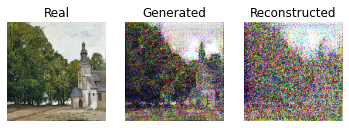

[INFO] Domain B to Domain A


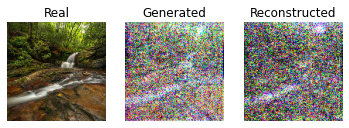

 45%|████▌     | 902/2000 [34:50<42:41,  2.33s/it]

dA_loss: 0.219 dB_loss: 0.134 gAB_loss :4.237 gBA_loss: 3.476


 45%|████▌     | 903/2000 [34:52<42:07,  2.30s/it]

dA_loss: 0.203 dB_loss: 0.096 gAB_loss :4.026 gBA_loss: 3.480


 45%|████▌     | 904/2000 [34:55<41:53,  2.29s/it]

dA_loss: 0.207 dB_loss: 0.079 gAB_loss :4.209 gBA_loss: 3.450


 45%|████▌     | 905/2000 [34:57<41:43,  2.29s/it]

dA_loss: 0.203 dB_loss: 0.077 gAB_loss :4.167 gBA_loss: 3.452


 45%|████▌     | 906/2000 [34:59<41:29,  2.28s/it]

dA_loss: 0.201 dB_loss: 0.068 gAB_loss :4.055 gBA_loss: 3.444


 45%|████▌     | 907/2000 [35:01<41:14,  2.26s/it]

dA_loss: 0.193 dB_loss: 0.074 gAB_loss :4.271 gBA_loss: 3.511


 45%|████▌     | 908/2000 [35:04<41:02,  2.26s/it]

dA_loss: 0.187 dB_loss: 0.107 gAB_loss :3.923 gBA_loss: 3.501


 45%|████▌     | 909/2000 [35:06<40:58,  2.25s/it]

dA_loss: 0.177 dB_loss: 0.199 gAB_loss :4.445 gBA_loss: 3.522


 46%|████▌     | 910/2000 [35:08<40:59,  2.26s/it]

dA_loss: 0.178 dB_loss: 0.151 gAB_loss :3.948 gBA_loss: 3.473


 46%|████▌     | 911/2000 [35:10<40:56,  2.26s/it]

dA_loss: 0.171 dB_loss: 0.151 gAB_loss :4.182 gBA_loss: 3.517


 46%|████▌     | 912/2000 [35:13<40:52,  2.25s/it]

dA_loss: 0.165 dB_loss: 0.085 gAB_loss :4.099 gBA_loss: 3.508


 46%|████▌     | 913/2000 [35:15<40:53,  2.26s/it]

dA_loss: 0.158 dB_loss: 0.055 gAB_loss :4.069 gBA_loss: 3.613


 46%|████▌     | 914/2000 [35:17<40:56,  2.26s/it]

dA_loss: 0.148 dB_loss: 0.053 gAB_loss :4.225 gBA_loss: 3.583


 46%|████▌     | 915/2000 [35:20<40:48,  2.26s/it]

dA_loss: 0.152 dB_loss: 0.050 gAB_loss :4.117 gBA_loss: 3.610


 46%|████▌     | 916/2000 [35:22<40:39,  2.25s/it]

dA_loss: 0.150 dB_loss: 0.049 gAB_loss :4.128 gBA_loss: 3.538


 46%|████▌     | 917/2000 [35:24<40:38,  2.25s/it]

dA_loss: 0.147 dB_loss: 0.059 gAB_loss :4.267 gBA_loss: 3.524


 46%|████▌     | 918/2000 [35:26<40:33,  2.25s/it]

dA_loss: 0.142 dB_loss: 0.070 gAB_loss :3.885 gBA_loss: 3.525


 46%|████▌     | 919/2000 [35:28<40:25,  2.24s/it]

dA_loss: 0.137 dB_loss: 0.141 gAB_loss :4.395 gBA_loss: 3.597


 46%|████▌     | 920/2000 [35:31<40:25,  2.25s/it]

dA_loss: 0.127 dB_loss: 0.189 gAB_loss :3.783 gBA_loss: 3.614


 46%|████▌     | 921/2000 [35:33<40:23,  2.25s/it]

dA_loss: 0.119 dB_loss: 0.298 gAB_loss :4.541 gBA_loss: 3.676


 46%|████▌     | 922/2000 [35:35<40:20,  2.25s/it]

dA_loss: 0.119 dB_loss: 0.271 gAB_loss :3.982 gBA_loss: 3.651


 46%|████▌     | 923/2000 [35:37<40:14,  2.24s/it]

dA_loss: 0.118 dB_loss: 0.192 gAB_loss :4.261 gBA_loss: 3.611


 46%|████▌     | 924/2000 [35:40<40:11,  2.24s/it]

dA_loss: 0.119 dB_loss: 0.292 gAB_loss :3.445 gBA_loss: 3.645


 46%|████▋     | 925/2000 [35:42<40:10,  2.24s/it]

dA_loss: 0.112 dB_loss: 0.356 gAB_loss :4.361 gBA_loss: 3.632


 46%|████▋     | 926/2000 [35:44<40:13,  2.25s/it]

dA_loss: 0.114 dB_loss: 0.253 gAB_loss :3.928 gBA_loss: 3.698


 46%|████▋     | 927/2000 [35:46<40:12,  2.25s/it]

dA_loss: 0.104 dB_loss: 0.127 gAB_loss :3.950 gBA_loss: 3.670


 46%|████▋     | 928/2000 [35:49<40:20,  2.26s/it]

dA_loss: 0.099 dB_loss: 0.126 gAB_loss :4.128 gBA_loss: 3.716


 46%|████▋     | 929/2000 [35:51<40:19,  2.26s/it]

dA_loss: 0.096 dB_loss: 0.120 gAB_loss :3.907 gBA_loss: 3.744


 46%|████▋     | 930/2000 [35:53<40:17,  2.26s/it]

dA_loss: 0.092 dB_loss: 0.090 gAB_loss :4.015 gBA_loss: 3.740


 47%|████▋     | 931/2000 [35:56<40:12,  2.26s/it]

dA_loss: 0.095 dB_loss: 0.072 gAB_loss :4.047 gBA_loss: 3.742


 47%|████▋     | 932/2000 [35:58<40:05,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.064 gAB_loss :4.014 gBA_loss: 3.655


 47%|████▋     | 933/2000 [36:00<39:58,  2.25s/it]

dA_loss: 0.099 dB_loss: 0.064 gAB_loss :4.152 gBA_loss: 3.744


 47%|████▋     | 934/2000 [36:02<40:00,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.084 gAB_loss :4.055 gBA_loss: 3.615


 47%|████▋     | 935/2000 [36:05<39:58,  2.25s/it]

dA_loss: 0.100 dB_loss: 0.096 gAB_loss :4.345 gBA_loss: 3.782


 47%|████▋     | 936/2000 [36:07<39:50,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.109 gAB_loss :3.861 gBA_loss: 3.615


 47%|████▋     | 937/2000 [36:09<39:50,  2.25s/it]

dA_loss: 0.099 dB_loss: 0.155 gAB_loss :4.344 gBA_loss: 3.852


 47%|████▋     | 938/2000 [36:11<39:48,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.171 gAB_loss :3.840 gBA_loss: 3.652


 47%|████▋     | 939/2000 [36:13<39:45,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.162 gAB_loss :4.436 gBA_loss: 3.868


 47%|████▋     | 940/2000 [36:16<39:38,  2.24s/it]

dA_loss: 0.079 dB_loss: 0.153 gAB_loss :3.848 gBA_loss: 3.761


 47%|████▋     | 941/2000 [36:18<39:42,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.167 gAB_loss :4.505 gBA_loss: 3.937


 47%|████▋     | 942/2000 [36:20<39:38,  2.25s/it]

dA_loss: 0.080 dB_loss: 0.223 gAB_loss :3.807 gBA_loss: 3.705


 47%|████▋     | 943/2000 [36:23<39:43,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.198 gAB_loss :4.230 gBA_loss: 3.879


 47%|████▋     | 944/2000 [36:25<39:35,  2.25s/it]

dA_loss: 0.089 dB_loss: 0.133 gAB_loss :3.855 gBA_loss: 3.594


 47%|████▋     | 945/2000 [36:27<39:32,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.082 gAB_loss :3.911 gBA_loss: 3.829


 47%|████▋     | 946/2000 [36:29<39:25,  2.24s/it]

dA_loss: 0.083 dB_loss: 0.066 gAB_loss :4.046 gBA_loss: 3.629


 47%|████▋     | 947/2000 [36:31<39:22,  2.24s/it]

dA_loss: 0.084 dB_loss: 0.069 gAB_loss :3.926 gBA_loss: 3.926


 47%|████▋     | 948/2000 [36:34<39:14,  2.24s/it]

dA_loss: 0.078 dB_loss: 0.093 gAB_loss :4.422 gBA_loss: 3.772


 47%|████▋     | 949/2000 [36:36<39:17,  2.24s/it]

dA_loss: 0.121 dB_loss: 0.132 gAB_loss :3.814 gBA_loss: 4.039


 48%|████▊     | 950/2000 [36:38<39:11,  2.24s/it]

dA_loss: 0.107 dB_loss: 0.248 gAB_loss :4.251 gBA_loss: 3.789
dA_loss: 0.107 dB_loss: 0.113 gAB_loss :4.075 gBA_loss: 3.937
[INFO] Domain A to Domain B


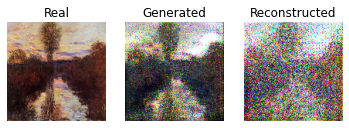

[INFO] Domain B to Domain A


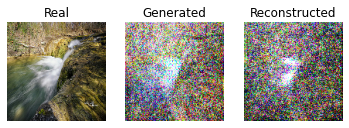

 48%|████▊     | 952/2000 [36:43<40:39,  2.33s/it]

dA_loss: 0.076 dB_loss: 0.067 gAB_loss :3.913 gBA_loss: 3.849


 48%|████▊     | 953/2000 [36:45<40:14,  2.31s/it]

dA_loss: 0.072 dB_loss: 0.086 gAB_loss :4.107 gBA_loss: 3.687


 48%|████▊     | 954/2000 [36:48<40:01,  2.30s/it]

dA_loss: 0.086 dB_loss: 0.084 gAB_loss :3.910 gBA_loss: 3.899


 48%|████▊     | 955/2000 [36:50<39:55,  2.29s/it]

dA_loss: 0.079 dB_loss: 0.088 gAB_loss :4.131 gBA_loss: 3.645


 48%|████▊     | 956/2000 [36:52<39:36,  2.28s/it]

dA_loss: 0.105 dB_loss: 0.074 gAB_loss :3.993 gBA_loss: 3.954


 48%|████▊     | 957/2000 [36:54<39:30,  2.27s/it]

dA_loss: 0.086 dB_loss: 0.072 gAB_loss :4.177 gBA_loss: 3.684


 48%|████▊     | 958/2000 [36:57<39:27,  2.27s/it]

dA_loss: 0.083 dB_loss: 0.059 gAB_loss :3.940 gBA_loss: 3.865


 48%|████▊     | 959/2000 [36:59<39:19,  2.27s/it]

dA_loss: 0.066 dB_loss: 0.061 gAB_loss :4.115 gBA_loss: 3.771


 48%|████▊     | 960/2000 [37:01<39:11,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.057 gAB_loss :3.919 gBA_loss: 3.930


 48%|████▊     | 961/2000 [37:03<39:04,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.063 gAB_loss :4.253 gBA_loss: 3.870


 48%|████▊     | 962/2000 [37:06<39:02,  2.26s/it]

dA_loss: 0.056 dB_loss: 0.075 gAB_loss :3.862 gBA_loss: 3.919


 48%|████▊     | 963/2000 [37:08<38:58,  2.26s/it]

dA_loss: 0.059 dB_loss: 0.134 gAB_loss :4.258 gBA_loss: 3.792


 48%|████▊     | 964/2000 [37:10<38:55,  2.25s/it]

dA_loss: 0.063 dB_loss: 0.150 gAB_loss :3.808 gBA_loss: 4.044


 48%|████▊     | 965/2000 [37:12<38:54,  2.26s/it]

dA_loss: 0.068 dB_loss: 0.153 gAB_loss :4.374 gBA_loss: 3.770


 48%|████▊     | 966/2000 [37:15<38:54,  2.26s/it]

dA_loss: 0.119 dB_loss: 0.184 gAB_loss :3.732 gBA_loss: 4.090


 48%|████▊     | 967/2000 [37:17<38:51,  2.26s/it]

dA_loss: 0.114 dB_loss: 0.138 gAB_loss :4.167 gBA_loss: 3.576


 48%|████▊     | 968/2000 [37:19<38:51,  2.26s/it]

dA_loss: 0.141 dB_loss: 0.211 gAB_loss :3.562 gBA_loss: 3.865


 48%|████▊     | 969/2000 [37:21<38:53,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.256 gAB_loss :4.201 gBA_loss: 3.860


 48%|████▊     | 970/2000 [37:24<38:48,  2.26s/it]

dA_loss: 0.069 dB_loss: 0.166 gAB_loss :3.863 gBA_loss: 3.751


 49%|████▊     | 971/2000 [37:26<38:48,  2.26s/it]

dA_loss: 0.077 dB_loss: 0.095 gAB_loss :3.926 gBA_loss: 4.036


 49%|████▊     | 972/2000 [37:28<38:44,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.084 gAB_loss :4.081 gBA_loss: 3.640


 49%|████▊     | 973/2000 [37:31<38:39,  2.26s/it]

dA_loss: 0.135 dB_loss: 0.081 gAB_loss :3.809 gBA_loss: 4.001


 49%|████▊     | 974/2000 [37:33<38:34,  2.26s/it]

dA_loss: 0.110 dB_loss: 0.093 gAB_loss :4.223 gBA_loss: 3.719


 49%|████▉     | 975/2000 [37:35<38:27,  2.25s/it]

dA_loss: 0.094 dB_loss: 0.161 gAB_loss :3.831 gBA_loss: 3.987


 49%|████▉     | 976/2000 [37:37<38:21,  2.25s/it]

dA_loss: 0.084 dB_loss: 0.259 gAB_loss :4.511 gBA_loss: 3.772


 49%|████▉     | 977/2000 [37:39<38:23,  2.25s/it]

dA_loss: 0.093 dB_loss: 0.208 gAB_loss :3.950 gBA_loss: 4.041


 49%|████▉     | 978/2000 [37:42<38:20,  2.25s/it]

dA_loss: 0.091 dB_loss: 0.185 gAB_loss :4.581 gBA_loss: 3.733


 49%|████▉     | 979/2000 [37:44<38:22,  2.25s/it]

dA_loss: 0.148 dB_loss: 0.256 gAB_loss :3.745 gBA_loss: 3.995


 49%|████▉     | 980/2000 [37:46<38:18,  2.25s/it]

dA_loss: 0.088 dB_loss: 0.294 gAB_loss :4.564 gBA_loss: 3.795


 49%|████▉     | 981/2000 [37:49<38:18,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.271 gAB_loss :3.679 gBA_loss: 3.828


 49%|████▉     | 982/2000 [37:51<38:17,  2.26s/it]

dA_loss: 0.051 dB_loss: 0.187 gAB_loss :4.162 gBA_loss: 3.871


 49%|████▉     | 983/2000 [37:53<38:13,  2.26s/it]

dA_loss: 0.052 dB_loss: 0.140 gAB_loss :3.768 gBA_loss: 3.793


 49%|████▉     | 984/2000 [37:55<38:09,  2.25s/it]

dA_loss: 0.059 dB_loss: 0.095 gAB_loss :3.821 gBA_loss: 3.911


 49%|████▉     | 985/2000 [37:58<38:08,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.081 gAB_loss :3.963 gBA_loss: 3.737


 49%|████▉     | 986/2000 [38:00<38:03,  2.25s/it]

dA_loss: 0.066 dB_loss: 0.057 gAB_loss :3.922 gBA_loss: 4.043


 49%|████▉     | 987/2000 [38:02<38:12,  2.26s/it]

dA_loss: 0.068 dB_loss: 0.046 gAB_loss :3.962 gBA_loss: 3.766


 49%|████▉     | 988/2000 [38:04<38:03,  2.26s/it]

dA_loss: 0.083 dB_loss: 0.051 gAB_loss :4.179 gBA_loss: 4.166


 49%|████▉     | 989/2000 [38:07<37:58,  2.25s/it]

dA_loss: 0.078 dB_loss: 0.094 gAB_loss :4.089 gBA_loss: 3.950


 50%|████▉     | 990/2000 [38:09<37:56,  2.25s/it]

dA_loss: 0.108 dB_loss: 0.182 gAB_loss :4.516 gBA_loss: 4.134


 50%|████▉     | 991/2000 [38:11<37:56,  2.26s/it]

dA_loss: 0.083 dB_loss: 0.181 gAB_loss :3.773 gBA_loss: 3.702


 50%|████▉     | 992/2000 [38:13<37:53,  2.26s/it]

dA_loss: 0.093 dB_loss: 0.207 gAB_loss :4.097 gBA_loss: 3.930


 50%|████▉     | 993/2000 [38:16<37:51,  2.26s/it]

dA_loss: 0.064 dB_loss: 0.125 gAB_loss :3.847 gBA_loss: 3.796


 50%|████▉     | 994/2000 [38:18<37:47,  2.25s/it]

dA_loss: 0.053 dB_loss: 0.077 gAB_loss :3.845 gBA_loss: 3.845


 50%|████▉     | 995/2000 [38:20<37:44,  2.25s/it]

dA_loss: 0.044 dB_loss: 0.066 gAB_loss :4.013 gBA_loss: 3.887


 50%|████▉     | 996/2000 [38:22<37:49,  2.26s/it]

dA_loss: 0.048 dB_loss: 0.059 gAB_loss :3.941 gBA_loss: 4.047


 50%|████▉     | 997/2000 [38:25<37:45,  2.26s/it]

dA_loss: 0.048 dB_loss: 0.060 gAB_loss :4.161 gBA_loss: 3.823


 50%|████▉     | 998/2000 [38:27<37:41,  2.26s/it]

dA_loss: 0.095 dB_loss: 0.072 gAB_loss :3.890 gBA_loss: 4.268


 50%|████▉     | 999/2000 [38:29<37:35,  2.25s/it]

dA_loss: 0.137 dB_loss: 0.093 gAB_loss :4.213 gBA_loss: 3.559


 50%|█████     | 1000/2000 [38:31<37:32,  2.25s/it]

dA_loss: 0.277 dB_loss: 0.093 gAB_loss :3.802 gBA_loss: 4.010
dA_loss: 0.147 dB_loss: 0.100 gAB_loss :4.167 gBA_loss: 3.876
[INFO] Domain A to Domain B


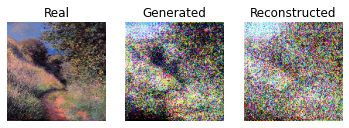

[INFO] Domain B to Domain A


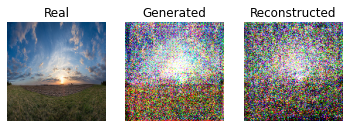

 50%|█████     | 1002/2000 [38:36<38:49,  2.33s/it]

dA_loss: 0.092 dB_loss: 0.065 gAB_loss :3.933 gBA_loss: 3.653


 50%|█████     | 1003/2000 [38:39<38:25,  2.31s/it]

dA_loss: 0.090 dB_loss: 0.073 gAB_loss :4.095 gBA_loss: 3.892


 50%|█████     | 1004/2000 [38:41<38:03,  2.29s/it]

dA_loss: 0.075 dB_loss: 0.067 gAB_loss :3.792 gBA_loss: 3.725


 50%|█████     | 1005/2000 [38:43<37:49,  2.28s/it]

dA_loss: 0.060 dB_loss: 0.080 gAB_loss :4.085 gBA_loss: 3.925


 50%|█████     | 1006/2000 [38:45<37:39,  2.27s/it]

dA_loss: 0.044 dB_loss: 0.078 gAB_loss :3.799 gBA_loss: 3.920


 50%|█████     | 1007/2000 [38:48<37:31,  2.27s/it]

dA_loss: 0.045 dB_loss: 0.084 gAB_loss :4.184 gBA_loss: 3.908


 50%|█████     | 1008/2000 [38:50<37:27,  2.27s/it]

dA_loss: 0.044 dB_loss: 0.115 gAB_loss :3.788 gBA_loss: 3.835


 50%|█████     | 1009/2000 [38:52<37:20,  2.26s/it]

dA_loss: 0.046 dB_loss: 0.202 gAB_loss :4.391 gBA_loss: 3.873


 50%|█████     | 1010/2000 [38:54<37:19,  2.26s/it]

dA_loss: 0.042 dB_loss: 0.216 gAB_loss :3.759 gBA_loss: 3.817


 51%|█████     | 1011/2000 [38:57<37:17,  2.26s/it]

dA_loss: 0.045 dB_loss: 0.183 gAB_loss :4.798 gBA_loss: 3.962


 51%|█████     | 1012/2000 [38:59<37:15,  2.26s/it]

dA_loss: 0.056 dB_loss: 0.369 gAB_loss :3.537 gBA_loss: 3.752


 51%|█████     | 1013/2000 [39:01<37:09,  2.26s/it]

dA_loss: 0.083 dB_loss: 0.435 gAB_loss :5.538 gBA_loss: 4.257


 51%|█████     | 1014/2000 [39:03<37:05,  2.26s/it]

dA_loss: 0.159 dB_loss: 1.130 gAB_loss :3.348 gBA_loss: 3.635


 51%|█████     | 1015/2000 [39:06<37:01,  2.26s/it]

dA_loss: 0.393 dB_loss: 1.115 gAB_loss :5.656 gBA_loss: 4.073


 51%|█████     | 1016/2000 [39:08<36:57,  2.25s/it]

dA_loss: 0.179 dB_loss: 1.184 gAB_loss :3.419 gBA_loss: 3.856


 51%|█████     | 1017/2000 [39:10<36:55,  2.25s/it]

dA_loss: 0.099 dB_loss: 0.880 gAB_loss :4.062 gBA_loss: 3.609


 51%|█████     | 1018/2000 [39:12<36:50,  2.25s/it]

dA_loss: 0.096 dB_loss: 0.417 gAB_loss :3.987 gBA_loss: 3.841


 51%|█████     | 1019/2000 [39:15<36:50,  2.25s/it]

dA_loss: 0.081 dB_loss: 0.490 gAB_loss :3.443 gBA_loss: 3.675


 51%|█████     | 1020/2000 [39:17<36:46,  2.25s/it]

dA_loss: 0.052 dB_loss: 0.443 gAB_loss :3.555 gBA_loss: 3.820


 51%|█████     | 1021/2000 [39:19<36:47,  2.25s/it]

dA_loss: 0.041 dB_loss: 0.398 gAB_loss :3.803 gBA_loss: 3.896


 51%|█████     | 1022/2000 [39:21<36:44,  2.25s/it]

dA_loss: 0.055 dB_loss: 0.378 gAB_loss :3.518 gBA_loss: 4.070


 51%|█████     | 1023/2000 [39:24<36:44,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.283 gAB_loss :3.511 gBA_loss: 3.730


 51%|█████     | 1024/2000 [39:26<36:44,  2.26s/it]

dA_loss: 0.097 dB_loss: 0.198 gAB_loss :3.614 gBA_loss: 4.081


 51%|█████▏    | 1025/2000 [39:28<36:41,  2.26s/it]

dA_loss: 0.083 dB_loss: 0.171 gAB_loss :3.626 gBA_loss: 3.721


 51%|█████▏    | 1026/2000 [39:30<36:37,  2.26s/it]

dA_loss: 0.108 dB_loss: 0.126 gAB_loss :3.792 gBA_loss: 4.018


 51%|█████▏    | 1027/2000 [39:33<36:36,  2.26s/it]

dA_loss: 0.067 dB_loss: 0.112 gAB_loss :3.802 gBA_loss: 3.835


 51%|█████▏    | 1028/2000 [39:35<36:34,  2.26s/it]

dA_loss: 0.051 dB_loss: 0.098 gAB_loss :3.704 gBA_loss: 3.862


 51%|█████▏    | 1029/2000 [39:37<36:38,  2.26s/it]

dA_loss: 0.040 dB_loss: 0.114 gAB_loss :3.905 gBA_loss: 3.816


 52%|█████▏    | 1030/2000 [39:39<36:30,  2.26s/it]

dA_loss: 0.041 dB_loss: 0.120 gAB_loss :3.482 gBA_loss: 3.878


 52%|█████▏    | 1031/2000 [39:42<36:29,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.168 gAB_loss :3.957 gBA_loss: 3.836


 52%|█████▏    | 1032/2000 [39:44<36:24,  2.26s/it]

dA_loss: 0.034 dB_loss: 0.153 gAB_loss :3.565 gBA_loss: 3.968


 52%|█████▏    | 1033/2000 [39:46<36:21,  2.26s/it]

dA_loss: 0.040 dB_loss: 0.160 gAB_loss :3.880 gBA_loss: 4.043


 52%|█████▏    | 1034/2000 [39:48<36:19,  2.26s/it]

dA_loss: 0.043 dB_loss: 0.126 gAB_loss :3.725 gBA_loss: 3.869


 52%|█████▏    | 1035/2000 [39:51<36:16,  2.26s/it]

dA_loss: 0.050 dB_loss: 0.117 gAB_loss :3.923 gBA_loss: 4.112


 52%|█████▏    | 1036/2000 [39:53<36:12,  2.25s/it]

dA_loss: 0.061 dB_loss: 0.101 gAB_loss :3.852 gBA_loss: 3.650


 52%|█████▏    | 1037/2000 [39:55<36:13,  2.26s/it]

dA_loss: 0.119 dB_loss: 0.101 gAB_loss :3.883 gBA_loss: 4.098


 52%|█████▏    | 1038/2000 [39:58<36:19,  2.27s/it]

dA_loss: 0.105 dB_loss: 0.092 gAB_loss :3.830 gBA_loss: 3.646


 52%|█████▏    | 1039/2000 [40:00<36:13,  2.26s/it]

dA_loss: 0.098 dB_loss: 0.094 gAB_loss :3.963 gBA_loss: 4.016


 52%|█████▏    | 1040/2000 [40:02<36:09,  2.26s/it]

dA_loss: 0.095 dB_loss: 0.093 gAB_loss :3.658 gBA_loss: 3.641


 52%|█████▏    | 1041/2000 [40:04<36:03,  2.26s/it]

dA_loss: 0.112 dB_loss: 0.135 gAB_loss :4.171 gBA_loss: 4.157


 52%|█████▏    | 1042/2000 [40:07<35:56,  2.25s/it]

dA_loss: 0.103 dB_loss: 0.143 gAB_loss :3.578 gBA_loss: 3.876


 52%|█████▏    | 1043/2000 [40:09<35:57,  2.25s/it]

dA_loss: 0.100 dB_loss: 0.239 gAB_loss :3.956 gBA_loss: 4.173


 52%|█████▏    | 1044/2000 [40:11<35:57,  2.26s/it]

dA_loss: 0.094 dB_loss: 0.110 gAB_loss :3.809 gBA_loss: 3.639


 52%|█████▏    | 1045/2000 [40:13<35:49,  2.25s/it]

dA_loss: 0.128 dB_loss: 0.071 gAB_loss :3.640 gBA_loss: 3.965


 52%|█████▏    | 1046/2000 [40:16<35:49,  2.25s/it]

dA_loss: 0.080 dB_loss: 0.073 gAB_loss :3.922 gBA_loss: 3.710


 52%|█████▏    | 1047/2000 [40:18<35:54,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.080 gAB_loss :3.722 gBA_loss: 3.810


 52%|█████▏    | 1048/2000 [40:20<35:56,  2.27s/it]

dA_loss: 0.040 dB_loss: 0.100 gAB_loss :4.059 gBA_loss: 3.806


 52%|█████▏    | 1049/2000 [40:22<35:52,  2.26s/it]

dA_loss: 0.045 dB_loss: 0.107 gAB_loss :3.745 gBA_loss: 4.058


 52%|█████▎    | 1050/2000 [40:25<35:43,  2.26s/it]

dA_loss: 0.058 dB_loss: 0.104 gAB_loss :4.136 gBA_loss: 3.778
dA_loss: 0.152 dB_loss: 0.081 gAB_loss :3.782 gBA_loss: 4.145
[INFO] Domain A to Domain B


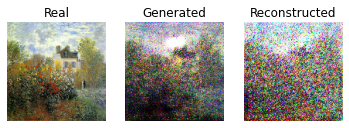

[INFO] Domain B to Domain A


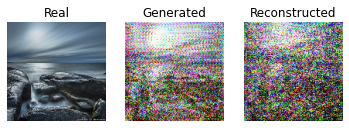

 53%|█████▎    | 1052/2000 [40:29<36:54,  2.34s/it]

dA_loss: 0.106 dB_loss: 0.118 gAB_loss :3.990 gBA_loss: 3.695


 53%|█████▎    | 1053/2000 [40:32<36:26,  2.31s/it]

dA_loss: 0.069 dB_loss: 0.079 gAB_loss :3.759 gBA_loss: 3.859


 53%|█████▎    | 1054/2000 [40:34<36:08,  2.29s/it]

dA_loss: 0.047 dB_loss: 0.066 gAB_loss :3.854 gBA_loss: 3.914


 53%|█████▎    | 1055/2000 [40:36<35:54,  2.28s/it]

dA_loss: 0.047 dB_loss: 0.055 gAB_loss :3.789 gBA_loss: 3.759


 53%|█████▎    | 1056/2000 [40:38<35:45,  2.27s/it]

dA_loss: 0.072 dB_loss: 0.049 gAB_loss :3.980 gBA_loss: 4.077


 53%|█████▎    | 1057/2000 [40:41<35:40,  2.27s/it]

dA_loss: 0.079 dB_loss: 0.076 gAB_loss :3.860 gBA_loss: 3.732


 53%|█████▎    | 1058/2000 [40:43<35:32,  2.26s/it]

dA_loss: 0.136 dB_loss: 0.103 gAB_loss :4.370 gBA_loss: 4.076


 53%|█████▎    | 1059/2000 [40:45<35:22,  2.26s/it]

dA_loss: 0.080 dB_loss: 0.133 gAB_loss :3.652 gBA_loss: 3.810


 53%|█████▎    | 1060/2000 [40:47<35:15,  2.25s/it]

dA_loss: 0.059 dB_loss: 0.229 gAB_loss :4.040 gBA_loss: 3.888


 53%|█████▎    | 1061/2000 [40:50<35:13,  2.25s/it]

dA_loss: 0.046 dB_loss: 0.146 gAB_loss :3.735 gBA_loss: 3.919


 53%|█████▎    | 1062/2000 [40:52<35:08,  2.25s/it]

dA_loss: 0.043 dB_loss: 0.086 gAB_loss :3.728 gBA_loss: 3.872


 53%|█████▎    | 1063/2000 [40:54<35:08,  2.25s/it]

dA_loss: 0.062 dB_loss: 0.078 gAB_loss :3.967 gBA_loss: 4.127


 53%|█████▎    | 1064/2000 [40:56<35:07,  2.25s/it]

dA_loss: 0.076 dB_loss: 0.088 gAB_loss :3.749 gBA_loss: 3.660


 53%|█████▎    | 1065/2000 [40:59<35:10,  2.26s/it]

dA_loss: 0.121 dB_loss: 0.102 gAB_loss :4.057 gBA_loss: 4.003


 53%|█████▎    | 1066/2000 [41:01<35:09,  2.26s/it]

dA_loss: 0.086 dB_loss: 0.093 gAB_loss :3.743 gBA_loss: 3.807


 53%|█████▎    | 1067/2000 [41:03<35:06,  2.26s/it]

dA_loss: 0.054 dB_loss: 0.100 gAB_loss :4.034 gBA_loss: 3.989


 53%|█████▎    | 1068/2000 [41:06<35:04,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.080 gAB_loss :3.889 gBA_loss: 3.780


 53%|█████▎    | 1069/2000 [41:08<35:01,  2.26s/it]

dA_loss: 0.069 dB_loss: 0.076 gAB_loss :4.063 gBA_loss: 4.124


 54%|█████▎    | 1070/2000 [41:10<34:56,  2.25s/it]

dA_loss: 0.085 dB_loss: 0.062 gAB_loss :3.895 gBA_loss: 3.667


 54%|█████▎    | 1071/2000 [41:12<34:53,  2.25s/it]

dA_loss: 0.142 dB_loss: 0.082 gAB_loss :4.086 gBA_loss: 4.037


 54%|█████▎    | 1072/2000 [41:15<34:49,  2.25s/it]

dA_loss: 0.083 dB_loss: 0.078 gAB_loss :3.674 gBA_loss: 3.719


 54%|█████▎    | 1073/2000 [41:17<34:44,  2.25s/it]

dA_loss: 0.064 dB_loss: 0.109 gAB_loss :4.006 gBA_loss: 3.819


 54%|█████▎    | 1074/2000 [41:19<34:45,  2.25s/it]

dA_loss: 0.049 dB_loss: 0.089 gAB_loss :3.665 gBA_loss: 3.719


 54%|█████▍    | 1075/2000 [41:21<34:41,  2.25s/it]

dA_loss: 0.042 dB_loss: 0.087 gAB_loss :3.941 gBA_loss: 3.785


 54%|█████▍    | 1076/2000 [41:24<34:40,  2.25s/it]

dA_loss: 0.037 dB_loss: 0.066 gAB_loss :3.873 gBA_loss: 3.823


 54%|█████▍    | 1077/2000 [41:26<34:37,  2.25s/it]

dA_loss: 0.034 dB_loss: 0.059 gAB_loss :4.025 gBA_loss: 3.913


 54%|█████▍    | 1078/2000 [41:28<34:35,  2.25s/it]

dA_loss: 0.031 dB_loss: 0.059 gAB_loss :4.016 gBA_loss: 3.995


 54%|█████▍    | 1079/2000 [41:30<34:29,  2.25s/it]

dA_loss: 0.041 dB_loss: 0.071 gAB_loss :4.208 gBA_loss: 4.220


 54%|█████▍    | 1080/2000 [41:33<34:32,  2.25s/it]

dA_loss: 0.079 dB_loss: 0.089 gAB_loss :3.719 gBA_loss: 3.646


 54%|█████▍    | 1081/2000 [41:35<34:30,  2.25s/it]

dA_loss: 0.210 dB_loss: 0.187 gAB_loss :4.129 gBA_loss: 4.261


 54%|█████▍    | 1082/2000 [41:37<34:27,  2.25s/it]

dA_loss: 0.179 dB_loss: 0.107 gAB_loss :3.746 gBA_loss: 3.690


 54%|█████▍    | 1083/2000 [41:39<34:23,  2.25s/it]

dA_loss: 0.110 dB_loss: 0.061 gAB_loss :3.788 gBA_loss: 4.220


 54%|█████▍    | 1084/2000 [41:42<34:27,  2.26s/it]

dA_loss: 0.185 dB_loss: 0.043 gAB_loss :3.933 gBA_loss: 3.261


 54%|█████▍    | 1085/2000 [41:44<34:24,  2.26s/it]

dA_loss: 0.313 dB_loss: 0.048 gAB_loss :3.711 gBA_loss: 4.100


 54%|█████▍    | 1086/2000 [41:46<34:17,  2.25s/it]

dA_loss: 0.195 dB_loss: 0.044 gAB_loss :4.120 gBA_loss: 3.730


 54%|█████▍    | 1087/2000 [41:48<34:15,  2.25s/it]

dA_loss: 0.102 dB_loss: 0.087 gAB_loss :3.748 gBA_loss: 3.702


 54%|█████▍    | 1088/2000 [41:51<34:13,  2.25s/it]

dA_loss: 0.082 dB_loss: 0.149 gAB_loss :4.383 gBA_loss: 3.966


 54%|█████▍    | 1089/2000 [41:53<34:08,  2.25s/it]

dA_loss: 0.078 dB_loss: 0.102 gAB_loss :3.834 gBA_loss: 3.596


 55%|█████▍    | 1090/2000 [41:55<34:15,  2.26s/it]

dA_loss: 0.087 dB_loss: 0.086 gAB_loss :3.903 gBA_loss: 3.925


 55%|█████▍    | 1091/2000 [41:57<34:18,  2.26s/it]

dA_loss: 0.058 dB_loss: 0.081 gAB_loss :3.873 gBA_loss: 3.767


 55%|█████▍    | 1092/2000 [42:00<34:15,  2.26s/it]

dA_loss: 0.049 dB_loss: 0.058 gAB_loss :3.780 gBA_loss: 3.848


 55%|█████▍    | 1093/2000 [42:02<34:13,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.050 gAB_loss :3.885 gBA_loss: 3.840


 55%|█████▍    | 1094/2000 [42:04<34:07,  2.26s/it]

dA_loss: 0.042 dB_loss: 0.041 gAB_loss :3.810 gBA_loss: 3.953


 55%|█████▍    | 1095/2000 [42:06<34:06,  2.26s/it]

dA_loss: 0.040 dB_loss: 0.040 gAB_loss :3.968 gBA_loss: 3.796


 55%|█████▍    | 1096/2000 [42:09<34:02,  2.26s/it]

dA_loss: 0.054 dB_loss: 0.032 gAB_loss :4.110 gBA_loss: 4.051


 55%|█████▍    | 1097/2000 [42:11<33:57,  2.26s/it]

dA_loss: 0.068 dB_loss: 0.045 gAB_loss :3.802 gBA_loss: 3.618


 55%|█████▍    | 1098/2000 [42:13<33:52,  2.25s/it]

dA_loss: 0.136 dB_loss: 0.095 gAB_loss :4.314 gBA_loss: 4.007


 55%|█████▍    | 1099/2000 [42:15<33:52,  2.26s/it]

dA_loss: 0.088 dB_loss: 0.099 gAB_loss :3.591 gBA_loss: 3.775


 55%|█████▌    | 1100/2000 [42:18<33:49,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.169 gAB_loss :4.001 gBA_loss: 3.848
dA_loss: 0.039 dB_loss: 0.095 gAB_loss :3.768 gBA_loss: 3.816
[INFO] Domain A to Domain B


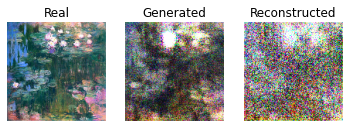

[INFO] Domain B to Domain A


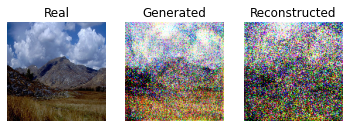

 55%|█████▌    | 1102/2000 [42:23<34:58,  2.34s/it]

dA_loss: 0.035 dB_loss: 0.056 gAB_loss :3.710 gBA_loss: 3.785


 55%|█████▌    | 1103/2000 [42:25<34:31,  2.31s/it]

dA_loss: 0.033 dB_loss: 0.058 gAB_loss :3.937 gBA_loss: 3.893


 55%|█████▌    | 1104/2000 [42:27<34:09,  2.29s/it]

dA_loss: 0.036 dB_loss: 0.061 gAB_loss :3.704 gBA_loss: 3.922


 55%|█████▌    | 1105/2000 [42:29<33:55,  2.27s/it]

dA_loss: 0.040 dB_loss: 0.090 gAB_loss :4.083 gBA_loss: 3.865


 55%|█████▌    | 1106/2000 [42:32<33:47,  2.27s/it]

dA_loss: 0.057 dB_loss: 0.079 gAB_loss :3.818 gBA_loss: 4.211


 55%|█████▌    | 1107/2000 [42:34<33:42,  2.26s/it]

dA_loss: 0.094 dB_loss: 0.076 gAB_loss :4.133 gBA_loss: 3.777


 55%|█████▌    | 1108/2000 [42:36<33:39,  2.26s/it]

dA_loss: 0.194 dB_loss: 0.050 gAB_loss :3.915 gBA_loss: 4.196


 55%|█████▌    | 1109/2000 [42:38<33:43,  2.27s/it]

dA_loss: 0.120 dB_loss: 0.037 gAB_loss :3.870 gBA_loss: 3.829


 56%|█████▌    | 1110/2000 [42:41<33:34,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.040 gAB_loss :3.984 gBA_loss: 3.845


 56%|█████▌    | 1111/2000 [42:43<33:31,  2.26s/it]

dA_loss: 0.052 dB_loss: 0.051 gAB_loss :3.646 gBA_loss: 3.732


 56%|█████▌    | 1112/2000 [42:45<33:23,  2.26s/it]

dA_loss: 0.044 dB_loss: 0.141 gAB_loss :4.236 gBA_loss: 3.765


 56%|█████▌    | 1113/2000 [42:47<33:23,  2.26s/it]

dA_loss: 0.038 dB_loss: 0.179 gAB_loss :3.556 gBA_loss: 3.806


 56%|█████▌    | 1114/2000 [42:50<33:20,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.277 gAB_loss :3.995 gBA_loss: 3.869


 56%|█████▌    | 1115/2000 [42:52<33:14,  2.25s/it]

dA_loss: 0.043 dB_loss: 0.125 gAB_loss :3.844 gBA_loss: 3.803


 56%|█████▌    | 1116/2000 [42:54<33:18,  2.26s/it]

dA_loss: 0.065 dB_loss: 0.074 gAB_loss :3.709 gBA_loss: 4.095


 56%|█████▌    | 1117/2000 [42:56<33:12,  2.26s/it]

dA_loss: 0.077 dB_loss: 0.092 gAB_loss :3.979 gBA_loss: 3.694


 56%|█████▌    | 1118/2000 [42:59<33:10,  2.26s/it]

dA_loss: 0.121 dB_loss: 0.083 gAB_loss :3.663 gBA_loss: 3.985


 56%|█████▌    | 1119/2000 [43:01<33:06,  2.25s/it]

dA_loss: 0.081 dB_loss: 0.112 gAB_loss :3.946 gBA_loss: 3.655


 56%|█████▌    | 1120/2000 [43:03<33:03,  2.25s/it]

dA_loss: 0.051 dB_loss: 0.092 gAB_loss :3.798 gBA_loss: 3.886


 56%|█████▌    | 1121/2000 [43:05<32:59,  2.25s/it]

dA_loss: 0.044 dB_loss: 0.064 gAB_loss :4.044 gBA_loss: 3.726


 56%|█████▌    | 1122/2000 [43:08<33:00,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.059 gAB_loss :3.853 gBA_loss: 4.064


 56%|█████▌    | 1123/2000 [43:10<33:05,  2.26s/it]

dA_loss: 0.073 dB_loss: 0.093 gAB_loss :4.068 gBA_loss: 3.650


 56%|█████▌    | 1124/2000 [43:12<33:02,  2.26s/it]

dA_loss: 0.118 dB_loss: 0.104 gAB_loss :3.707 gBA_loss: 4.025


 56%|█████▋    | 1125/2000 [43:14<33:07,  2.27s/it]

dA_loss: 0.084 dB_loss: 0.125 gAB_loss :4.123 gBA_loss: 3.599


 56%|█████▋    | 1126/2000 [43:17<33:06,  2.27s/it]

dA_loss: 0.074 dB_loss: 0.129 gAB_loss :3.579 gBA_loss: 3.754


 56%|█████▋    | 1127/2000 [43:19<33:00,  2.27s/it]

dA_loss: 0.046 dB_loss: 0.144 gAB_loss :3.978 gBA_loss: 3.753


 56%|█████▋    | 1128/2000 [43:21<32:56,  2.27s/it]

dA_loss: 0.030 dB_loss: 0.169 gAB_loss :3.503 gBA_loss: 3.718


 56%|█████▋    | 1129/2000 [43:24<32:53,  2.27s/it]

dA_loss: 0.049 dB_loss: 0.150 gAB_loss :3.989 gBA_loss: 4.149


 56%|█████▋    | 1130/2000 [43:26<32:47,  2.26s/it]

dA_loss: 0.106 dB_loss: 0.101 gAB_loss :3.812 gBA_loss: 3.565


 57%|█████▋    | 1131/2000 [43:28<32:42,  2.26s/it]

dA_loss: 0.283 dB_loss: 0.055 gAB_loss :3.832 gBA_loss: 4.167


 57%|█████▋    | 1132/2000 [43:30<32:36,  2.25s/it]

dA_loss: 0.248 dB_loss: 0.045 gAB_loss :3.891 gBA_loss: 3.578


 57%|█████▋    | 1133/2000 [43:33<32:31,  2.25s/it]

dA_loss: 0.137 dB_loss: 0.036 gAB_loss :3.861 gBA_loss: 4.155


 57%|█████▋    | 1134/2000 [43:35<32:27,  2.25s/it]

dA_loss: 0.199 dB_loss: 0.041 gAB_loss :4.049 gBA_loss: 3.328


 57%|█████▋    | 1135/2000 [43:37<32:21,  2.24s/it]

dA_loss: 0.276 dB_loss: 0.067 gAB_loss :3.827 gBA_loss: 3.926


 57%|█████▋    | 1136/2000 [43:39<32:24,  2.25s/it]

dA_loss: 0.121 dB_loss: 0.150 gAB_loss :4.326 gBA_loss: 3.725


 57%|█████▋    | 1137/2000 [43:42<32:29,  2.26s/it]

dA_loss: 0.072 dB_loss: 0.171 gAB_loss :3.605 gBA_loss: 3.604


 57%|█████▋    | 1138/2000 [43:44<32:25,  2.26s/it]

dA_loss: 0.066 dB_loss: 0.222 gAB_loss :4.023 gBA_loss: 3.831


 57%|█████▋    | 1139/2000 [43:46<32:24,  2.26s/it]

dA_loss: 0.060 dB_loss: 0.103 gAB_loss :3.858 gBA_loss: 3.741


 57%|█████▋    | 1140/2000 [43:48<32:24,  2.26s/it]

dA_loss: 0.047 dB_loss: 0.065 gAB_loss :3.645 gBA_loss: 3.830


 57%|█████▋    | 1141/2000 [43:51<32:22,  2.26s/it]

dA_loss: 0.060 dB_loss: 0.086 gAB_loss :3.961 gBA_loss: 4.059


 57%|█████▋    | 1142/2000 [43:53<32:21,  2.26s/it]

dA_loss: 0.102 dB_loss: 0.086 gAB_loss :3.577 gBA_loss: 3.519


 57%|█████▋    | 1143/2000 [43:55<32:21,  2.27s/it]

dA_loss: 0.200 dB_loss: 0.119 gAB_loss :4.043 gBA_loss: 4.008


 57%|█████▋    | 1144/2000 [43:57<32:16,  2.26s/it]

dA_loss: 0.093 dB_loss: 0.116 gAB_loss :3.615 gBA_loss: 3.766


 57%|█████▋    | 1145/2000 [44:00<32:10,  2.26s/it]

dA_loss: 0.052 dB_loss: 0.109 gAB_loss :4.124 gBA_loss: 3.728


 57%|█████▋    | 1146/2000 [44:02<32:11,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.107 gAB_loss :3.726 gBA_loss: 3.806


 57%|█████▋    | 1147/2000 [44:04<32:01,  2.25s/it]

dA_loss: 0.039 dB_loss: 0.120 gAB_loss :3.988 gBA_loss: 3.695


 57%|█████▋    | 1148/2000 [44:06<31:55,  2.25s/it]

dA_loss: 0.030 dB_loss: 0.082 gAB_loss :3.855 gBA_loss: 3.791


 57%|█████▋    | 1149/2000 [44:09<31:52,  2.25s/it]

dA_loss: 0.034 dB_loss: 0.058 gAB_loss :3.801 gBA_loss: 3.918


 57%|█████▊    | 1150/2000 [44:11<32:00,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.048 gAB_loss :3.993 gBA_loss: 3.893
dA_loss: 0.054 dB_loss: 0.045 gAB_loss :3.826 gBA_loss: 4.125
[INFO] Domain A to Domain B


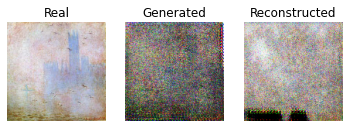

[INFO] Domain B to Domain A


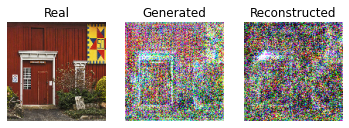

 58%|█████▊    | 1152/2000 [44:16<33:06,  2.34s/it]

dA_loss: 0.083 dB_loss: 0.052 gAB_loss :4.139 gBA_loss: 3.656


 58%|█████▊    | 1153/2000 [44:18<32:45,  2.32s/it]

dA_loss: 0.154 dB_loss: 0.065 gAB_loss :3.795 gBA_loss: 3.966


 58%|█████▊    | 1154/2000 [44:20<32:25,  2.30s/it]

dA_loss: 0.089 dB_loss: 0.123 gAB_loss :4.186 gBA_loss: 3.771


 58%|█████▊    | 1155/2000 [44:23<32:13,  2.29s/it]

dA_loss: 0.043 dB_loss: 0.131 gAB_loss :3.541 gBA_loss: 3.708


 58%|█████▊    | 1156/2000 [44:25<32:05,  2.28s/it]

dA_loss: 0.047 dB_loss: 0.192 gAB_loss :4.014 gBA_loss: 3.952


 58%|█████▊    | 1157/2000 [44:27<31:55,  2.27s/it]

dA_loss: 0.061 dB_loss: 0.111 gAB_loss :3.708 gBA_loss: 3.679


 58%|█████▊    | 1158/2000 [44:29<31:48,  2.27s/it]

dA_loss: 0.097 dB_loss: 0.059 gAB_loss :3.865 gBA_loss: 4.029


 58%|█████▊    | 1159/2000 [44:32<31:43,  2.26s/it]

dA_loss: 0.079 dB_loss: 0.055 gAB_loss :3.830 gBA_loss: 3.734


 58%|█████▊    | 1160/2000 [44:34<31:38,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.047 gAB_loss :3.863 gBA_loss: 3.901


 58%|█████▊    | 1161/2000 [44:36<31:30,  2.25s/it]

dA_loss: 0.045 dB_loss: 0.051 gAB_loss :3.892 gBA_loss: 3.728


 58%|█████▊    | 1162/2000 [44:38<31:27,  2.25s/it]

dA_loss: 0.036 dB_loss: 0.074 gAB_loss :4.232 gBA_loss: 3.797


 58%|█████▊    | 1163/2000 [44:41<31:34,  2.26s/it]

dA_loss: 0.035 dB_loss: 0.123 gAB_loss :3.584 gBA_loss: 3.804


 58%|█████▊    | 1164/2000 [44:43<31:34,  2.27s/it]

dA_loss: 0.033 dB_loss: 0.279 gAB_loss :4.215 gBA_loss: 3.715


 58%|█████▊    | 1165/2000 [44:45<31:27,  2.26s/it]

dA_loss: 0.050 dB_loss: 0.248 gAB_loss :3.606 gBA_loss: 4.074


 58%|█████▊    | 1166/2000 [44:47<31:22,  2.26s/it]

dA_loss: 0.112 dB_loss: 0.141 gAB_loss :4.212 gBA_loss: 3.494


 58%|█████▊    | 1167/2000 [44:50<31:21,  2.26s/it]

dA_loss: 0.282 dB_loss: 0.155 gAB_loss :3.454 gBA_loss: 3.993


 58%|█████▊    | 1168/2000 [44:52<31:17,  2.26s/it]

dA_loss: 0.153 dB_loss: 0.171 gAB_loss :4.039 gBA_loss: 3.656


 58%|█████▊    | 1169/2000 [44:54<31:16,  2.26s/it]

dA_loss: 0.063 dB_loss: 0.169 gAB_loss :3.691 gBA_loss: 3.694


 58%|█████▊    | 1170/2000 [44:56<31:16,  2.26s/it]

dA_loss: 0.057 dB_loss: 0.138 gAB_loss :3.873 gBA_loss: 3.732


 59%|█████▊    | 1171/2000 [44:59<31:15,  2.26s/it]

dA_loss: 0.054 dB_loss: 0.113 gAB_loss :3.680 gBA_loss: 3.524


 59%|█████▊    | 1172/2000 [45:01<31:08,  2.26s/it]

dA_loss: 0.047 dB_loss: 0.093 gAB_loss :3.748 gBA_loss: 3.835


 59%|█████▊    | 1173/2000 [45:03<31:04,  2.25s/it]

dA_loss: 0.057 dB_loss: 0.090 gAB_loss :3.861 gBA_loss: 3.674


 59%|█████▊    | 1174/2000 [45:05<31:03,  2.26s/it]

dA_loss: 0.071 dB_loss: 0.086 gAB_loss :3.840 gBA_loss: 4.023


 59%|█████▉    | 1175/2000 [45:08<30:57,  2.25s/it]

dA_loss: 0.058 dB_loss: 0.084 gAB_loss :4.006 gBA_loss: 3.794


 59%|█████▉    | 1176/2000 [45:10<30:57,  2.25s/it]

dA_loss: 0.054 dB_loss: 0.086 gAB_loss :4.036 gBA_loss: 3.963


 59%|█████▉    | 1177/2000 [45:12<30:56,  2.26s/it]

dA_loss: 0.035 dB_loss: 0.074 gAB_loss :4.122 gBA_loss: 3.870


 59%|█████▉    | 1178/2000 [45:15<30:56,  2.26s/it]

dA_loss: 0.040 dB_loss: 0.068 gAB_loss :3.962 gBA_loss: 3.603


 59%|█████▉    | 1179/2000 [45:17<30:54,  2.26s/it]

dA_loss: 0.060 dB_loss: 0.064 gAB_loss :3.827 gBA_loss: 3.980


 59%|█████▉    | 1180/2000 [45:19<30:51,  2.26s/it]

dA_loss: 0.072 dB_loss: 0.065 gAB_loss :3.961 gBA_loss: 3.567


 59%|█████▉    | 1181/2000 [45:21<30:46,  2.25s/it]

dA_loss: 0.114 dB_loss: 0.064 gAB_loss :3.633 gBA_loss: 3.959


 59%|█████▉    | 1182/2000 [45:24<30:45,  2.26s/it]

dA_loss: 0.062 dB_loss: 0.122 gAB_loss :4.193 gBA_loss: 3.830


 59%|█████▉    | 1183/2000 [45:26<30:41,  2.25s/it]

dA_loss: 0.040 dB_loss: 0.200 gAB_loss :3.570 gBA_loss: 3.685


 59%|█████▉    | 1184/2000 [45:28<30:40,  2.26s/it]

dA_loss: 0.039 dB_loss: 0.342 gAB_loss :4.083 gBA_loss: 3.765


 59%|█████▉    | 1185/2000 [45:30<30:35,  2.25s/it]

dA_loss: 0.039 dB_loss: 0.210 gAB_loss :3.699 gBA_loss: 3.632


 59%|█████▉    | 1186/2000 [45:33<30:34,  2.25s/it]

dA_loss: 0.072 dB_loss: 0.115 gAB_loss :3.753 gBA_loss: 4.112


 59%|█████▉    | 1187/2000 [45:35<30:29,  2.25s/it]

dA_loss: 0.137 dB_loss: 0.097 gAB_loss :3.837 gBA_loss: 3.508


 59%|█████▉    | 1188/2000 [45:37<30:23,  2.25s/it]

dA_loss: 0.284 dB_loss: 0.069 gAB_loss :3.621 gBA_loss: 3.935


 59%|█████▉    | 1189/2000 [45:39<30:24,  2.25s/it]

dA_loss: 0.130 dB_loss: 0.057 gAB_loss :3.852 gBA_loss: 3.878


 60%|█████▉    | 1190/2000 [45:42<30:28,  2.26s/it]

dA_loss: 0.061 dB_loss: 0.055 gAB_loss :3.827 gBA_loss: 3.665


 60%|█████▉    | 1191/2000 [45:44<30:30,  2.26s/it]

dA_loss: 0.055 dB_loss: 0.094 gAB_loss :4.160 gBA_loss: 3.835


 60%|█████▉    | 1192/2000 [45:46<30:29,  2.26s/it]

dA_loss: 0.054 dB_loss: 0.144 gAB_loss :3.596 gBA_loss: 3.562


 60%|█████▉    | 1193/2000 [45:48<30:28,  2.27s/it]

dA_loss: 0.060 dB_loss: 0.255 gAB_loss :4.055 gBA_loss: 3.877


 60%|█████▉    | 1194/2000 [45:51<30:20,  2.26s/it]

dA_loss: 0.064 dB_loss: 0.175 gAB_loss :3.671 gBA_loss: 3.615


 60%|█████▉    | 1195/2000 [45:53<30:14,  2.25s/it]

dA_loss: 0.100 dB_loss: 0.095 gAB_loss :3.784 gBA_loss: 3.960


 60%|█████▉    | 1196/2000 [45:55<30:13,  2.26s/it]

dA_loss: 0.089 dB_loss: 0.073 gAB_loss :3.780 gBA_loss: 3.581


 60%|█████▉    | 1197/2000 [45:57<30:15,  2.26s/it]

dA_loss: 0.102 dB_loss: 0.053 gAB_loss :3.736 gBA_loss: 3.812


 60%|█████▉    | 1198/2000 [46:00<30:13,  2.26s/it]

dA_loss: 0.064 dB_loss: 0.057 gAB_loss :4.034 gBA_loss: 3.780


 60%|█████▉    | 1199/2000 [46:02<30:10,  2.26s/it]

dA_loss: 0.038 dB_loss: 0.084 gAB_loss :3.555 gBA_loss: 3.685


 60%|██████    | 1200/2000 [46:04<30:05,  2.26s/it]

dA_loss: 0.041 dB_loss: 0.226 gAB_loss :4.157 gBA_loss: 3.854
dA_loss: 0.056 dB_loss: 0.190 gAB_loss :3.648 gBA_loss: 3.592
[INFO] Domain A to Domain B


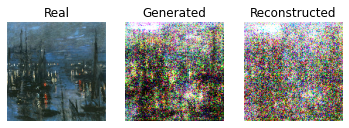

[INFO] Domain B to Domain A


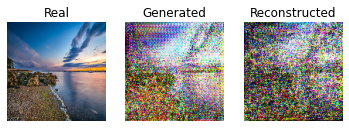

 60%|██████    | 1202/2000 [46:09<31:00,  2.33s/it]

In [0]:
visualize_every = 50

# training loop
for epoch in tqdm(range(2000)):
    # get the images
    images_A = iter(data_A_TF).next()
    images_B = iter(data_B_TF).next()

    # train the discriminator A
    dA_loss = train_discriminator_A(d_model_A, g_model_BtoA, images_B, images_A, d_model_A_opt)
    disc_A_metric(dA_loss)

    # train the discriminator B
    dB_loss = train_discriminator_B(d_model_B, g_model_AtoB, images_A, images_B, d_model_B_opt)
    disc_B_metric(dB_loss)

    # train generator AB
    gen_AB_loss = train_generator_AB(d_model_B, g_model_AtoB, g_model_BtoA, images_A, images_B, g_AtoB_opt)
    gen_AB_metric(gen_AB_loss)

    # train generator BA
    gen_BA_loss = train_generator_BA(d_model_A, g_model_BtoA, g_model_AtoB, images_B, images_A, g_BtoA_opt)
    gen_BA_metric(gen_BA_loss)

    # logging
    print(f"dA_loss: {disc_A_metric.result():.3f} dB_loss: {disc_B_metric.result():.3f} "
        f"gAB_loss :{gen_AB_metric.result():.3f} gBA_loss: {gen_BA_metric.result():.3f}")

    # visualization
    if epoch % visualize_every == 0:
        show_model_progress(g_model_AtoB, g_model_BtoA, scaled_dataA, scaled_dataB)

    # reset metrics
    disc_A_metric.reset_states()
    disc_B_metric.reset_states()
    gen_AB_metric.reset_states()
    gen_BA_metric.reset_states()

In [74]:
np.random.randint(0, scaled_dataA.shape[0], 1)

array([184])